# Classification Predict Student Solution

© Explore Data Science Academy

---
### Honour Code

We {*NM_1_Coders*}, confirm - by submitting this document - that the solutions in this notebook are a result of my own work and that I abide by the [EDSA honour code](https://drive.google.com/file/d/1QDCjGZJ8-FmJE3bZdIQNwnJyQKPhHZBn/view?usp=sharing).

Non-compliance with the honour code constitutes a material breach of contract.

### Predict Overview: Twitter Sentiment Classification

In the modern business landscape, many organizations are passionately embedding eco-conscious principles into their foundation, seeking to mitigate environmental impacts and promote sustainability. These companies offer a variety of products and services that align seamlessly with their green ethos. A crucial part of their strategic marketing is understanding how the public perceives the looming threat of climate change and the extent to which they view it as an immediate concern. This knowledge will provide a critical lens through which to anticipate how their offerings may resonate with potential consumers.

Set against this backdrop, EDSA puts forth an exhilarating challenge during the Classification Sprint. Participants are tasked to construct a machine learning model with the ability to discern whether individuals believe in climate change or not, harnessing the power of unique tweet data for this purpose.

A comprehensive and precise solution to this challenge equips businesses with a key to unlock expansive consumer sentiment insights. These insights cut across a diverse array of demographic and geographic categories, paving the way for an enriched understanding that can underpin and shape their future marketing strategies.

### Problem Statement

Companies operating in various industries need a reliable solution to understand the sentiments expressed by Twitter users regarding climate change. This information is crucial for making informed decisions, developing effective marketing strategies, and aligning their messaging with public sentiment. However, without a robust classification model, companies face challenges in accurately predicting sentiment and extracting valuable insights from the vast amount of data available on social media platforms. To address this problem, companies require a comprehensive sentiment analysis model that can provide real-time monitoring, sentiment classification, and trend analysis to help them stay ahead of the curve and effectively respond to the evolving concerns and preferences of their target audience.

In this notebook we set out to analyze tweets collected between Apr 27, 2015 and Feb 21, 2018 regarding climate change. We further wish to train a suitable and high performing classification model, to help classify the tweets into their respective sentiment categories regarding climate change. 

<a id="cont"></a>

## Table of Contents

<a href=#one>1. Importing Packages</a>

<a href=#two>2. Loading Data</a>

<a href=#three>3. Exploratory Data Analysis (EDA)</a>

<a href=#four>4. Data Engineering</a>

<a href=#five>5. Modeling</a>

<a href=#six>6. Model Performance</a>

<a href=#seven>7. Conclusions</a>

 <a id="one"></a>
## 1. Importing Packages
<a href=#cont>Back to Table of Contents</a>


First, we include a list of uncommon packages that may need to be installed on your system. Uncomment and run the following if you need some of the packages listed:

In [2]:
# !pip install wordcloud
# !pip install contractions
# !pip install catboost
# !pip install xgboost
# !pip install comet_ml
# !pip install emoji


Next, we import all necessary modules:

In [2]:
# Libraries for Data Loading and Manipulation
import pandas as pd  # Pandas provides flexible data structures to manipulate structured data.
import numpy as np  # Numpy offers powerful data structures and tools for numerical computation.

# Text Processing Libraries
import contractions  # Contractions is used to handle English contractions, converting them into their longer forms.
import emoji  # Emoji allows easy manipulation and analysis of emojis in the text.
from nltk.corpus import stopwords  # Stopwords module provides a list of common words to be removed from the text.
from nltk.stem import WordNetLemmatizer  # WordNetLemmatizer is used for lemmatizing words, bringing them to their root form.
from nltk import download as nltk_download  # For downloading nltk packages, here 'wordnet'.
import regex  # Regex is used for regular expression matching and manipulation.
import string  # Provides constants and classes for string manipulation.
import re # Provides common string operations
import unicodedata  # Provides access to the Unicode Character Database for processing Unicode characters.

#Data monitoring Libraries:
from comet_ml import Experiment  # Allows developers to track, compare, explain and optimize experiments and models.

# Machine Learning Libraries
from catboost import CatBoostClassifier  # High-performance gradient boosting on decision trees library.
from scipy.sparse import hstack  # Used for stacking sparse matrices horizontally.
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer  # Transforms text into feature vectors for machine learning.
from sklearn.metrics import classification_report, f1_score, precision_score, recall_score, confusion_matrix  # Metrics for evaluating machine learning models.
from sklearn.model_selection import train_test_split, GridSearchCV  # Provides utilities to split data and tune hyperparameters.
from sklearn.naive_bayes import GaussianNB, MultinomialNB  # Naive Bayes classifiers for machine learning.
from sklearn.linear_model import LogisticRegression # Logistic Regression classifier for machine learning.
from sklearn.tree import DecisionTreeClassifier # Decision Tree classifier for machine learning.
from sklearn.ensemble import RandomForestClassifier # Random Forrest classifier for machine learning
from sklearn.svm import LinearSVC, SVC  # Support Vector Machine classifiers.
from xgboost import XGBClassifier  # XGBoost is an efficient and flexible gradient boosting library.
import tensorflow as tf # For use in Neural Net
from tensorflow.keras.layers import Dense # For building neural net 
from tensorflow.keras.models import Sequential # For building neural net 
from tensorflow.keras import utils, backend as K # For neural net add ons 

# Feature selection Libraries:
from sklearn.feature_selection import SelectKBest # To reduce features
from sklearn.feature_selection import chi2 # Used to estimate which features is most impactful

# Data Visualization Libraries
import matplotlib.pyplot as plt  # Provides a way to visualize data (plotting, charts, etc.).
import seaborn as sns  # Provides a high-level interface for attractive, informative statistical graphics.
from sklearn.metrics import ConfusionMatrixDisplay # To visualize confusion matirces
from wordcloud import WordCloud, STOPWORDS, ImageColorGenerator  # Wordcloud is used to visualize word frequency in the text.
sns.set_theme(style="whitegrid")  # Sets the style for seaborn plots.

# Utility Libraries
import pickle # For saving models to file
from sklearn.utils import resample # For resampling unbalanced data
from imblearn.combine import SMOTETomek


# Downloading necessary NLTK corpus
nltk_download('wordnet')

# Global Constants for reproducibility and consistency
TRAIN_TEST_SPLIT_VAR = 0.2
RAND_STATE = 42
MAX_TEXT_FEATURES = 50000 # For all algorithms with exception to those listed below
RAD_SVC_Text_Features = 3000 # Specifically for use in radial svc
NN_Text_Features = 5000 #Specifically for use of neural net
XGB_Text_Features = 3000 # Specifically for use in XGBoost algorithm
RESAMPLE_ENTRY_AMOUNT = 4500 # If resampling, how many entries per category (Between 1000 and 6000)
VEC_MIN_WORD_TO_REMOVE = 1 # Remove words that occurs less that this value in dataset 


# Flags for notebook Execution
COMET_FLAG = False # To gauge wether to commit experiments to Comet ML
VECTORIZER_TO_USE = "tfidf" # Chooses between TfIDF vectorizer or count Vectorizer - accepted values are "tfidf" or "count"
RESAMPLE = False # Whether to resample training data
REMOVE_OVERUSED_WORDS = False # Wether to remove non-class specific words that occurs a lot

# Select which models to tune hyperparameters on
HYPERPARAM_TO_Tune = {
    "Logistic Regression" : False,
    "Decision Tree": False,
    "Random Forrest": False,
    "Linear Support Vector": False,
    "Radial Support Vector": False,
    "Gaussian Naive Bayes": False,
    "Multinomial Naive Bayes": False,
    "CatBoost": False,
    "XGBoost": False
}

[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\thato\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


In [139]:
from IPython.display import Image
image_url = 'https://media.proprofs.com/images/QM/user_images/2286127/1551760625.jpg'
Image(url=image_url)

<a id="two"></a>
## 2. Loading the Data
<a class="anchor" id="1.1"></a>
<a href=#cont>Back to Table of Contents</a>

We load the data from the datafiles:

In [3]:
# Creating dataframes for the different datasets
df_train = pd.read_csv('train.csv')
df_evaluate = pd.read_csv('test_with_no_labels.csv')

<a id="three"></a>
## 3. Exploratory Data Analysis (EDA)
<a class="anchor" id="1.1"></a>
<a href=#cont>Back to Table of Contents</a>

Before we can jump in and construct models for the data, it is important to investigate and understand the features present within the dataset


Let's start with investigating the dataset by viewing how the dataframe is currently looking:

In [12]:
# Show the first 30 entries of the training dataset:
df_train.head(30)

sentiment                                            message  tweetid
0           1  PolySciMajor EPA chief doesn't think carbon di...   625221
1           1  It's not like we lack evidence of anthropogeni...   126103
2           2  RT @RawStory: Researchers say we have three ye...   698562
3           1  #TodayinMaker# WIRED : 2016 was a pivotal year...   573736
4           1  RT @SoyNovioDeTodas: It's 2016, and a racist, ...   466954
5           1  Worth a read whether you do or don't believe i...   425577
6           1  RT @thenation: Mike Pence doesn’t believe in g...   294933
7           1  RT @makeandmendlife: Six big things we can ALL...   992717
8           1  @AceofSpadesHQ My 8yo nephew is inconsolable. ...   664510
9           1  RT @paigetweedy: no offense… but like… how do ...   260471
10          1  RT @StephenSchlegel: she's thinking about how ...   295793
11          1  I do hope people who are vocal about climate c...   763719
12          2  RT @tveitdal: We only have a 5 percent chance ...   454673
13          1  RT @Alifaith55: Oh. My. God.\n\nTrump's Govern...    41161
14          2  Fossil fuel giant ExxonMobil ‘misled’ the publ...   658092
15          1  RT @GlblCtzn: 'I don't wanna live forever – an...   319524
16          1  RT @jackholmes0: Issues scrubbed from https://...   698009
17          1  RT @patagonia: If our elected leaders fail to ...   490604
18          1  RT @SenSanders: We have a president-elect who ...   228658
19          0  Calum: *tweets abt reunitingish w the cast*\n-...   547924
20          1  RT @c40cities: 46 C40 Mayors, representing 250...   625014
21          1  RT @World_Wildlife: How climate change impacts...   690605
22          0  we also met this guy, he let us in on some tru...    67545
23          1  https://t.co/KyNIBjmDk5\nScientists say climat...   567842
24          1  RT @TammyGrubb: Obama raises climate change. Y...   684492
25          1  I hate to say this, but *mental* health will b...   438578
26          2  Bangladesh confronting climate change head on ...   365291
27          1  Hey There! Michael's vetted and approved marke...   387685
28         -1  Sally Kohn’s latest evidence of climate change...   355491
29          1  RT @StarTalkRadio: First: The public understan...   354015

We have 3 distinct columns in the dataset: 
- `sentiment`: Which class a tweet belongs in
- `message`: Tweet body
- `tweetid`: Twitter unique id

For the purposes of our model, we wish to predict the sentiment regarding climate change of an individual, based on the message contained within their tweets. This means that our target variable is that of `sentiment`, and our predictor variable is that of `message` 

We also see that the classes that our target variable `sentiment` falls into is more than 2, which means we are not dealing with a simple binary classification problem. These classes can be described as follows:

- 2 **News**: the tweet links to factual news about climate change
- 1 **Pro**: the tweet supports the belief of man-made climate change
- 0 **Neutral**: the tweet neither supports nor refutes the belief of man-made climate change
- -1 **Anti**: the tweet does not believe in man-made climate change

Let's now look at the datatypes contained within our dataset:

In [13]:
df_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 15819 entries, 0 to 15818
Data columns (total 3 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   sentiment  15819 non-null  int64 
 1   message    15819 non-null  object
 2   tweetid    15819 non-null  int64 
dtypes: int64(2), object(1)
memory usage: 370.9+ KB


We note that we have a total of 15819 entries, spanning 3 columns.

We also see that both our `tweetid` and `sentiment` columns is of integer type, while our `message` column is of type string. This was to be expected, but it is always a good idea to verify! 




Let us consider if our dataset contains missing values:

In [14]:
df_train.isnull().sum()

sentiment    0
message      0
tweetid      0
dtype: int64

Luckily, we don't have any missing data. 
Let's check if our dataset contains repeating tweets:

In [15]:
duplicates = df_train[df_train[['message', 'sentiment']].duplicated(keep=False)]
duplicates


sentiment                                            message  tweetid
10             1  RT @StephenSchlegel: she's thinking about how ...   295793
17             1  RT @patagonia: If our elected leaders fail to ...   490604
18             1  RT @SenSanders: We have a president-elect who ...   228658
21             1  RT @World_Wildlife: How climate change impacts...   690605
35             1  RT @BernieSanders: #ImVotingBecause the future...   817108
...          ...                                                ...      ...
15781          1  RT @StephenSchlegel: she's thinking about how ...   869993
15799          1  RT @SethMacFarlane: HRC proposes installing ha...    52528
15801          1  RT @SenSanders: On virtually every major issue...   331127
15811          1  RT @StephenSchlegel: she's thinking about how ...   426353
15815          2  RT @washingtonpost: How climate change could b...    17856

[1900 rows x 3 columns]

We see that we have 1900 entries for which the same tweet and sentiment is repeated somewhere in the dataset. Since those variables constitutes both our predictors and target variables, we should consider removing them as they add no value to the model anymore.


Now, let's look at how our data is distributed within each class in our target variable in the dataset we will be training on:

[Text(0, 0, '1296'),
 Text(0, 0, '2353'),
 Text(0, 0, '8530'),
 Text(0, 0, '3640')]

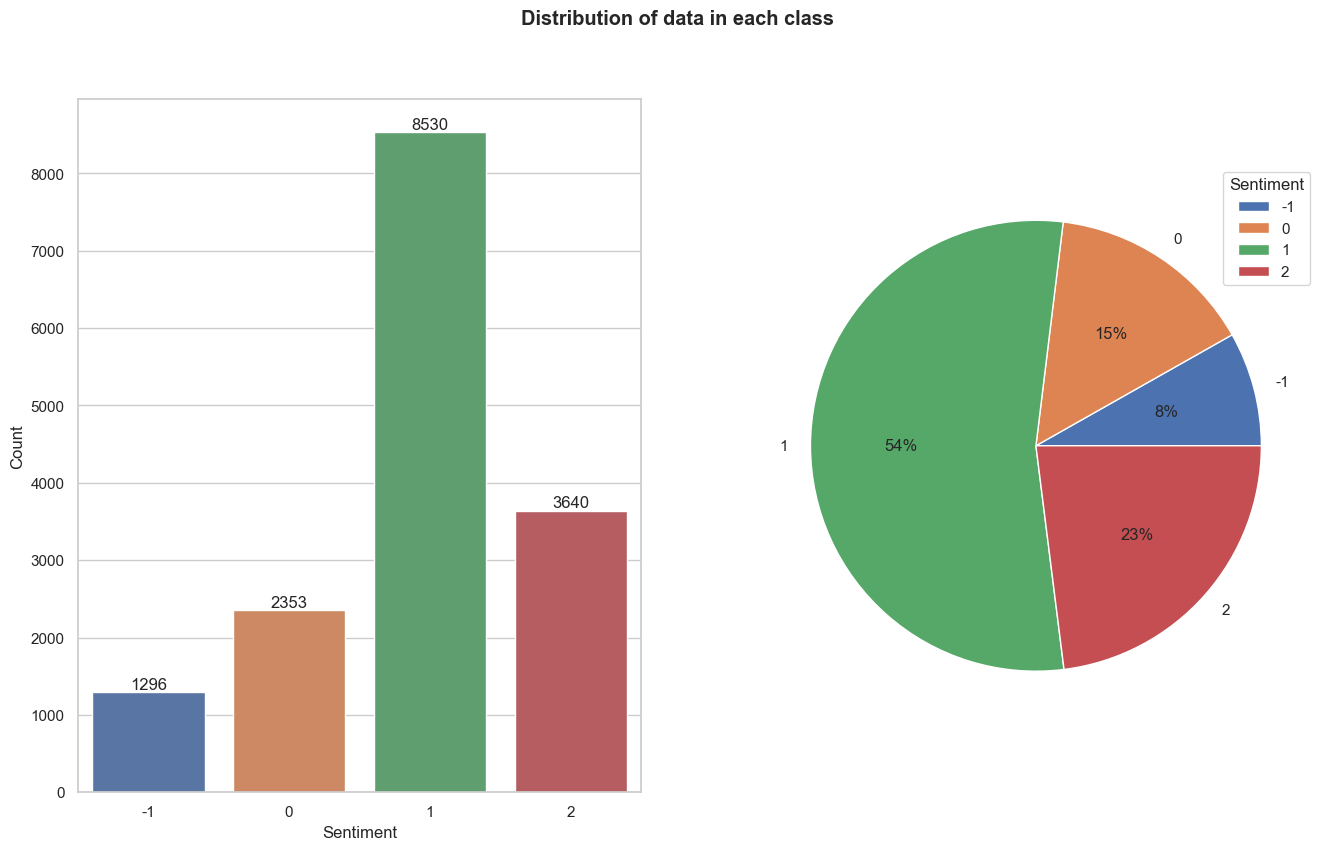

In [16]:
# Create multiple subplots
fig, axs = plt.subplots(1,2, figsize=(16,9))
# Set title of graph
fig.suptitle("Distribution of data in each class", fontweight='bold' )

# Plot 
sns.countplot(ax=axs[0], x=df_train['sentiment'])
df_train.groupby(['sentiment']).count().plot(ax=axs[1], kind = 'pie', y='message', autopct='%1.0f%%')

axs[1].set_ylabel('')
axs[1].legend(title = "Sentiment")

axs[0].set_xlabel('Sentiment')
axs[0].set_ylabel('Count')

axs[0].bar_label(axs[0].containers[0])


From the figures above, we see that the dataset we are working with is very unbalanced. More than half of our dataset is people having pro-climate change sentiments, while only $ 8 \% $ of our data represents people with anti-climate change opinions. This might lead our models to become far better at identifying pro-climate change sentiment than anti-climate change sentiment, and we might need to consider balancing the data by resampling it.

Next, let us look at if any features contained within the tweets can help us identify to which sentiment the user belongs. Let's write some functions that will extract the retweets, hashtags and mentions from the tweets:

In [17]:
'''Determine if there is a retweet within the tweet'''
def is_retweet(tweet):
    word_list = tweet.split()
    if "RT" in word_list:
        return 1
    else:
        return 0

''' Function to extract retweet handles from tweet '''
def get_retweet(tweet):
    word_list = tweet.split()
    if word_list[0] == "RT":
        handle = word_list[1]
    else:
        handle = ''
        
    handle = handle.replace(':', "")

    return handle


'''Count the number of hashtags within the tweet'''
def count_hashtag(tweet):
    count = 0
    word_list = tweet.split()
    for word in word_list:
        if word[0] == '#':
            count +=1
    
    return count

'''Extract the hashtags within the tweet'''
def get_hashtag(tweet):
    hashtags = []
    word_list = tweet.split()
    for word in word_list:
        if word[0] == '#':
            hashtags.append(word)
    
    returnstr = ""
    for tag in hashtags:
        returnstr += " " + tag

    return returnstr


'''Count the number of mentions within the tweet'''
def count_mentions(tweet):
    count = 0
    word_list = tweet.split()
    if "RT" in word_list:
        count += -1 # Remove mention contained in retweet form consideration
        
    for word in word_list:
            if word[0] == '@':
                count +=1
    if count == -1:
        count = 0
    return count

'''Extract the mentions within the tweet'''
def get_mentions(tweet):
    mentions = []
    word_list = tweet.split()
    if "RT" in word_list:
        word_list.pop(1) # Retweets don't count as mentions, so we remove the retweet handle from consideration

    for word in word_list:
        if word[0] == '@':
            mentions.append(word)
    
    returnstr = ""
    for handle in mentions:
        returnstr += " " + handle

    return returnstr

Let's investigate how these features differ between classes. First, let's start by creating a copy of our data:

In [18]:
df_eda = df_train

Now, let's create some new columns containing the retweets, mentions and hashtags we wish to extract:

In [19]:
# Get retweet status and handle
df_eda["is_retweet"] = df_eda["message"].apply(is_retweet, 1)
df_eda["retweet_handle"] =  df_eda["message"].apply(get_retweet, 1)

# Get hashtag count and extract hashtags
df_eda["hashtag_count"] = df_eda["message"].apply(count_hashtag, 1)
df_eda["hashtags"] =  df_eda["message"].apply(get_hashtag, 1)

# Get mention count and extract mentions
df_eda["mention_count"] = df_eda["message"].apply(count_mentions, 1)
df_eda["mentions"] =  df_eda["message"].apply(get_mentions, 1)

# Print first 30 entries of new dataframe to validate that features were added correctly
df_eda.head(20)

sentiment                                            message  tweetid  \
0           1  PolySciMajor EPA chief doesn't think carbon di...   625221   
1           1  It's not like we lack evidence of anthropogeni...   126103   
2           2  RT @RawStory: Researchers say we have three ye...   698562   
3           1  #TodayinMaker# WIRED : 2016 was a pivotal year...   573736   
4           1  RT @SoyNovioDeTodas: It's 2016, and a racist, ...   466954   
5           1  Worth a read whether you do or don't believe i...   425577   
6           1  RT @thenation: Mike Pence doesn’t believe in g...   294933   
7           1  RT @makeandmendlife: Six big things we can ALL...   992717   
8           1  @AceofSpadesHQ My 8yo nephew is inconsolable. ...   664510   
9           1  RT @paigetweedy: no offense… but like… how do ...   260471   
10          1  RT @StephenSchlegel: she's thinking about how ...   295793   
11          1  I do hope people who are vocal about climate c...   763719   
12          2  RT @tveitdal: We only have a 5 percent chance ...   454673   
13          1  RT @Alifaith55: Oh. My. God.\n\nTrump's Govern...    41161   
14          2  Fossil fuel giant ExxonMobil ‘misled’ the publ...   658092   
15          1  RT @GlblCtzn: 'I don't wanna live forever – an...   319524   
16          1  RT @jackholmes0: Issues scrubbed from https://...   698009   
17          1  RT @patagonia: If our elected leaders fail to ...   490604   
18          1  RT @SenSanders: We have a president-elect who ...   228658   
19          0  Calum: *tweets abt reunitingish w the cast*\n-...   547924   

    is_retweet    retweet_handle  hashtag_count         hashtags  \
0            0                                0                    
1            0                                0                    
2            1         @RawStory              0                    
3            0                                1   #TodayinMaker#   
4            1  @SoyNovioDeTodas              1   #ElectionNight   
5            0                                0                    
6            1        @thenation              0                    
7            1  @makeandmendlife              0                    
8            0                                0                    
9            1      @paigetweedy              0                    
10           1  @StephenSchlegel              0                    
11           0                                0                    
12           1         @tveitdal              0                    
13           1       @Alifaith55              1    #climatemarch   
14           0                                0                    
15           1         @GlblCtzn              0                    
16           1      @jackholmes0              0                    
17           1        @patagonia              0                    
18           1       @SenSanders              0                    
19           0                                0                    

    mention_count                    mentions  
0               1                   @mashable  
1               0                              
2               0                              
3               0                              
4               0                              
5               0                              
6               0                              
7               0                              
8               1              @AceofSpadesHQ  
9               0                              
10              0                              
11              1                 @GoodEnergy  
12              0                              
13              0                              
14              0                              
15              2   @taylorswift13 @zaynmalik  
16              0                              
17              0                              
18              0                            

By using the above functions, we have added a lot of features to the dataset which can be investigated. First, let's consider how many of our data entries is retweets compared to original tweets:

Text(0.5, 1.0, 'Proportion of Original Mentions')

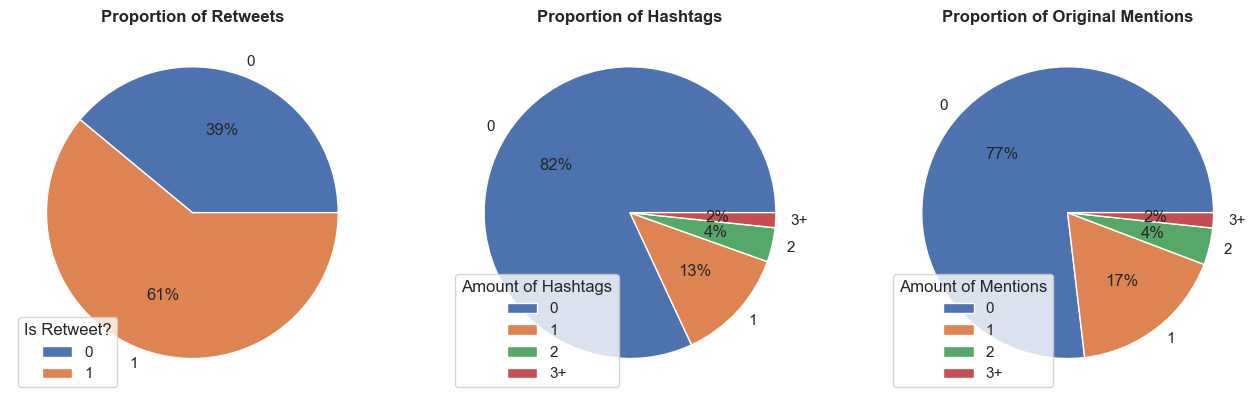

In [20]:
# Create a subset of figures
fig, axs = plt.subplots(1,3, figsize=(16,9))

# Plot pie graph showing retweet distribution
df_eda.groupby(['is_retweet']).count().plot( ax = axs[0], kind = 'pie', y='message', autopct='%1.0f%%' )
axs[0].set_ylabel('')
axs[0].legend(title = "Is Retweet?", loc=3)
axs[0].set_title("Proportion of Retweets", fontweight = 'bold')


# Function to make hashtag and mention count neat for pie chart
def modify_count(count):
    if count >=3:
        return "3+"
    else:
        return str(count)

# Apply function for hashtags:
df_eda['pretty_plot_hashtag'] = df_eda["hashtag_count"].apply(modify_count, 1)

# Apply function for mentions
df_eda['pretty_plot_mention'] = df_eda["mention_count"].apply(modify_count, 1)

# Plot pie graph showing hashtag distribution
df_eda.groupby(['pretty_plot_hashtag']).count().plot( ax = axs[1], kind = 'pie', y='message', autopct='%1.0f%%' )
axs[1].set_ylabel('')
axs[1].legend(title = "Amount of Hashtags", loc = 3)
axs[1].set_title("Proportion of Hashtags", fontweight = 'bold')

# Plot pie graph showing mention distribution
df_eda.groupby(['pretty_plot_mention']).count().plot( ax = axs[2], kind = 'pie', y='message', autopct='%1.0f%%' )
axs[2].set_ylabel('')
axs[2].legend(title = "Amount of Mentions", loc=3)
axs[2].set_title("Proportion of Original Mentions", fontweight = 'bold')

We see that a staggering $60\%$ of all our data is not original tweets, but retweets! This indicates that extracting more information from the retweets could prove integral to optimizing our model's predictive capabilities. 

Furthermore, we see that $82\%$ of our data contains no hashtags. While the hashtags that is being used could still provide a great starting point for the model, most of the data does not contain hashtags and as such, this feature might prove less useful than one might hope. 

Lastly, let's consider the mentions. For our purposes, we only look at original mentions, meaning that we don't consider handles that gets retweeted to count towards the total. We see that even though the majority of data does not contain original mentions, there still exist a substantial amount within our data, and will therefore be important to consider within our model.

Let's break the above statistics down by category, to see if there exist certain trends within the sentiment groups that could help us with identifying them: 

Text(0.5, 1.0, 'Average Mentions per Tweet per Sentiment Group')

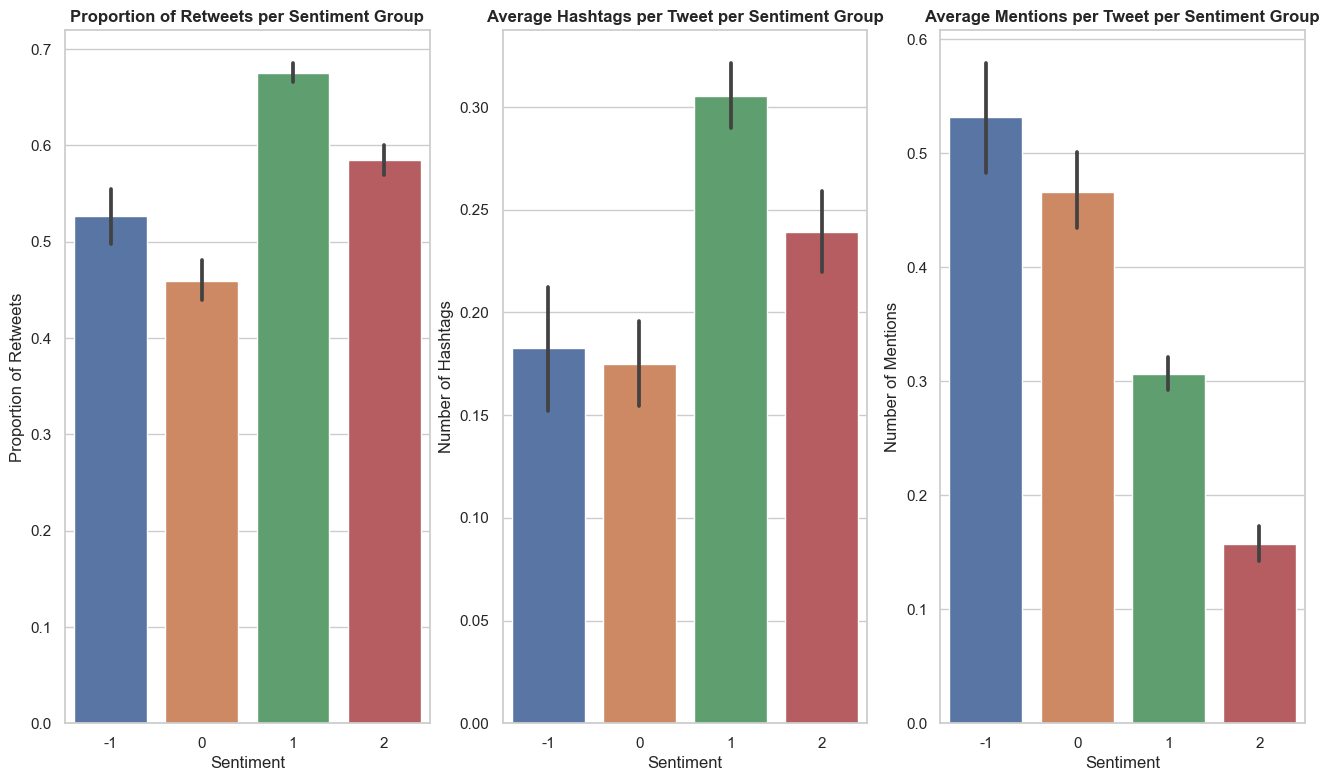

In [21]:
# Create a grid of figures
fig, axs = plt.subplots(1,3,figsize=(16,9))

# Plot retweet distribution
sns.barplot(ax = axs[0] ,data=df_eda, x="sentiment", y="is_retweet")
axs[0].set_ylabel('Proportion of Retweets')
axs[0].set_xlabel("Sentiment")
axs[0].set_title("Proportion of Retweets per Sentiment Group", fontweight = 'bold')
# axs[0].bar_label(axs[0].containers[0])

# Plot hashtag distribution
sns.barplot(ax = axs[1] ,data=df_eda, x="sentiment", y="hashtag_count")
axs[1].set_ylabel('Number of Hashtags')
axs[1].set_xlabel("Sentiment")
axs[1].set_title("Average Hashtags per Tweet per Sentiment Group", fontweight = 'bold')
# axs[1].bar_label(axs[1].containers[0])

# Plot mentions distribution
sns.barplot(ax = axs[2] ,data=df_eda, x="sentiment", y="mention_count")
axs[2].set_ylabel('Number of Mentions')
axs[2].set_xlabel("Sentiment")
axs[2].set_title("Average Mentions per Tweet per Sentiment Group", fontweight = 'bold')
# axs[2].bar_label(axs[2].containers[0])


First, let us consider the proportion of tweets that are retweets for each individual sentiment. We see that in our dataset, the people with a pro-climate change outlook has the highest proportion of retweets of any group, with news tweets from the media coming in a close second. Even though the differences between these categories isn't that big, it still captures a substantial effect, and it would be beneficial to include retweets within the model. 

Next, we consider the average number of hashtags contained within the tweets. Here, we find a vast difference between certain categories. Once again, the group expressing pro-climate change sentimentalities uses the most number of hashtags, followed closely by factual news tweets. The neutral and anti-climate change categories are far less likely to use hashtags in their tweets, since they use fewer hashtags on average

Finally, we consider the amount of original mentions for each group. Remember, we define _original mentions_ to be any mentions contained within tweets after the retweet handle was removed, i.e. it refers to mentions within tweets, but disregards retweet handles from the list. Here, we see a surprising trend. The anti-climate change group uses the most amount of mentions per tweet- substantially more than the pro-climate change group and more than double that of the factual news tweets. 

All of the features above identify valuable differences between the classes, and as such, should be included within the model.

Let's break it down a bit further, and dive deeper into the most popular retweets, hashtags and mentions per category. First, let's manipulate the data into a more usable form in order to help us draw word clouds. First, we split our dataframe into multiple dataframes based on the sentiment we wish to investigate:

In [22]:
# Filter Anti-Climate change sentiment
df_eda_anti = df_eda[df_eda["sentiment"] ==  -1]
# Filter neutral sentiment
df_eda_neutral = df_eda[df_eda["sentiment"] ==  0]
# Filter Pro-Climate change sentiment
df_eda_pro = df_eda[df_eda["sentiment"] ==  1]
# Filter factual news sentiment
df_eda_news = df_eda[df_eda["sentiment"] ==  2]


We start with looking at the most common retweeted handles for each category: 

(-0.5, 1599.5, 1599.5, -0.5)

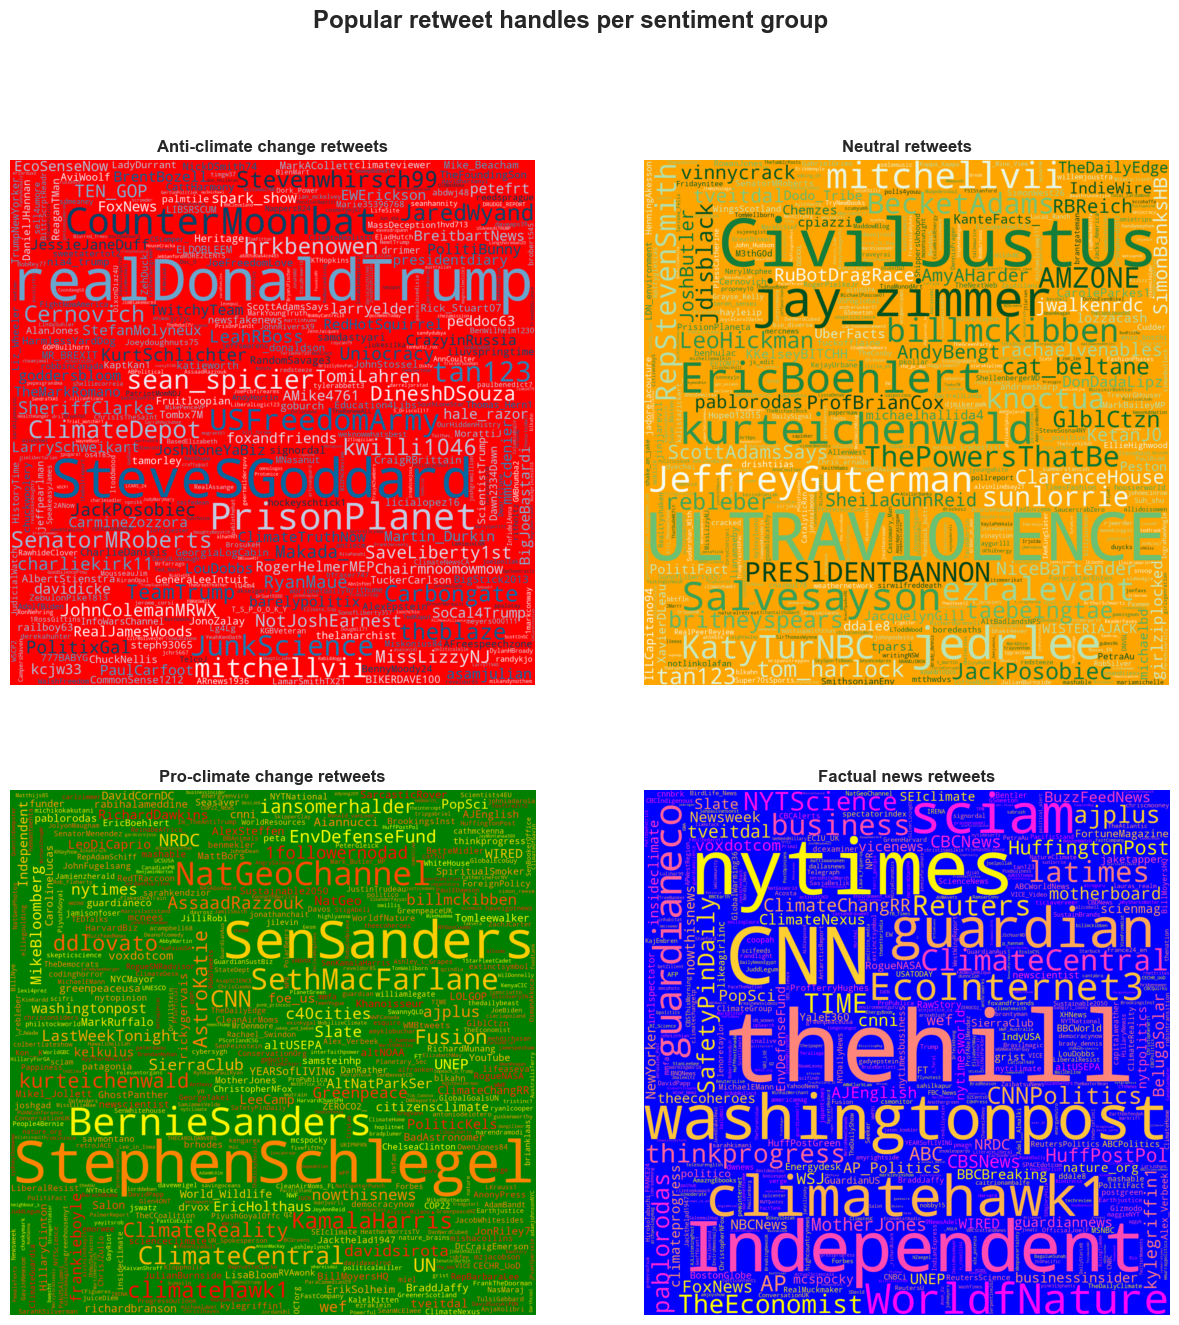

In [23]:
# Create word strings containing retweet handles for each sentiment
word_string_anti=" ".join(df_eda_anti['retweet_handle'])
word_string_neutral=" ".join(df_eda_neutral['retweet_handle'])
word_string_pro=" ".join(df_eda_pro['retweet_handle'])
word_string_news=" ".join(df_eda_news['retweet_handle'])

# Create a new figure
plt.figure(figsize=(15,15))

plt.suptitle("Popular retweet handles per sentiment group", fontweight='bold', fontsize = "x-large")
# Plot anti-climate change sentiments
plt.subplot(2,2,1).set_title("Anti-climate change retweets", fontweight = 'bold')
wc = WordCloud(background_color="red", max_words=500, max_font_size= 300,  width=1600, height=1600)
wc.generate(word_string_anti)
plt.imshow(wc.recolor( colormap= 'PuBu' , random_state=17), interpolation="bilinear")
plt.axis('off')

# Plot neutral sentiments
plt.subplot(2,2,2).set_title("Neutral retweets", fontweight = 'bold')
wc = WordCloud(background_color="orange", max_words=500, max_font_size= 300,  width=1600, height=1600)
wc.generate(word_string_neutral)
plt.imshow(wc.recolor( colormap= 'Greens' , random_state=17), interpolation="bilinear")
plt.axis('off')

# Plot pro-climate change sentiments
plt.subplot(2,2,3).set_title("Pro-climate change retweets", fontweight = 'bold')
wc = WordCloud(background_color="green", max_words=500, max_font_size= 300,  width=1600, height=1600)
wc.generate(word_string_pro)
plt.imshow(wc.recolor( colormap= 'autumn' , random_state=17), interpolation="bilinear")
plt.axis('off')

# Plot pro-climate change sentiments
plt.subplot(2,2,4).set_title("Factual news retweets", fontweight = 'bold')
wc = WordCloud(background_color="blue", max_words=500, max_font_size= 300,  width=1600, height=1600)
wc.generate(word_string_news)
plt.imshow(wc.recolor( colormap= 'spring' , random_state=17), interpolation="bilinear")
plt.axis('off')

From the above, we see a clear difference between every sentiment with regards to who they are retweeting. This is great news, since it will provide an excellent feature within our model. Little overlap between categories is visible, which points to the fact that this feature could be a very strong predictor.

We see that people with anti-climate change sentiments retweets from users like `@realDonaldTrump` and `@SteveSGoddard` the most. Overall retweets associated with anti-climate science opinions are frequently sourced from prominent Republican figures such as Donald Trump, along with individuals who identify as climate change deniers, like Steve Goddard.

In contrast to this, people with pro-climate change views often retweet Democratic political figures such as `@SenSanders` and `@KamalaHarris`. Along with this, we see a trend to retweet comedians like `@SethMacFarlane`. The most retweeted individual for this category, is `@StephenSchlegel`. 

Retweets in the factual news category mostly contains handles of media news organizations, like `@thehill`, `@CNN`, `@wasgingtonpost` etc...

People with neutral sentiments regarding climate change seems to not retweet overtly political figures. Instead, they retweet handles unknown to the writer like `@CivilJustUs` and `@ULTRAVIOLENCE` which no longer currently exist on twitter. The comedian `@jay_zimmer` is also a common retweeted incividual within this category.

By repeating the steps above, we can now turn our attention to the different hashtags popular within each category:

(-0.5, 1599.5, 1599.5, -0.5)

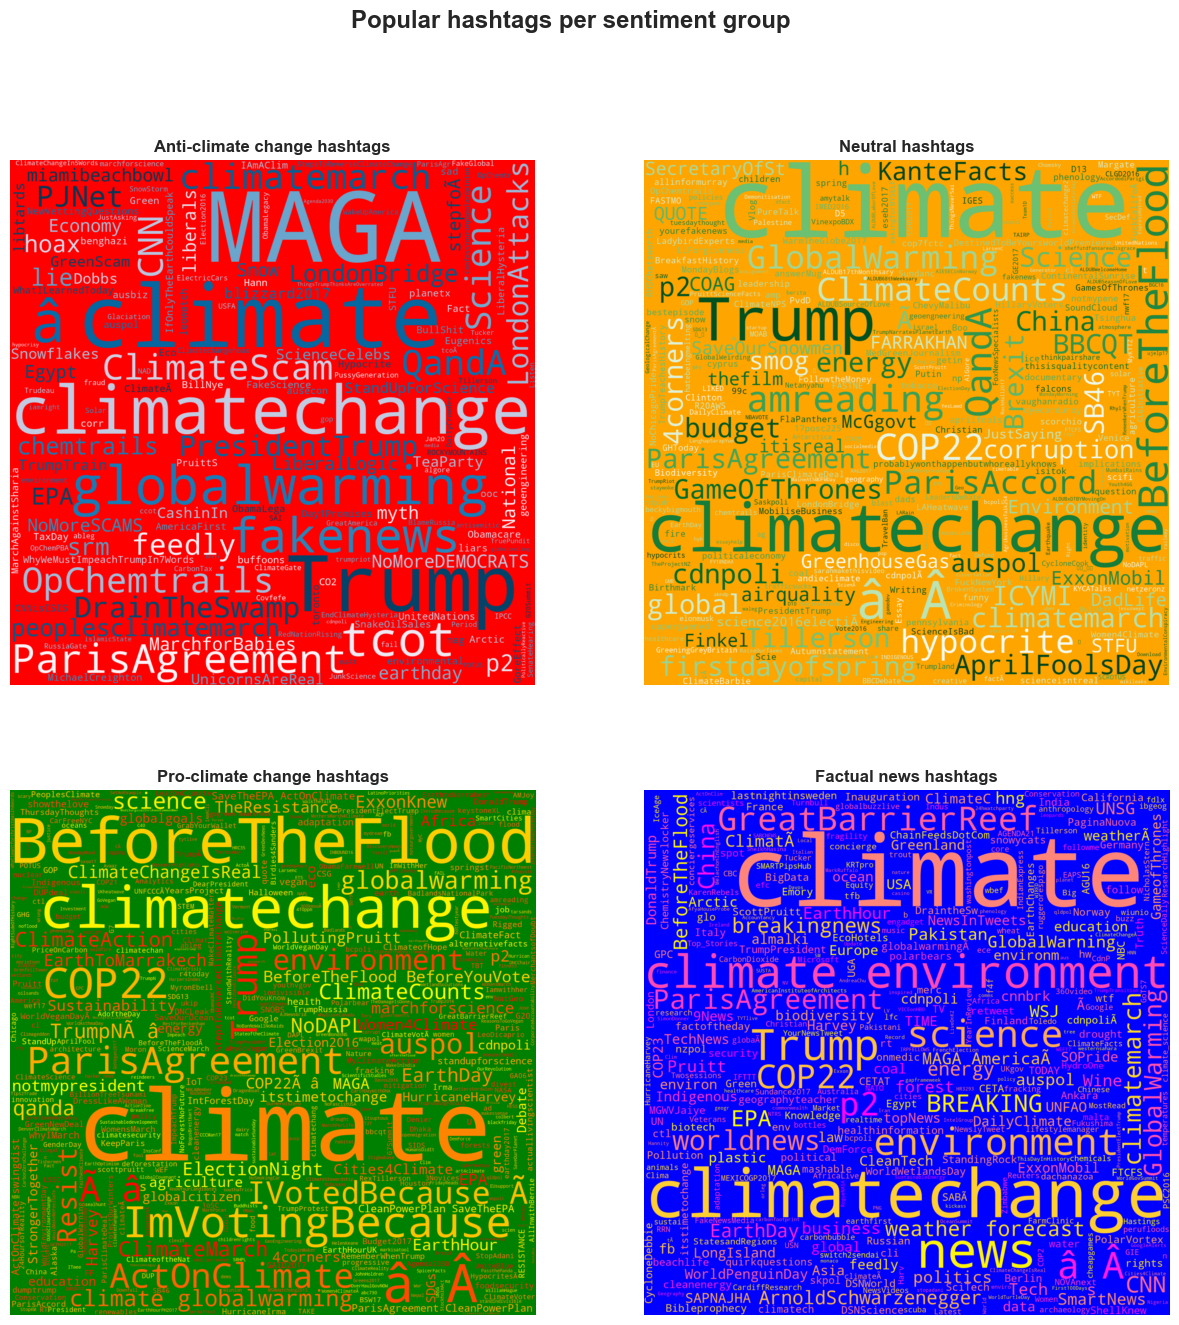

In [24]:
# Create word strings containing retweet handles for each sentiment
word_string_anti=" ".join(df_eda_anti['hashtags'])
word_string_neutral=" ".join(df_eda_neutral['hashtags'])
word_string_pro=" ".join(df_eda_pro['hashtags'])
word_string_news=" ".join(df_eda_news['hashtags'])

# Create a new figure
plt.figure(figsize=(15,15))
plt.suptitle("Popular hashtags per sentiment group", fontweight='bold', fontsize = "x-large")

# Plot anti-climate change sentiments
plt.subplot(2,2,1).set_title("Anti-climate change hashtags", fontweight = 'bold')
wc = WordCloud(background_color="red", max_words=500, max_font_size= 300,  width=1600, height=1600)
wc.generate(word_string_anti)
plt.imshow(wc.recolor( colormap= 'PuBu' , random_state=17), interpolation="bilinear")
plt.axis('off')

# Plot neutral sentiments
plt.subplot(2,2,2).set_title("Neutral hashtags", fontweight = 'bold')
wc = WordCloud(background_color="orange", max_words=500, max_font_size= 300,  width=1600, height=1600)
wc.generate(word_string_neutral)
plt.imshow(wc.recolor( colormap= 'Greens' , random_state=17), interpolation="bilinear")
plt.axis('off')

# Plot pro-climate change sentiments
plt.subplot(2,2,3).set_title("Pro-climate change hashtags", fontweight = 'bold')
wc = WordCloud(background_color="green", max_words=500, max_font_size= 300,  width=1600, height=1600)
wc.generate(word_string_pro)
plt.imshow(wc.recolor( colormap= 'autumn' , random_state=17), interpolation="bilinear")
plt.axis('off')

# Plot pro-climate change sentiments
plt.subplot(2,2,4).set_title("Factual news hashtags", fontweight = 'bold')
wc = WordCloud(background_color="blue", max_words=500, max_font_size= 300,  width=1600, height=1600)
wc.generate(word_string_news)
plt.imshow(wc.recolor( colormap= 'spring' , random_state=17), interpolation="bilinear")
plt.axis('off')

From the visual above, we notice a few things:

First of all, there is some strange characters in our data, like `#Ã â` and `#â Â` for example. This is considered noise, and will need to be removed before training our models. 

We see that a lot of hashtags are common in every sentiment category. Hashtags like `#climatechange`, `#cllimate` and `#Trump` is abundant regardless of which category is considered, and can therefore be removed from the list of hashtags since they won't contribute any meaningful insight to our models. 

Finally there is some hashtags that are more prominent within certain sentiment groups. Take `#MAGA` and `#fakenews` in the anti-climate change category, or `#ImVotingBecause` in the pro-climate change category. This indicates that some useful information can be extracted from this feature, and should remain within the model.

Let's repeat the process one last time in order to investigate the original mentions in each category

(-0.5, 1599.5, 1599.5, -0.5)

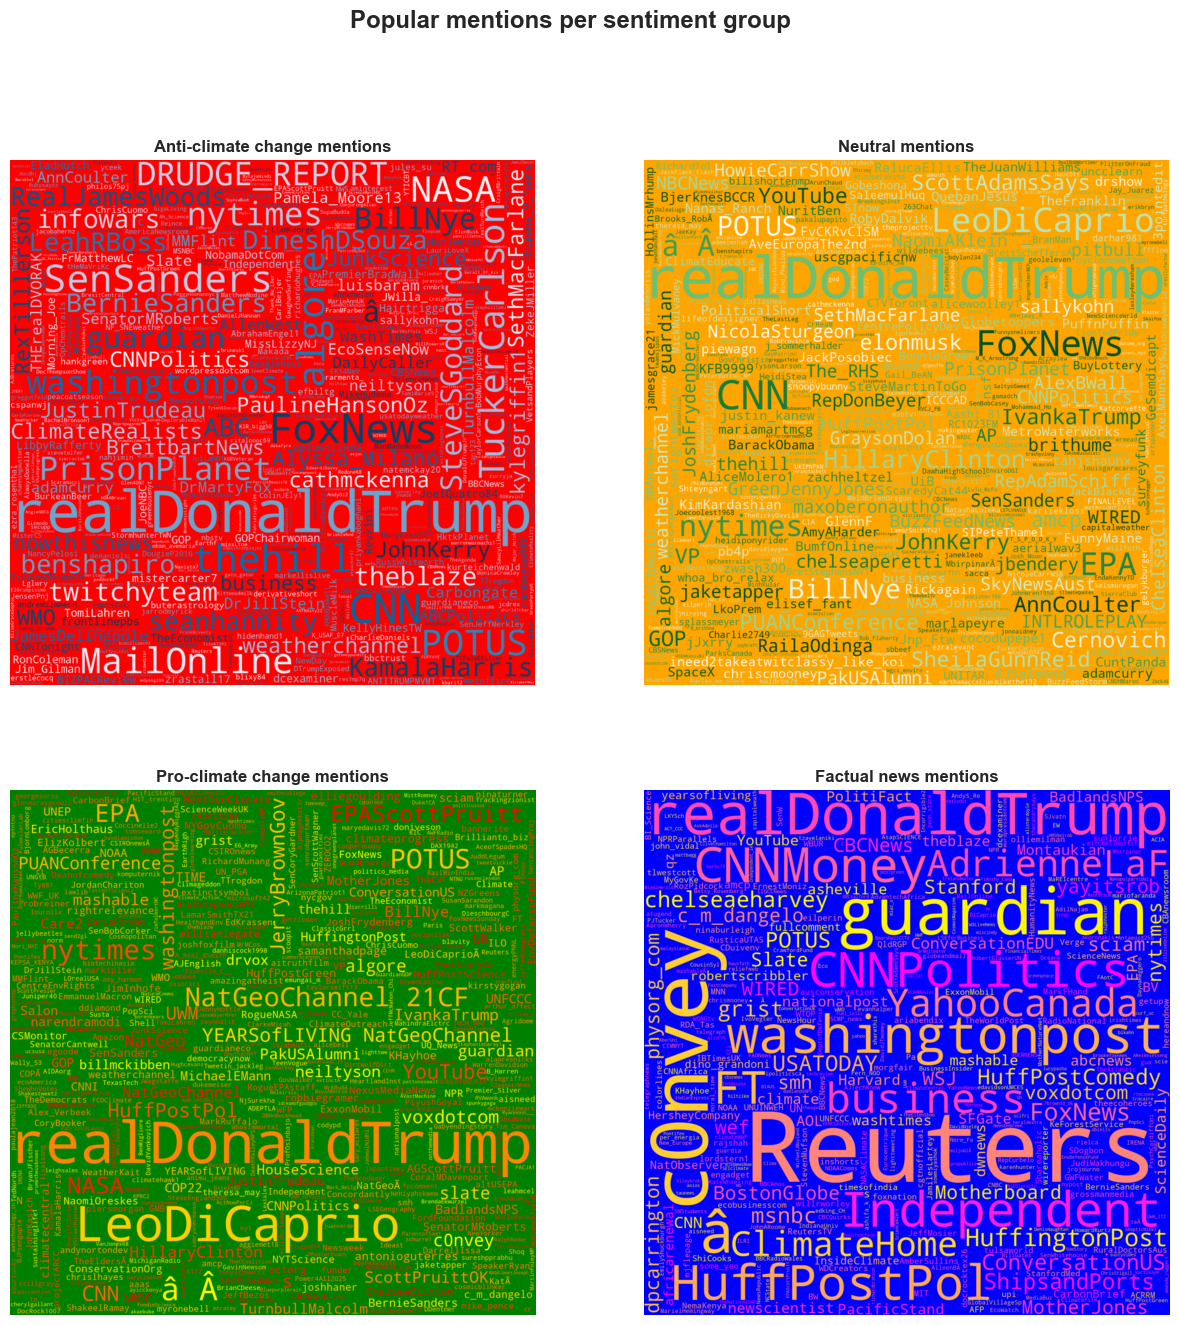

In [25]:
# Create word strings containing retweet handles for each sentiment
word_string_anti=" ".join(df_eda_anti['mentions'])
word_string_neutral=" ".join(df_eda_neutral['mentions'])
word_string_pro=" ".join(df_eda_pro['mentions'])
word_string_news=" ".join(df_eda_news['mentions'])

# Create a new figure
plt.figure(figsize=(15,15))
plt.suptitle("Popular mentions per sentiment group", fontweight='bold', fontsize = "x-large")

# Plot anti-climate change sentiments
plt.subplot(2,2,1).set_title("Anti-climate change mentions", fontweight = 'bold')
wc = WordCloud(background_color="red", max_words=500, max_font_size= 300,  width=1600, height=1600)
wc.generate(word_string_anti)
plt.imshow(wc.recolor( colormap= 'PuBu' , random_state=17), interpolation="bilinear")
plt.axis('off')

# Plot neutral sentiments
plt.subplot(2,2,2).set_title("Neutral mentions", fontweight = 'bold')
wc = WordCloud(background_color="orange", max_words=500, max_font_size= 300,  width=1600, height=1600)
wc.generate(word_string_neutral)
plt.imshow(wc.recolor( colormap= 'Greens' , random_state=17), interpolation="bilinear")
plt.axis('off')

# Plot pro-climate change sentiments
plt.subplot(2,2,3).set_title("Pro-climate change mentions", fontweight = 'bold')
wc = WordCloud(background_color="green", max_words=500, max_font_size= 300,  width=1600, height=1600)
wc.generate(word_string_pro)
plt.imshow(wc.recolor( colormap= 'autumn' , random_state=17), interpolation="bilinear")
plt.axis('off')

# Plot pro-climate change sentiments
plt.subplot(2,2,4).set_title("Factual news mentions", fontweight = 'bold')
wc = WordCloud(background_color="blue", max_words=500, max_font_size= 300,  width=1600, height=1600)
wc.generate(word_string_news)
plt.imshow(wc.recolor( colormap= 'spring' , random_state=17), interpolation="bilinear")
plt.axis('off')

As was the case when we considered hashtags, we see that some handles get mentioned regardless of sentiment class. An example of this is `@realDonaldTrump`, which is prominent in every sentiment category, and as such should be removed before training our models, since it adds no value towards our data. 

Furthermore, there is some mentions that are more prominent in certain classes than others. Take `@LeoDiCaprio` for example, which features heavily in both pro-climate change as well as neutral towards climate change sentiment, but is not represented in the other two categories. This indicates that this feature could be beneficial for categorizing our data, and should remain within the dataset





Let's investigate if there exist more features that could help identify the category a tweet belongs to.

 Looking at our data, we see that a lot of tweets contains links to external websites in the form of _https://t.somecharactershere_. It is very difficult to extract the context of the website in this form, since it is only a collection of random characters. We can however count the amount of websites within each tweet, and try to use that as a metric.

 Furthermore, we see that some tweets contain emojis. We can translate these emojis to text for when we train our model, so that it gets processed along with the words contained in the tweet. We can also count the amount of emojis within the tweet, and attempt to use that as a metric. 

 Some of the tweets in our dataset also has some newline characters within, changing how the tweet is presented on the website. We could also attempt to use this as a metric for our models, by counting the amount of newlines within each tweet. 

 Lastly, we can attempt to quantify the emotions within a tweet by checking if swear words are present within a tweet, as well as the amount of exclamation marks the tweet contains. To consider the amount of swear words, we make use of _The Obscenity List_, compiled by surge AI available [here](https://github.com/surge-ai/profanity)

 We can make some functions to do the above, which we can apply to our data:

In [26]:
# Count number of web links within tweet
def count_links(tweet):
    count = tweet.count("https:")
    return count

# Count number of emojis within tweet:
def count_emoji(tweet):
    emoji_counter = emoji.emoji_count(tweet)
    return emoji_counter


# Count number of newlines within tweet:
def enter_count(tweet):
    count = tweet.count('\n')
    return count


# Count number of exclamation marks within tweet:
def exclamation_count(tweet):
    count = tweet.count('!')
    return count

# Create a list of curse words contained in the accompanying csv file

df_cursewords = pd.read_csv("profanity_en.csv")
cursewords = list(df_cursewords.text)


# Count number of profanities in tweet:
def curse_count(tweet):
    count = 0
    tweet = tweet.lower()
    wordlist = tweet.split()
    for word in wordlist:
        if word in cursewords:
            count += 1

    return count



Lets create the new features by applying the functions above to our dataset: _(Looking through all the text for profanity might take a minute or two)_

In [27]:
# Get number of links
df_eda["link_count"] = df_eda["message"].apply(count_links, 1)

# Get number of emojis
df_eda["emoji_count"] = df_eda["message"].apply(count_emoji, 1)

# Get number of newlines
df_eda["newline_count"] = df_eda["message"].apply(enter_count, 1)

# Get number of exclamation marks
df_eda["exclamation_count"] =  df_eda["message"].apply(exclamation_count, 1)

# Check if tweet contains profanity:
df_eda["profanity_count"] = df_eda["message"].apply(curse_count, 1)

#check that new features were created
df_eda.head(10)

sentiment                                            message  tweetid  \
0          1  PolySciMajor EPA chief doesn't think carbon di...   625221   
1          1  It's not like we lack evidence of anthropogeni...   126103   
2          2  RT @RawStory: Researchers say we have three ye...   698562   
3          1  #TodayinMaker# WIRED : 2016 was a pivotal year...   573736   
4          1  RT @SoyNovioDeTodas: It's 2016, and a racist, ...   466954   
5          1  Worth a read whether you do or don't believe i...   425577   
6          1  RT @thenation: Mike Pence doesn’t believe in g...   294933   
7          1  RT @makeandmendlife: Six big things we can ALL...   992717   
8          1  @AceofSpadesHQ My 8yo nephew is inconsolable. ...   664510   
9          1  RT @paigetweedy: no offense… but like… how do ...   260471   

   is_retweet    retweet_handle  hashtag_count         hashtags  \
0           0                                0                    
1           0                                0                    
2           1         @RawStory              0                    
3           0                                1   #TodayinMaker#   
4           1  @SoyNovioDeTodas              1   #ElectionNight   
5           0                                0                    
6           1        @thenation              0                    
7           1  @makeandmendlife              0                    
8           0                                0                    
9           1      @paigetweedy              0                    

   mention_count         mentions pretty_plot_hashtag pretty_plot_mention  \
0              1        @mashable                   0                   1   
1              0                                    0                   0   
2              0                                    0                   0   
3              0                                    1                   0   
4              0                                    1                   0   
5              0                                    0                   0   
6              0                                    0                   0   
7              0                                    0                   0   
8              1   @AceofSpadesHQ                   0                   1   
9              0                                    0                   0   

   link_count  emoji_count  newline_count  exclamation_count  profanity_count  
0           1            0              0                  1                0  
1           0            0              0                  0                0  
2           2            0              0                  0                0  
3           1            0              0                  0                0  
4           0            0              0                  0                0  
5           2            0              0                  0                0  
6           1            0              0                  0                0  
7           1            0              0                  0                0  
8           0            0              0                  0                0  
9           0            0              0                  0                0

Let's break these newly created features down by sentiment, to see if they could provide some insights into our data:

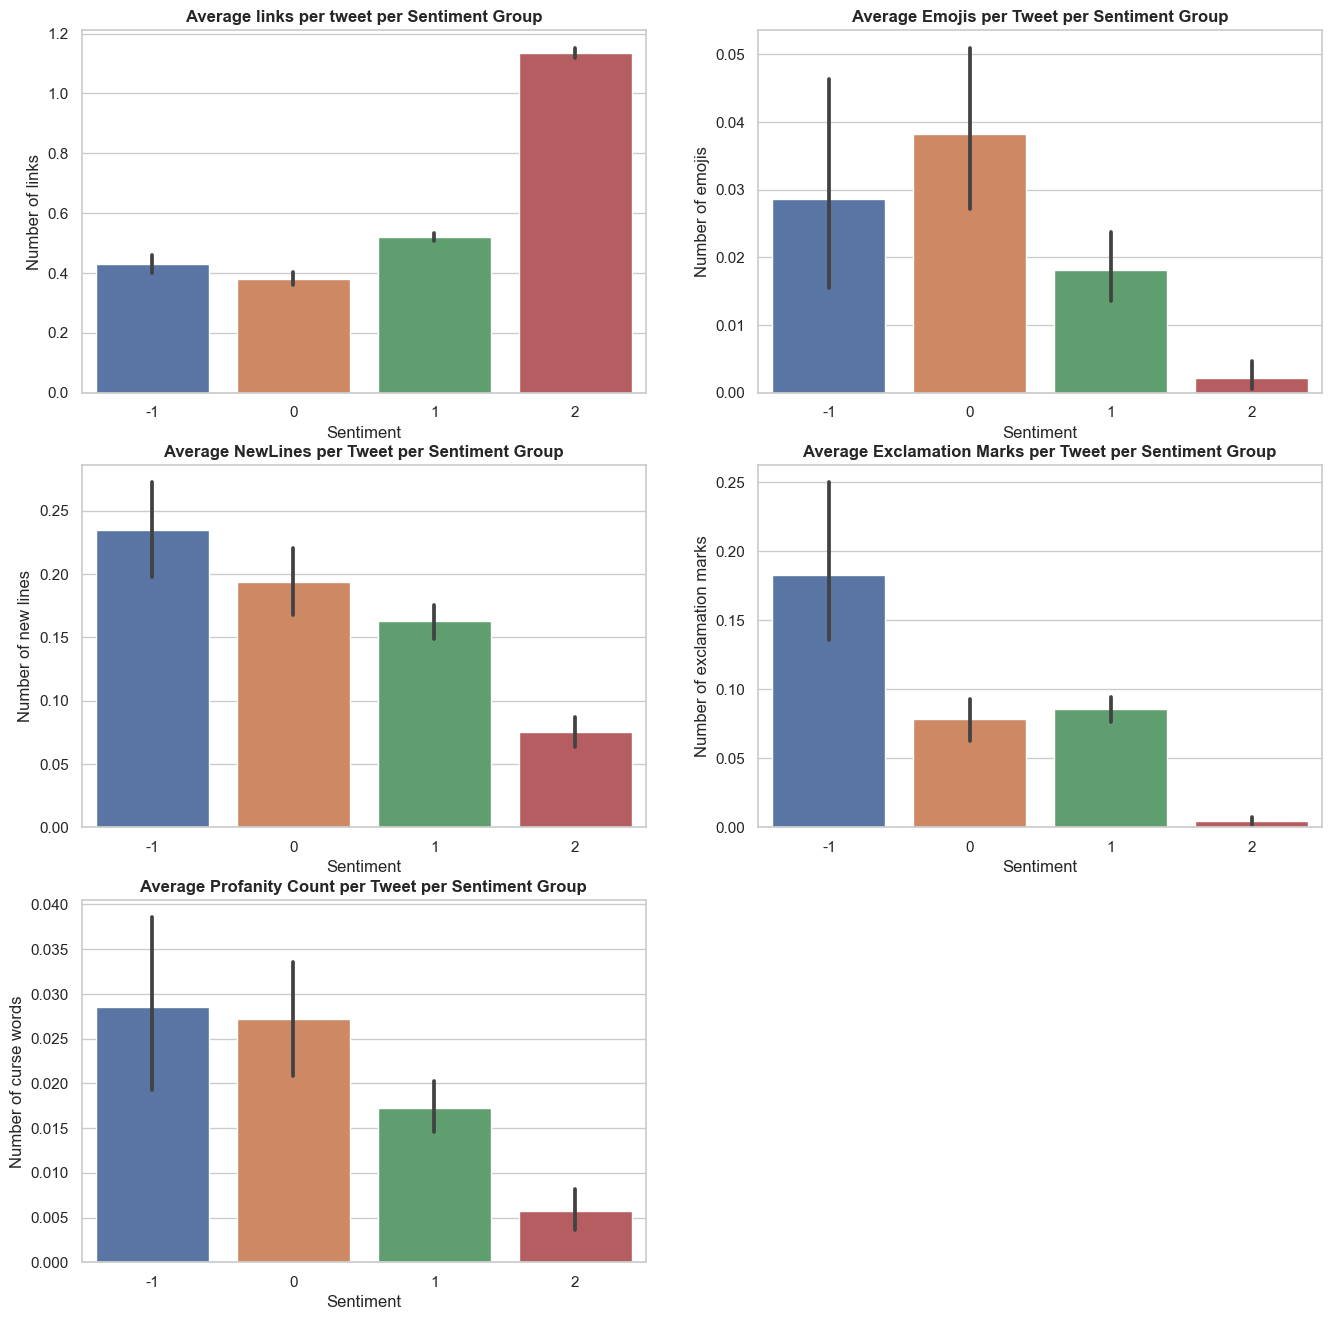

In [28]:
fig, axs = plt.subplots( 3, 2, figsize=(16,16))

# Plot link distribution
sns.barplot(ax = axs[0][0] , data=df_eda, x="sentiment", y="link_count")
axs[0][0].set_ylabel('Number of links')
axs[0][0].set_xlabel("Sentiment")
axs[0][0].set_title("Average links per tweet per Sentiment Group", fontweight = 'bold')

# Plot emoji distribution
sns.barplot(ax = axs[0][1] , data=df_eda, x="sentiment", y="emoji_count")
axs[0][1].set_ylabel('Number of emojis')
axs[0][1].set_xlabel("Sentiment")
axs[0][1].set_title("Average Emojis per Tweet per Sentiment Group", fontweight = 'bold')

# Plot newline distribution
sns.barplot(ax = axs[1][0] , data=df_eda, x="sentiment", y="newline_count")
axs[1][0].set_ylabel('Number of new lines')
axs[1][0].set_xlabel("Sentiment")
axs[1][0].set_title("Average NewLines per Tweet per Sentiment Group", fontweight = 'bold')

# Plot exclamation mark distribution
sns.barplot(ax = axs[1][1] , data=df_eda, x="sentiment", y="exclamation_count")
axs[1][1].set_ylabel('Number of exclamation marks')
axs[1][1].set_xlabel("Sentiment")
axs[1][1].set_title("Average Exclamation Marks per Tweet per Sentiment Group", fontweight = 'bold')


# Plot profanity distribution
sns.barplot(ax = axs[2][0] , data=df_eda, x="sentiment", y="profanity_count")
axs[2][0].set_ylabel('Number of curse words')
axs[2][0].set_xlabel("Sentiment")
axs[2][0].set_title("Average Profanity Count per Tweet per Sentiment Group", fontweight = 'bold')

axs[2][1].set_axis_off()

The image above contains a lot of information about our data. Let's break it down by feature.

First, we consider the average amount of links per tweet. We see that tweets containing factual news about climate change in our dataset contains a lot more links on average than any other category in the data. Within the other categories, not much variation exist when considering this feature. This feature might help us to predict factual news tweets, and as such, should be used when building our models.

Next, we look at the amount of emojis per tweet. We see that factual news tweets contains very little emojis, while people with neutral sentiments use the most. The amount of emojis in our data is very little, however, and does not contribute to the vast majority of data. As such, we might neglect the `emoji_count` feature, and instead translate the emojis to text, which will be used by the model. 

Considering the amount of new paragraphs (or newlines) in the data, we find that people expressing anti-climate change sentiments use the newline character the most to space out their tweets, whilst the factual news tweets contains the least amount of average newlines for any sentiment group. This feature seems to contribute to the amount of information contained within the data, and should therefore be used when training our models.

A surprising feature that emerged, is that of the average amount of exclamation marks per tweet. People expressing anti-climate change sentiments use this character more that twice the amount of those possessing neutral and pro-climate change sentiments. Futhermore, factual news tweets almost never contain exclamation marks. This is an excellent feature to include when training our models

Lastly, we consider the profanity contained within tweets. As expected, factual news tweets contained the least amount of average profanity per tweet form any group. People maintaining anti-climate change views uses the most of any group, followed closely by people that are neutral to th issue of climate-change. Again, as was the case for emojis, the amount of profanity in the data is very low, and as such, we can neglect the `profanity_count` feature when training our models.


For our last consideration within the EDA, let's look at the most common words found within the dataset. First, we need to clean the data to remove some things from consideration. We start by converting all of the words to lowercase so that capitalization no longer differentiates between words:

In [29]:
# Transform tweets into lowercase versions of tweets:
def lowercase(tweet):
    return tweet.lower()
df_eda["message"] = df_eda['message'].apply(lowercase)

Next, we replace all URLs within the data with a common alias:

In [30]:
# Replace URLs within the dataframe
pattern_url = r'http[s]?://(?:[A-Za-z]|[0-9]|[$-_@.&+]|[!*\(\),]|(?:%[0-9A-Fa-f][0-9A-Fa-f]))+'
subs_url = r'url-web'
df_eda['message'] = df_eda['message'].replace(to_replace = pattern_url, value = subs_url, regex = True)




Since we have already looked at retweets, mentions and hashtags, we remove them from consideration for now:

In [31]:
# Remove handles from tweet:
def remove_handles(tweet):
    wordlist = tweet.split()
    for word in wordlist:
        if word[0] == '@':
            wordlist.remove(word)
    returnstr = ''
    for word in wordlist:
        returnstr += word + " "
    return returnstr

# Remove handles from tweet:
def remove_hashtags(tweet):
    wordlist = tweet.split()
    for word in wordlist:
        if word[0] == '#':
            wordlist.remove(word)
    returnstr = ''
    for word in wordlist:
        returnstr += word + " "
    return returnstr

# Remove RT from tweet:
def remove_rt(tweet):
    wordlist = tweet.split()
    for word in wordlist:
        if word == 'rt' or word=='RT':
            wordlist.remove(word)
    returnstr = ''
    for word in wordlist:
        returnstr += word + " "
    return returnstr

Applying these functions to our dataset:

In [32]:
# Remove hashtags, handles and retweets form the data
df_eda["message"] = df_eda['message'].apply(remove_handles)
df_eda["message"] = df_eda['message'].apply(remove_hashtags)
df_eda["message"] = df_eda['message'].apply(remove_rt)

Next, we remove all common stopwords form the data, as they will not provide meaningful insights:

In [33]:
# Remove common english stop words from the data
def remove_stop_words(tweet):
    words = tweet.split()     
    return ' '.join([t for t in words if t not in stopwords.words('english')])

# Apply function to the data:
df_eda["message"] = df_eda['message'].apply(remove_stop_words)

Lastly, we remove all punctuation from the tweets, so that we are left with only words:

In [34]:
# Showing the punctuation to be removed
string.punctuation

'!"#$%&\'()*+,-./:;<=>?@[\\]^_`{|}~'

In [35]:
# Remove punctuation from tweets:
def remove_punctuation(tweet):
    return ''.join([l for l in tweet if l not in string.punctuation])

# Apply function to data
df_eda["message"] = df_eda['message'].apply(remove_punctuation)

Writing a function to count the amount of words present within the data:

In [36]:
def bag_of_words_count(words, word_dict={}):
    """ this function takes in a list of words and returns a dictionary 
        with each word as a key, and the value represents the number of 
        times that word appeared"""
    for word in words:
        if word in word_dict.keys():
            word_dict[word] += 1
        else:
            word_dict[word] = 1
    return word_dict

We can apply that to the data. First, let's look at the most common words over the whole dataset:

In [37]:
# Join all tweets within one string variable
all_tweets = " ".join(df_eda["message"])

# Split tweets into list of words
word_list = all_tweets.split()

# Count words in dataset
word_count = {}
bag_of_words_count(word_list, word_count)

# Sort dictionary on word count
word_count = sorted(word_count.items(), key=lambda x:x[1], reverse=True)

print(word_count[0:20])


[('climate', 12555), ('change', 12211), ('urlweb', 8028), ('global', 3761), ('warming', 3413), ('trump', 1864), ('believe', 1154), ('urlweb…', 1027), ('us', 891), ('amp', 872), ('real', 682), ('going', 670), ('world', 634), ('people', 600), ('urlwebã¢â‚¬â¦', 588), ('new', 538), ('via', 515), ('epa', 514), ('fight', 468), ('says', 429)]


Let's plot the 20 most occurring words:

<Axes: title={'center': 'Count of most occurring words'}, ylabel='Word'>

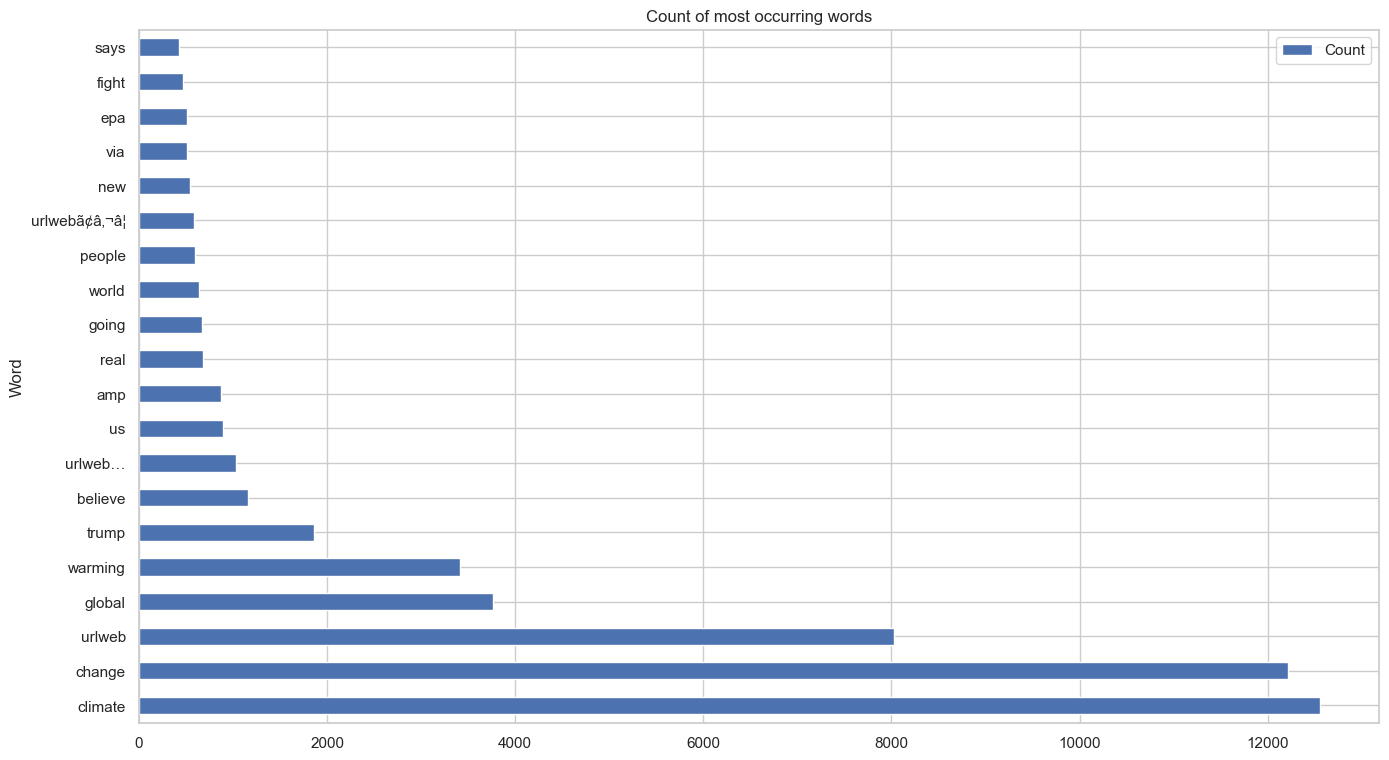

In [38]:
# Put word counts into dataframe
df_wordcount = pd.DataFrame(word_count, columns=["Word", "Count"])

# Select 20 most occurring words
df_to_plot = df_wordcount.head(20)

df_to_plot.plot(x="Word", kind='barh', title="Count of most occurring words", figsize=(16,9) )

From the above, we nota a few things: 

Most obviously, the most occuring word in the dataset is `climate`, followed closely by `change`. We see that other keywords such as `global` and `warming` also occurs very often, as does `trump`. 

Furthermore, we have a lot of links within the data. We see that we can improve on cleaning these links, since we see 3 categories of counts that all pertain to links posted. When training the model, we should attempt to remove more of the strange characters surrounding words


Let's repeat the process above, but break down the most used words within each category:

In [39]:
# Splitting the data into each category after cleaning:
df_eda_anti = df_eda[df_eda["sentiment"] ==  -1]
df_eda_neutral = df_eda[df_eda["sentiment"] ==  0]
df_eda_pro = df_eda[df_eda["sentiment"] ==  1]
df_eda_news = df_eda[df_eda["sentiment"] ==  2]

# Join all tweets within one string variable
all_tweets_anti = " ".join(df_eda_anti["message"])
all_tweets_neutral = " ".join(df_eda_neutral["message"])
all_tweets_pro = " ".join(df_eda_pro["message"])
all_tweets_news = " ".join(df_eda_news["message"])

# Split tweets into list of words
word_list_anti = all_tweets_anti.split()
word_list_neutral = all_tweets_neutral.split()
word_list_pro = all_tweets_pro.split()
word_list_news = all_tweets_news.split()

# Count words in each dataset
word_count_anti = {}
bag_of_words_count(word_list_anti, word_count_anti)
word_count_neutral = {}
bag_of_words_count(word_list_neutral, word_count_neutral)
word_count_pro = {}
bag_of_words_count(word_list_pro, word_count_pro)
word_count_news = {}
bag_of_words_count(word_list_news, word_count_news)

# Sorting the dictionaries on word count
word_count_anti = sorted(word_count_anti.items(), key=lambda x:x[1], reverse=True)
word_count_neutral = sorted(word_count_neutral.items(), key=lambda x:x[1], reverse=True)
word_count_pro = sorted(word_count_pro.items(), key=lambda x:x[1], reverse=True)
word_count_news = sorted(word_count_news.items(), key=lambda x:x[1], reverse=True)

# Showing the most common words for each category:
print("Anti:\n", word_count_anti[0:20], "/n /n")
print("Neutral:\n", word_count_neutral[0:20], "/n /n")
print("Pro:\n", word_count_pro[0:20], "/n /n")
print("News:\n", word_count_news[0:20], "/n /n")


Anti:
 [('climate', 777), ('change', 735), ('global', 632), ('warming', 597), ('urlweb', 459), ('amp', 83), ('science', 73), ('urlweb…', 65), ('real', 63), ('us', 62), ('people', 56), ('trump', 53), ('man', 53), ('would', 50), ('scam', 49), ('hoax', 48), ('manmade', 47), ('made', 47), ('data', 45), ('believe', 45)] /n /n
Neutral:
 [('climate', 1419), ('change', 1370), ('global', 1033), ('warming', 981), ('urlweb', 754), ('trump', 141), ('us', 101), ('amp', 100), ('real', 98), ('like', 96), ('believe', 87), ('penguin', 84), ('think', 81), ('im', 81), ('hes', 77), ('urlweb…', 68), ('people', 65), ('cause', 55), ('hot', 52), ('know', 52)] /n /n
Pro:
 [('climate', 7163), ('change', 6967), ('urlweb', 3188), ('global', 1594), ('warming', 1410), ('believe', 1001), ('trump', 860), ('amp', 654), ('going', 590), ('urlweb…', 517), ('real', 487), ('urlwebã¢â‚¬â¦', 483), ('people', 453), ('world', 443), ('us', 437), ('die', 394), ('thinking', 337), ('husband', 312), ('fight', 283), ('new', 282)] /n

Since all categories share the same 5 words as being used the most, we remove them from consideration in order to obtain some differences between classes to help differentiate between them:

In [40]:
# Specify high-frequency words found in all classes:
words_to_remove = ["climate", "change", "global", "warming", "urlweb"]

# Put word counts into dataframe
df_wordcount_anti = pd.DataFrame(word_count_anti, columns=["Word", "Count"])
df_wordcount_neutral = pd.DataFrame(word_count_neutral, columns=["Word", "Count"])
df_wordcount_pro = pd.DataFrame(word_count_pro, columns=["Word", "Count"])
df_wordcount_news = pd.DataFrame(word_count_news, columns=["Word", "Count"])


# Removing words from the dataframes
for word in words_to_remove:
    df_wordcount_anti.drop(df_wordcount_anti[df_wordcount_anti['Word'] == word].index, inplace = True)
    df_wordcount_neutral.drop(df_wordcount_neutral[df_wordcount_neutral['Word'] == word].index, inplace = True)
    df_wordcount_pro.drop(df_wordcount_pro[df_wordcount_pro['Word'] == word].index, inplace = True)
    df_wordcount_news.drop(df_wordcount_news[df_wordcount_news['Word'] == word].index, inplace = True)
    

Plotting the differences between used words per category:

<Axes: title={'center': 'Count of most occurring words in news tweets'}, ylabel='Word'>

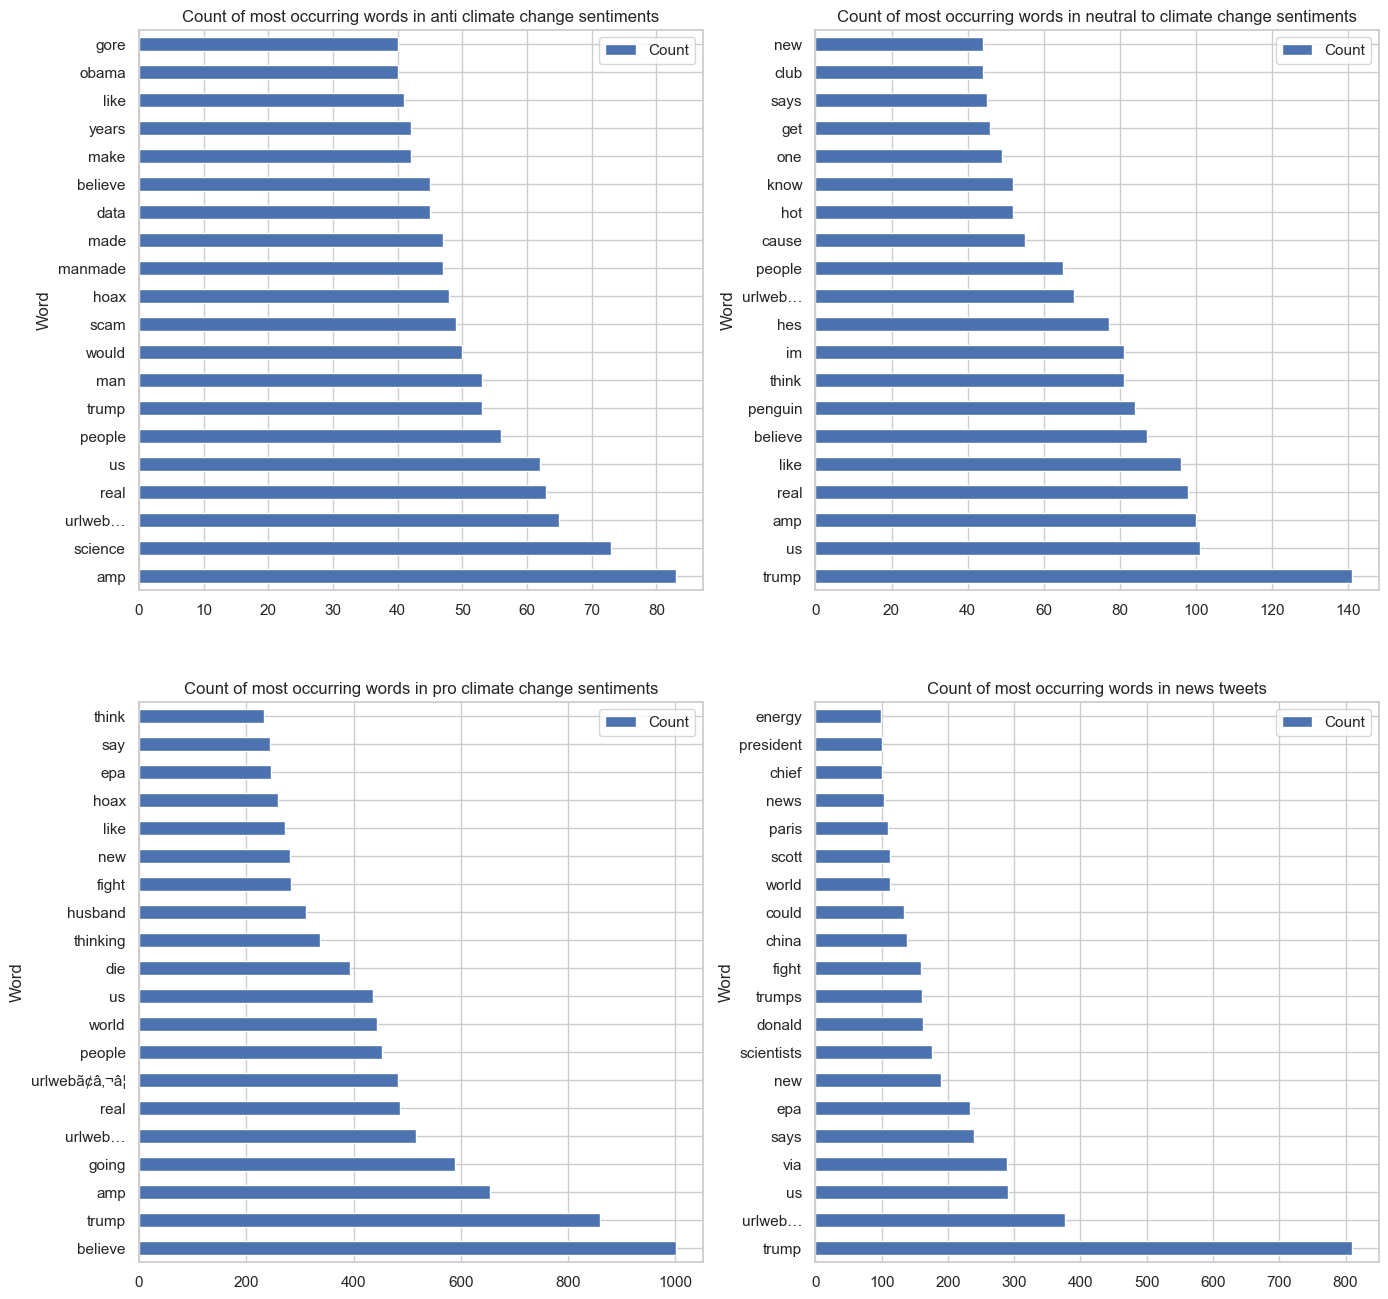

In [41]:


# Select 20 most occurring words
df_to_plot_anti = df_wordcount_anti.head(20)
df_to_plot_neutral = df_wordcount_neutral.head(20)
df_to_plot_pro = df_wordcount_pro.head(20)
df_to_plot_news = df_wordcount_news.head(20)

# Create subplots:
fig, axs = plt.subplots(2,2, figsize=(16,16))

# Plotting the wordcounts:
df_to_plot_anti.plot(x="Word", kind='barh', title="Count of most occurring words in anti climate change sentiments", ax=axs[0][0] )
df_to_plot_neutral.plot(x="Word", kind='barh', title="Count of most occurring words in neutral to climate change sentiments", ax=axs[0][1] )
df_to_plot_pro.plot(x="Word", kind='barh', title="Count of most occurring words in pro climate change sentiments", ax=axs[1][0] )
df_to_plot_news.plot(x="Word", kind='barh', title="Count of most occurring words in news tweets", ax=axs[1][1] )

We see that other commonly used words for `Anti climate change sentiments` includes features like *manmade*, *hoax* and *scam*. `Pro climate change sentiments` also use *hoax* a lot, but other words like *fight*, *die*, *world* and *epa* is much more common within this category. `Neutral sentiments` does'nt contain any charged words to identify them, although they talk a surprising amount about *penguins*. `News tweets` contains more instances of the word *news*, but rather little else to help distinction between other categories. 

All categories include high frequency use of the word *trump*, and we could consider removing that from the training data as it will only introduce noise to our models



Let's investigate what words appear in the data only once:

In [42]:
# Amount of rare words
rare_words = df_wordcount[df_wordcount["Count"] == 1]
print(len(rare_words), " words appear only once in our data, which is ", round(len(rare_words)/len(word_count)*100, 2), "% of all words in the dataset")

# Print 20 examples of rare words
print(list(rare_words["Word"])[:20])

10842  words appear only once in our data, which is  56.97 % of all words in the dataset
['polyscimajor', 'lung', 'activistã¢â‚¬â¦', '8yo', 'nephew', 'inconsolable', 'perish', 'fiery', 'hellscape', 'offense…', 'like…', 'warming………', 'vocal', 'powering', '‘misled’', '����️��', 'zaynmalik', 'healthcare…', 'reunitingish', 'cast']


Since these words constitutes a majority of our dataset, we should consider carefully if we keep them when training our models. By translating emojis and cleaning the data better, as well as applying stemming- or lemmatization techniques, we might be able to extract more valuable information from them.

<a id="four"></a>
## 4. Data Engineering and NLP Preprocessing
<a class="anchor" id="1.1"></a>
<a href=#cont>Back to Table of Contents</a>



To capture all the preprocessing happening within the data, we start a comet experiment:

In [43]:
if COMET_FLAG:
  # Start comet experiment:
  experiment = Experiment(
  api_key="iI4wg734rkuRFaqwXKZNNY2WW",
  project_name="nm-1-coders",
  workspace="thato-rabodiba"
)

  experiment.add_tag("Data Preprocessing")
  experiment.set_name("Data Preprocessing")

We first begin by reloading the data and discarding the changes made during the EDA section:

In [44]:
# Discard all changes and reload the data
df_train = pd.read_csv('train.csv')
df_evaluate = pd.read_csv('test_with_no_labels.csv')


On order  to avoid duplicating the operations performed on both the testing and training dataset, we join them together:

In [45]:

# Combine the training and testing data
df_combined = pd.concat((df_train, df_evaluate)) 


Next, let's extract the valuable features we identified:

In [46]:
# Get retweet status and handle
df_combined["is_retweet"] = df_combined["message"].apply(is_retweet, 1)
df_combined["retweet_handle"] =  df_combined["message"].apply(get_retweet, 1)

# Get hashtag count and extract hashtags
df_combined["hashtag_count"] = df_combined["message"].apply(count_hashtag, 1)
df_combined["hashtags"] =  df_combined["message"].apply(get_hashtag, 1)

# Get mention count and extract mentions
df_combined["mention_count"] = df_combined["message"].apply(count_mentions, 1)
df_combined["mentions"] =  df_combined["message"].apply(get_mentions, 1)

# Get number of links
df_combined["link_count"] = df_combined["message"].apply(count_links, 1)

# Get number of newlines
df_combined["newline_count"] = df_combined["message"].apply(enter_count, 1)

# Get number of exclamation marks
df_combined["exclamation_count"] =  df_combined["message"].apply(exclamation_count, 1)

df_combined.head()


sentiment                                            message  tweetid  \
0        1.0  PolySciMajor EPA chief doesn't think carbon di...   625221   
1        1.0  It's not like we lack evidence of anthropogeni...   126103   
2        2.0  RT @RawStory: Researchers say we have three ye...   698562   
3        1.0  #TodayinMaker# WIRED : 2016 was a pivotal year...   573736   
4        1.0  RT @SoyNovioDeTodas: It's 2016, and a racist, ...   466954   

   is_retweet    retweet_handle  hashtag_count         hashtags  \
0           0                                0                    
1           0                                0                    
2           1         @RawStory              0                    
3           0                                1   #TodayinMaker#   
4           1  @SoyNovioDeTodas              1   #ElectionNight   

   mention_count    mentions  link_count  newline_count  exclamation_count  
0              1   @mashable           1              0                  1  
1              0                       0              0                  0  
2              0                       2              0                  0  
3              0                       1              0                  0  
4              0                       0              0                  0

The next step, is to clean the message contained within the tweet. First, let's remove the retweet and mention handles, as well as the hashtags, since we have extracted that information already into their own features:

In [47]:
# Remove handles from tweet
df_combined["message"] = df_combined['message'].apply(remove_handles)
# Remove hashtags from tweet
df_combined["message"] = df_combined['message'].apply(remove_hashtags)
# Remove RT from tweet
df_combined["message"] = df_combined['message'].apply(remove_rt)

df_combined.head()

sentiment                                            message  tweetid  \
0        1.0  PolySciMajor EPA chief doesn't think carbon di...   625221   
1        1.0  It's not like we lack evidence of anthropogeni...   126103   
2        2.0  Researchers say we have three years to act on ...   698562   
3        1.0  WIRED : 2016 was a pivotal year in the war on ...   573736   
4        1.0  It's 2016, and a racist, sexist, climate chang...   466954   

   is_retweet    retweet_handle  hashtag_count         hashtags  \
0           0                                0                    
1           0                                0                    
2           1         @RawStory              0                    
3           0                                1   #TodayinMaker#   
4           1  @SoyNovioDeTodas              1   #ElectionNight   

   mention_count    mentions  link_count  newline_count  exclamation_count  
0              1   @mashable           1              0                  1  
1              0                       0              0                  0  
2              0                       2              0                  0  
3              0                       1              0                  0  
4              0                       0              0                  0

Next, we avoid duplicating words if they contain capitalization, by converting all characters in the tweet to lowercase:

In [48]:
# Convert tweet message to lowercase
df_combined["message"] = df_combined['message'].apply(lowercase)
df_combined.head()

sentiment                                            message  tweetid  \
0        1.0  polyscimajor epa chief doesn't think carbon di...   625221   
1        1.0  it's not like we lack evidence of anthropogeni...   126103   
2        2.0  researchers say we have three years to act on ...   698562   
3        1.0  wired : 2016 was a pivotal year in the war on ...   573736   
4        1.0  it's 2016, and a racist, sexist, climate chang...   466954   

   is_retweet    retweet_handle  hashtag_count         hashtags  \
0           0                                0                    
1           0                                0                    
2           1         @RawStory              0                    
3           0                                1   #TodayinMaker#   
4           1  @SoyNovioDeTodas              1   #ElectionNight   

   mention_count    mentions  link_count  newline_count  exclamation_count  
0              1   @mashable           1              0                  1  
1              0                       0              0                  0  
2              0                       2              0                  0  
3              0                       1              0                  0  
4              0                       0              0                  0

Next, we replace all contraction words with their constituent words (_eg: it's becomes it is_):

In [49]:
# Write function to replace contractions:
def fix_contractions(tweet):
    expanded_words = []
    for word in tweet.split():
        expanded_words.append(contractions.fix(word))
    
    returnstr = " ".join(expanded_words)
    return returnstr

# Apply function to tweet message:
df_combined["message"] = df_combined['message'].apply(fix_contractions)
df_combined.head()

sentiment                                            message  tweetid  \
0        1.0  polyscimajor epa chief does not think carbon d...   625221   
1        1.0  it is not like we lack evidence of anthropogen...   126103   
2        2.0  researchers say we have three years to act on ...   698562   
3        1.0  wired : 2016 was a pivotal year in the war on ...   573736   
4        1.0  it is 2016, and a racist, sexist, climate chan...   466954   

   is_retweet    retweet_handle  hashtag_count         hashtags  \
0           0                                0                    
1           0                                0                    
2           1         @RawStory              0                    
3           0                                1   #TodayinMaker#   
4           1  @SoyNovioDeTodas              1   #ElectionNight   

   mention_count    mentions  link_count  newline_count  exclamation_count  
0              1   @mashable           1              0                  1  
1              0                       0              0                  0  
2              0                       2              0                  0  
3              0                       1              0                  0  
4              0                       0              0                  0

Next, let's replace the URL links in our data with a alias in order to standardize them:

In [50]:
# Substitutes all URL links with url-web
pattern_url = r'http[s]?://(?:[A-Za-z]|[0-9]|[$-_@.&+]|[!*\(\),]|(?:%[0-9A-Fa-f][0-9A-Fa-f]))+'
subs_url = r'url-web'
df_combined['message'] = df_combined['message'].replace(to_replace = pattern_url, value = subs_url, regex = True)

Next, let's convert the emojis and emoticons present in our data to text: 

In [51]:
# Function to translate emojis and emoticons:
def fix_emojis(tweet):
    newtweet = emoji.demojize(tweet) # Translates 👍 emoji into a form like :thumbs_up: for example
    newtweet = newtweet.replace("_", " ") # Beneficial to split emoji text into multiple words
    newtweet = newtweet.replace(":", " ") # Separate emoji from rest of the words
    returntweet = newtweet.lower() # Make sure no capitalization sneaks in
    return returntweet

# Apply function to tweet message:
df_combined["message"] = df_combined['message'].apply(fix_emojis)

df_combined.head()       

sentiment                                            message  tweetid  \
0        1.0  polyscimajor epa chief does not think carbon d...   625221   
1        1.0  it is not like we lack evidence of anthropogen...   126103   
2        2.0  researchers say we have three years to act on ...   698562   
3        1.0  wired   2016 was a pivotal year in the war on ...   573736   
4        1.0  it is 2016, and a racist, sexist, climate chan...   466954   

   is_retweet    retweet_handle  hashtag_count         hashtags  \
0           0                                0                    
1           0                                0                    
2           1         @RawStory              0                    
3           0                                1   #TodayinMaker#   
4           1  @SoyNovioDeTodas              1   #ElectionNight   

   mention_count    mentions  link_count  newline_count  exclamation_count  
0              1   @mashable           1              0                  1  
1              0                       0              0                  0  
2              0                       2              0                  0  
3              0                       1              0                  0  
4              0                       0              0                  0

Next, we remove common english stop words:

In [52]:
# Remove stop words from data
df_combined["message"] = df_combined['message'].apply(remove_stop_words)
df_combined.head()

sentiment                                            message  tweetid  \
0        1.0  polyscimajor epa chief think carbon dioxide ma...   625221   
1        1.0    like lack evidence anthropogenic global warming   126103   
2        2.0  researchers say three years act climate change...   698562   
3        1.0  wired 2016 pivotal year war climate change url...   573736   
4        1.0  2016, racist, sexist, climate change denying b...   466954   

   is_retweet    retweet_handle  hashtag_count         hashtags  \
0           0                                0                    
1           0                                0                    
2           1         @RawStory              0                    
3           0                                1   #TodayinMaker#   
4           1  @SoyNovioDeTodas              1   #ElectionNight   

   mention_count    mentions  link_count  newline_count  exclamation_count  
0              1   @mashable           1              0                  1  
1              0                       0              0                  0  
2              0                       2              0                  0  
3              0                       1              0                  0  
4              0                       0              0                  0

If needed, we can also remove words occurring very frequently in each sentiment category:

In [53]:
# Function to remove overused words occurring in each category
def remove_overused_words(tweet):
    words_to_remove = ["climate", "change", "global", "warming", "trump"] # Used frequently through dataset, regardless of category: Unhelpful in identifying sentiment
    words = tweet.split()     
    return ' '.join([t for t in words if t not in words_to_remove])

# Applying the function if flag is raised
if REMOVE_OVERUSED_WORDS:
    df_combined["message"] = df_combined['message'].apply(remove_overused_words)

We can also remove the strange characters in the data present as a result of encoding issues:

In [54]:
# Replace strange characters in data with closest ascii equivalent
def clean_tweet(tweet):
    # Normalize the tweet to remove diacritics and other special characters
    normalized_tweet = unicodedata.normalize('NFKD', tweet)
    
    # Remove or replace any remaining unwanted characters
    cleaned_tweet = normalized_tweet.encode('ascii', 'ignore').decode('utf-8')
    
    return cleaned_tweet.lower()

df_combined["message"] =df_combined['message'].apply(clean_tweet)

Let's remove the remaining punctuation:

In [55]:
# Remove remaining punctuation
df_combined["message"] =df_combined['message'].apply(remove_punctuation)


df_combined.head()

sentiment                                            message  tweetid  \
0        1.0  polyscimajor epa chief think carbon dioxide ma...   625221   
1        1.0    like lack evidence anthropogenic global warming   126103   
2        2.0  researchers say three years act climate change...   698562   
3        1.0  wired 2016 pivotal year war climate change urlweb   573736   
4        1.0  2016 racist sexist climate change denying bigo...   466954   

   is_retweet    retweet_handle  hashtag_count         hashtags  \
0           0                                0                    
1           0                                0                    
2           1         @RawStory              0                    
3           0                                1   #TodayinMaker#   
4           1  @SoyNovioDeTodas              1   #ElectionNight   

   mention_count    mentions  link_count  newline_count  exclamation_count  
0              1   @mashable           1              0                  1  
1              0                       0              0                  0  
2              0                       2              0                  0  
3              0                       1              0                  0  
4              0                       0              0                  0

Let's also get rid of all numbers in the dataset, since they would contribute little to classifying the tweets:

In [56]:
# Function to remove numbers from tweet
def remove_numbers(tweet):
    new_string = re.sub(r'[0-9]', '', tweet)
    return new_string

# Apply the function to the data
df_combined["message"] =df_combined['message'].apply(remove_numbers)

Next, let's lemmatize all of the words in contained in the message of the tweet. By doing so, we can group together word with similar meaning in order to help our model identify trends within the data 

In [57]:
# Create a lemmatizer object
lemmatizer = WordNetLemmatizer()

# Create function to lemmatize tweet content
def tweet_lemma(tweet, lemmatizer):
    list_of_lemmas = [lemmatizer.lemmatize(word) for word in tweet.split()] 
    return " ".join(list_of_lemmas) 

df_combined["message"] = df_combined["message"].apply(tweet_lemma, args=(lemmatizer, ))

df_combined.head()

sentiment                                            message  tweetid  \
0        1.0  polyscimajor epa chief think carbon dioxide ma...   625221   
1        1.0    like lack evidence anthropogenic global warming   126103   
2        2.0  researcher say three year act climate change l...   698562   
3        1.0       wired pivotal year war climate change urlweb   573736   
4        1.0  racist sexist climate change denying bigot lea...   466954   

   is_retweet    retweet_handle  hashtag_count         hashtags  \
0           0                                0                    
1           0                                0                    
2           1         @RawStory              0                    
3           0                                1   #TodayinMaker#   
4           1  @SoyNovioDeTodas              1   #ElectionNight   

   mention_count    mentions  link_count  newline_count  exclamation_count  
0              1   @mashable           1              0                  1  
1              0                       0              0                  0  
2              0                       2              0                  0  
3              0                       1              0                  0  
4              0                       0              0                  0

We can improve our model performance and reduce training time by getting rid of words that only appears once in the dataset. These words won't help establish any connection between the tweet and the sentiment classes, since they appear only once, and no statistical significance can be drawn from them:

In [58]:
# Make dataframe of all word counts in the data
df_wordcounts = pd.DataFrame(df_combined['message'].str.split(expand=True).stack().value_counts())
df_wordcounts.reset_index(inplace=True)
df_wordcounts.rename(columns={"index": "word", 0:"count"}, inplace=True)

# Extract unique words from data
df_unique_words = df_wordcounts[df_wordcounts["count"]==1]
df_unique_words

# Investigate amount of unique words
print(len(df_unique_words), "out of", len(df_wordcounts), "words in our dataset appears only once, i.e.", str(round(len(df_unique_words)/len(df_wordcounts)*100, 2)) +"%", "of words used are unique")

# Make list of unique words
unique_wordlist = list(df_unique_words["word"])

# Function to remove unique words from data
def remove_unique_words(tweet):
    words = tweet.split()     
    return ' '.join([t for t in words if t not in unique_wordlist])

# Applying the function
df_combined["message"] =df_combined['message'].apply(remove_unique_words)

10836 out of 20072 words in our dataset appears only once, i.e. 53.99% of words used are unique


Now that our message is sufficiently clean, let's add our retweet handles, hashtags and mentions back into our text data, since they will be important to help distinguish between categories:

In [59]:
# Function to add retweets to message
def add_rt_handle(row):
    if row["retweet_handle"] == "":
        ret = row["message"]
    else:
        ret =  row["message"] + " rt_" + row["retweet_handle"]
    return ret
# Applying the function
df_combined["message"] = df_combined.apply(add_rt_handle, axis=1)

# Function to add retweets to message
def add_hashtag(row):
    if row["hashtags"] == "":
        ret = row["message"]
    else:
        ret =  row["message"] + " " + row["hashtags"]
    return ret
# Applying the function
df_combined["message"] = df_combined.apply(add_hashtag, axis=1)

# Function to add mentions to message
def add_rt_handle(row):
    if row["mentions"] == "":
        ret = row["message"]
    else:
        ret =  row["message"] + " " + row["mentions"]
    return ret
# Applying the function
df_combined["message"] = df_combined.apply(add_rt_handle, axis=1)



Dropping the redundant columns:

In [60]:
# Drop the specified columns
df_combined = df_combined.drop(["retweet_handle", "hashtags", "mentions"], axis=1)
df_combined.head()

sentiment                                            message  tweetid  \
0        1.0  epa chief think carbon dioxide main global war...   625221   
1        1.0    like lack evidence anthropogenic global warming   126103   
2        2.0  researcher say three year act climate change l...   698562   
3        1.0  wired pivotal year war climate change urlweb  ...   573736   
4        1.0  racist sexist climate change denying bigot lea...   466954   

   is_retweet  hashtag_count  mention_count  link_count  newline_count  \
0           0              0              1           1              0   
1           0              0              0           0              0   
2           1              0              0           2              0   
3           0              1              0           1              0   
4           1              1              0           0              0   

   exclamation_count  
0                  1  
1                  0  
2                  0  
3                  0  
4                  0

Finally, we can vectorise all the columns containing string data, i.e `message`, `retweet_handle`, `hashtags` and `mentions`. We will make use of the TfidfVectorizer module built into sklearn:

In [68]:
# Initialize and fit specified Vectorizer
if VECTORIZER_TO_USE == "tfidf":

    # Initialize Vectorizer
    tfid = TfidfVectorizer(ngram_range=(1,2) , max_features=MAX_TEXT_FEATURES, min_df=VEC_MIN_WORD_TO_REMOVE) # Change max features to include more data

    # Fit vectoriser on message data:
    vec_message = tfid.fit_transform(df_combined["message"])

    # Choose a filename to save the vectorizer as
    vec_save_path = './Models/TFIDF_Vec.pkl'

    
elif VECTORIZER_TO_USE == "count":

    # Initialize Vectorizer
    count_vec = CountVectorizer(ngram_range=(1,2) , max_features=MAX_TEXT_FEATURES, min_df=VEC_MIN_WORD_TO_REMOVE) # Change max features to include more data

    # Fit vectoriser on message data:
    vec_message = count_vec.fit_transform(df_combined["message"])

    # Choose a filename to save vec as
    vec_save_path = './Models/Count_vec.pkl'

    # Save vec to specified filename
    with open(vec_save_path, 'wb') as file:
        pickle.dump(count_vec, file)

Converting our vectorized message to a dataframe to add to the other features:

In [69]:
# Converting vectorized message into sparse dataframe
if VECTORIZER_TO_USE == "tfidf":
    sparse_vec_msg_df = pd.DataFrame.sparse.from_spmatrix(vec_message, columns = tfid.get_feature_names_out())
elif VECTORIZER_TO_USE == "count":
    sparse_vec_msg_df = pd.DataFrame.sparse.from_spmatrix(vec_message, columns = count_vec.get_feature_names_out())
sparse_vec_msg_df.head()

100days  100days keepparis  100isnow  100percfedup  1010   1a  \
0      0.0                0.0       0.0           0.0   0.0  0.0   
1      0.0                0.0       0.0           0.0   0.0  0.0   
2      0.0                0.0       0.0           0.0   0.0  0.0   
3      0.0                0.0       0.0           0.0   0.0  0.0   
4      0.0                0.0       0.0           0.0   0.0  0.0   

   1followernodad  1o5c  1o5cleanenergy  1starfleetcadet  ...  zrastall17  \
0             0.0   0.0             0.0              0.0  ...         0.0   
1             0.0   0.0             0.0              0.0  ...         0.0   
2             0.0   0.0             0.0              0.0  ...         0.0   
3             0.0   0.0             0.0              0.0  ...         0.0   
4             0.0   0.0             0.0              0.0  ...         0.0   

   zsstevens  ztsamudzi  zwash300  zwash300 foxnews  zxkia  zzzzaaaacccchhh  \
0        0.0        0.0       0.0               0.0    0.0              0.0   
1        0.0        0.0       0.0               0.0    0.0              0.0   
2        0.0        0.0       0.0               0.0    0.0              0.0   
3        0.0        0.0       0.0               0.0    0.0              0.0   
4        0.0        0.0       0.0               0.0    0.0              0.0   

    उत  उत तम_आह  तम_आह  
0  0.0       0.0    0.0  
1  0.0       0.0    0.0  
2  0.0       0.0    0.0  
3  0.0       0.0    0.0  
4  0.0       0.0    0.0  

[5 rows x 50000 columns]

Let' concatenate the numerical features with the newly preprocessed and vectorized text feature:

In [70]:
# Adding the dataframes together
df_vectorized_combined = pd.concat([df_combined.reset_index(drop=True), sparse_vec_msg_df.reset_index(drop=True)], axis=1)
df_vectorized_combined.head()

sentiment                                            message  tweetid  \
0        1.0  epa chief think carbon dioxide main global war...   625221   
1        1.0    like lack evidence anthropogenic global warming   126103   
2        2.0  researcher say three year act climate change l...   698562   
3        1.0  wired pivotal year war climate change urlweb  ...   573736   
4        1.0  racist sexist climate change denying bigot lea...   466954   

   is_retweet  hashtag_count  mention_count  link_count  newline_count  \
0           0              0              1           1              0   
1           0              0              0           0              0   
2           1              0              0           2              0   
3           0              1              0           1              0   
4           1              1              0           0              0   

   exclamation_count  100days  ...  zrastall17  zsstevens  ztsamudzi  \
0                  1      0.0  ...         0.0        0.0        0.0   
1                  0      0.0  ...         0.0        0.0        0.0   
2                  0      0.0  ...         0.0        0.0        0.0   
3                  0      0.0  ...         0.0        0.0        0.0   
4                  0      0.0  ...         0.0        0.0        0.0   

   zwash300  zwash300 foxnews  zxkia  zzzzaaaacccchhh   उत  उत तम_आह  तम_आह  
0       0.0               0.0    0.0              0.0  0.0       0.0    0.0  
1       0.0               0.0    0.0              0.0  0.0       0.0    0.0  
2       0.0               0.0    0.0              0.0  0.0       0.0    0.0  
3       0.0               0.0    0.0              0.0  0.0       0.0    0.0  
4       0.0               0.0    0.0              0.0  0.0       0.0    0.0  

[5 rows x 50009 columns]

Since the message column has successfully been encoded, we can drop it from consideration:

In [71]:
# Dropping the message column since it has been vectorized
df_vectorized_combined = df_vectorized_combined.drop("message", axis='columns')
df_vectorized_combined.head()

sentiment  tweetid  is_retweet  hashtag_count  mention_count  link_count  \
0        1.0   625221           0              0              1           1   
1        1.0   126103           0              0              0           0   
2        2.0   698562           1              0              0           2   
3        1.0   573736           0              1              0           1   
4        1.0   466954           1              1              0           0   

   newline_count  exclamation_count  100days  100days keepparis  ...  \
0              0                  1      0.0                0.0  ...   
1              0                  0      0.0                0.0  ...   
2              0                  0      0.0                0.0  ...   
3              0                  0      0.0                0.0  ...   
4              0                  0      0.0                0.0  ...   

   zrastall17  zsstevens  ztsamudzi  zwash300  zwash300 foxnews  zxkia  \
0         0.0        0.0        0.0       0.0               0.0    0.0   
1         0.0        0.0        0.0       0.0               0.0    0.0   
2         0.0        0.0        0.0       0.0               0.0    0.0   
3         0.0        0.0        0.0       0.0               0.0    0.0   
4         0.0        0.0        0.0       0.0               0.0    0.0   

   zzzzaaaacccchhh   उत  उत तम_आह  तम_आह  
0              0.0  0.0       0.0    0.0  
1              0.0  0.0       0.0    0.0  
2              0.0  0.0       0.0    0.0  
3              0.0  0.0       0.0    0.0  
4              0.0  0.0       0.0    0.0  

[5 rows x 50007 columns]

Let's move our target variable to the left most side of the dataframe for convenience:

In [72]:
# reindexing df so that our target variable is on the rightmost side:
df_vectorized_combined = df_vectorized_combined.reindex(columns = [col for col in df_vectorized_combined.columns if col != 'sentiment'] + ['sentiment'])
df_vectorized_combined.head()

tweetid  is_retweet  hashtag_count  mention_count  link_count  \
0   625221           0              0              1           1   
1   126103           0              0              0           0   
2   698562           1              0              0           2   
3   573736           0              1              0           1   
4   466954           1              1              0           0   

   newline_count  exclamation_count  100days  100days keepparis  100isnow  \
0              0                  1      0.0                0.0       0.0   
1              0                  0      0.0                0.0       0.0   
2              0                  0      0.0                0.0       0.0   
3              0                  0      0.0                0.0       0.0   
4              0                  0      0.0                0.0       0.0   

   ...  zsstevens  ztsamudzi  zwash300  zwash300 foxnews  zxkia  \
0  ...        0.0        0.0       0.0               0.0    0.0   
1  ...        0.0        0.0       0.0               0.0    0.0   
2  ...        0.0        0.0       0.0               0.0    0.0   
3  ...        0.0        0.0       0.0               0.0    0.0   
4  ...        0.0        0.0       0.0               0.0    0.0   

   zzzzaaaacccchhh   उत  उत तम_आह  तम_आह  sentiment  
0              0.0  0.0       0.0    0.0        1.0  
1              0.0  0.0       0.0    0.0        1.0  
2              0.0  0.0       0.0    0.0        2.0  
3              0.0  0.0       0.0    0.0        1.0  
4              0.0  0.0       0.0    0.0        1.0  

[5 rows x 50007 columns]

Let's split the data back into the respective training and evaluation datasets:

In [73]:
'''split data back into train and evaluation datasets: '''

# Extracting the response variables from the training dataset
y_train_dataset = df_vectorized_combined[:len(df_train)][['sentiment']]

# Separating predictor variables from response variable for the combined dataset
x_dataset = df_vectorized_combined[:len(df_vectorized_combined)].drop("sentiment", axis = "columns")

# Extracting predictor variables for the respective training and evaluation datasets 
x_train_dataset = df_vectorized_combined[:len(df_train)].drop('sentiment', axis='columns')
x_evaluate_dataset = df_vectorized_combined[len(df_train):].drop('sentiment', axis='columns')



The `tweet_id` column will not be used by the models, but will be necessary when we wish to evaluate our model performance in the competition, by using the *x_evaluate training set*. As such, let's save the `tweet_id`s in another dataframe for when we need to make a prediction submission, and drop the column from our training and evaluation datasets:

In [74]:
# Extract tweet id's that will be used when submitting predictions based on the evaluate dataset
df_tweetid_for_submission = pd.DataFrame(x_evaluate_dataset['tweetid'])
df_tweetid_for_submission

tweetid
15819   169760
15820    35326
15821   224985
15822   476263
15823   872928
...        ...
26360   895714
26361   875167
26362    78329
26363   867455
26364   470892

[10546 rows x 1 columns]

We can now safely drop this feature from consideration by our models:

In [75]:
# Remove tweet id form both testing and evaluation datasets
x_train_dataset = x_train_dataset.drop("tweetid", axis=1)
x_evaluate_dataset = x_evaluate_dataset.drop("tweetid", axis=1)

x_train_dataset.head()

is_retweet  hashtag_count  mention_count  link_count  newline_count  \
0           0              0              1           1              0   
1           0              0              0           0              0   
2           1              0              0           2              0   
3           0              1              0           1              0   
4           1              1              0           0              0   

   exclamation_count  100days  100days keepparis  100isnow  100percfedup  ...  \
0                  1      0.0                0.0       0.0           0.0  ...   
1                  0      0.0                0.0       0.0           0.0  ...   
2                  0      0.0                0.0       0.0           0.0  ...   
3                  0      0.0                0.0       0.0           0.0  ...   
4                  0      0.0                0.0       0.0           0.0  ...   

   zrastall17  zsstevens  ztsamudzi  zwash300  zwash300 foxnews  zxkia  \
0         0.0        0.0        0.0       0.0               0.0    0.0   
1         0.0        0.0        0.0       0.0               0.0    0.0   
2         0.0        0.0        0.0       0.0               0.0    0.0   
3         0.0        0.0        0.0       0.0               0.0    0.0   
4         0.0        0.0        0.0       0.0               0.0    0.0   

   zzzzaaaacccchhh   उत  उत तम_आह  तम_आह  
0              0.0  0.0       0.0    0.0  
1              0.0  0.0       0.0    0.0  
2              0.0  0.0       0.0    0.0  
3              0.0  0.0       0.0    0.0  
4              0.0  0.0       0.0    0.0  

[5 rows x 50005 columns]

Finally, we can split our overall training dataset into training and testing counterparts. The training subset will be used to train the model, while the testing subset will be used to test the preliminary model performance, and in doing so help with model optimization and hyperparameter tuning: 

In [76]:
# Splitting into our training and testing data subsets
X_train, X_test, y_train, y_test = train_test_split(x_train_dataset, y_train_dataset, test_size=TRAIN_TEST_SPLIT_VAR, random_state=RAND_STATE)

In [77]:
X_train

is_retweet  hashtag_count  mention_count  link_count  newline_count  \
6735            0              2              0           1              0   
13537           1              0              0           0              0   
6876            1              0              0           1              0   
10035           1              0              0           2              0   
5174            0              1              0           1              0   
...           ...            ...            ...         ...            ...   
13418           1              0              0           0              0   
5390            1              0              0           0              0   
860             1              1              1           0              0   
15795           0              0              0           1              0   
7270            1              0              0           2              0   

       exclamation_count  100days  100days keepparis  100isnow  100percfedup  \
6735                   0      0.0                0.0       0.0           0.0   
13537                  0      0.0                0.0       0.0           0.0   
6876                   0      0.0                0.0       0.0           0.0   
10035                  0      0.0                0.0       0.0           0.0   
5174                   1      0.0                0.0       0.0           0.0   
...                  ...      ...                ...       ...           ...   
13418                  0      0.0                0.0       0.0           0.0   
5390                   0      0.0                0.0       0.0           0.0   
860                    0      0.0                0.0       0.0           0.0   
15795                  0      0.0                0.0       0.0           0.0   
7270                   0      0.0                0.0       0.0           0.0   

       ...  zrastall17  zsstevens  ztsamudzi  zwash300  zwash300 foxnews  \
6735   ...         0.0        0.0        0.0       0.0               0.0   
13537  ...         0.0        0.0        0.0       0.0               0.0   
6876   ...         0.0        0.0        0.0       0.0               0.0   
10035  ...         0.0        0.0        0.0       0.0               0.0   
5174   ...         0.0        0.0        0.0       0.0               0.0   
...    ...         ...        ...        ...       ...               ...   
13418  ...         0.0        0.0        0.0       0.0               0.0   
5390   ...         0.0        0.0        0.0       0.0               0.0   
860    ...         0.0        0.0        0.0       0.0               0.0   
15795  ...         0.0        0.0        0.0       0.0               0.0   
7270   ...         0.0        0.0        0.0       0.0               0.0   

       zxkia  zzzzaaaacccchhh   उत  उत तम_आह  तम_आह  
6735     0.0              0.0  0.0       0.0    0.0  
13537    0.0              0.0  0.0       0.0    0.0  
6876     0.0              0.0  0.0       0.0    0.0  
10035    0.0              0.0  0.0       0.0    0.0  
5174     0.0              0.0  0.0       0.0    0.0  
...      ...              ...  ...       ...    ...  
13418    0.0              0.0  0.0       0.0    0.0  
5390     0.0              0.0  0.0       0.0    0.0  
860      0.0              0.0  0.0       0.0    0.0  
15795    0.0              0.0  0.0       0.0    0.0  
7270     0.0              0.0  0.0       0.0    0.0  

[12655 rows x 50005 columns]

If we choose to resample our data in order to deal with the class imbalance, we do that here:

In [78]:
# Function to upsample the minority classes and downsample the majority class:
def resample_training_data(df, entry_amount):
    # Split data into sentiment groups
    df_anti = df[df["sentiment"] == -1]
    df_neutral = df[df["sentiment"] == 0]
    df_pro = df[df["sentiment"] == 1]
    df_news = df[df["sentiment"] == 2]

    
  
    # Check if resample amount is valid, and adjust if need be:
    if entry_amount < len(df_anti):
        entry_amount = len(df_anti)
    elif entry_amount > len(df_pro):
        entry_amount = len(df_pro)

    # Resample Majority class
    df_pro_resamp = resample(df_pro,
                          replace=False, # sample without replacement (no need to duplicate observations)
                          n_samples=entry_amount, 
                          random_state=RAND_STATE)
    
    # Resample Minority class
    df_anti_resamp = resample(df_anti,
                          replace=True, # sample without replacement (we need to duplicate observations)
                          n_samples=entry_amount, 
                          random_state=RAND_STATE)
    
    # Test if upsample or downsample is needed for remaining classes
    if entry_amount > len(df_neutral): # Test if to upsample
        rep_neutral = True
    else:
        rep_neutral = False

    if entry_amount > len(df_news): # Test if to upsample
        rep_news = True
    else:
        rep_news = False

    # Resample Remaining classes
    df_neutral_resamp = resample(df_neutral,
                          replace=rep_neutral, 
                          n_samples=entry_amount, 
                          random_state=RAND_STATE)

    df_news_resamp = resample(df_news,
                          replace=rep_news, 
                          n_samples=entry_amount, 
                          random_state=RAND_STATE)
    
    returndf = pd.concat([df_anti_resamp, df_neutral_resamp, df_pro_resamp, df_news_resamp])
    return returndf

# If resample is requested:
if RESAMPLE:
    # Investigate state before resampling:
    print("Before resampling:", y_train.value_counts())

    # Combine training data into features and labels
    df_stacked = pd.concat([X_train, y_train], axis=1)
    # Resample data
    df_resample = resample_training_data(df_stacked, RESAMPLE_ENTRY_AMOUNT)
    # Split resampled data into features and labels
    y_train = df_resample["sentiment"]
    X_train = df_resample.drop("sentiment", axis=1)

    # Investigate changes made after resampling
    print("After resampling:", y_train.value_counts())



Since some of our boosting models require non-negative labels, we specify a new training label dataset that adds 1 to the label value specifically for use within those models:

In [79]:
# Add 1 to label to eliminate negative label values
y_train_boost = y_train.astype(int) +1
y_train_boost_dataset = y_train_dataset.astype(int) +1

Ending the comet experiment for data preprocessing:

In [80]:
if COMET_FLAG:
    experiment.end()

<a id="five"></a>
## 5. Modelling
<a class="anchor" id="1.1"></a>
<a href=#cont>Back to Table of Contents</a>



### 5.1 Logistic regression

Logistic regression is a classification algorithm used to predict the probability of a binary outcome based on one or more input features. It models the relationship between the input variables and the probability of the outcome belonging to a particular class. Logistic regression uses the logistic function (also known as the sigmoid function) to map the output of a linear combination of the input features to a value between 0 and 1, representing the probability of belonging to the positive class.
In simpler terms, logistic regression aims to find the best-fitting S-shaped curve that separates the two classes. It estimates the coefficients (weights) of the input features through a process called maximum likelihood estimation, optimizing the parameters to maximize the likelihood of the observed data.

Once trained, logistic regression can make predictions by calculating the probability of the positive class based on the input features. A threshold is then applied to determine the final predicted class.

Logistic regression models are known for their simplicity and interpetability. Since they are more simplistic models, they are relatively quick to train and computationally efficient. They can also be expanded to handle multiclass classification as is the case for our data. This model does assume a linear relationship between the features and the log-odds of the outcome, however, which does not necessarily hold true in many cases. It is also sensitive to outliers and irrelevant features. 

Lets begin our training process, by starting our Comet ML experiment, so that all aspects of the model gets logged for comparison:

In [81]:
if COMET_FLAG: # Test wether to log experiments
  # Start comet experiment:
  experiment = Experiment(
  api_key="iI4wg734rkuRFaqwXKZNNY2WW",
  project_name="nm-1-coders",
  workspace="thato-rabodiba"
 )


  experiment.add_tag("LogisticRegression")
  experiment.set_name("LogisticRegression")

else:
  print("Experiment not logged")

Experiment not logged


We begin by initializing a Logistic Regression classifier , and fitting it to the data:


In [82]:
# Creating a Logistic Regression Classifier object:
log_reg = LogisticRegression()

# Fitting the model to our training data subset
log_reg.fit(X_train, y_train)

LogisticRegression()

To get a sense of how well this model is performing, let's test the model on the testing subset of our training data:


In [83]:
# Predict values of the testing subset
pred_log_reg = log_reg.predict(X_test)

# Let's produce a classification report of the model as is:
print(classification_report(y_test, pred_log_reg))

              precision    recall  f1-score   support

        -1.0       0.82      0.26      0.39       278
         0.0       0.62      0.38      0.47       425
         1.0       0.73      0.90      0.81      1755
         2.0       0.78      0.74      0.76       706

    accuracy                           0.73      3164
   macro avg       0.74      0.57      0.61      3164
weighted avg       0.73      0.73      0.71      3164



Form the classification report, we see that our recall is relatively low for our two least represented categories, namely `Anti climate change` and `Neutral` sentiments. Our remaining sentiments scores pretty high in all the metrics we observe. This model performs pretty well in overall predictive performance.


If interested, one can try to gauge the effects of hyperparameter tuning on the model performance. Note: For the purposes of this notebook, hyperparameter tuning will be ignored since it can be very timely to run.

In [84]:
if HYPERPARAM_TO_Tune["Logistic Regression"]:
    # Set hyper-parameters to tune 
    log_reg_hyperparameters =     {
    'penalty' : ['l1', 'l2', 'elasticnet', 'none'],
    'C' : np.logspace(-4, 4, 5),
    'solver' : ['lbfgs','newton-cg','liblinear','sag','saga'],
    'max_iter' : [100, 1000,2500]
    } 

    # Search over hyperparameter grid
    log_reg_gridsearch = GridSearchCV(LogisticRegression(), log_reg_hyperparameters, scoring='f1_weighted', cv =3, n_jobs=3, verbose=3) 

    # Fit grid of models to the data
    log_reg_gridsearch.fit(X_train, y_train)
    best_params = log_reg_gridsearch.best_params_
else:
    log_reg_hyperparameters = {
    'penalty' : "default",
    'C' : "default",
    'solver' : "default",
    'max_iter' : "default"
    } 

    best_params = {
    'penalty' : 'l2',
    'C' : 1.0,
    'solver' : 'lbfgs',
    'max_iter' : 100
    } 

Let us save our metrics for our model considered, in order to log it to CometML later


In [85]:
if HYPERPARAM_TO_Tune["Logistic Regression"]:
    # Get best predictor:
    best_log_reg = log_reg_gridsearch.best_estimator_

    # Use best estimator to make predictions
    pred_best_log_reg = best_log_reg.predict(X_test)

    # Print optimised classification report:
    print(classification_report(y_test, pred_best_log_reg))

    # Produce confusion matrix, f1 score, precision and recall for model in order to log them to comet
    log_reg_cm = confusion_matrix(y_test, pred_best_log_reg)
    log_reg_f1 = f1_score(y_test, pred_best_log_reg, average="weighted") # average only necessary if model nly deals in binary classification
    log_reg_precision = precision_score(y_test, pred_best_log_reg, average='weighted')
    log_reg_recall = recall_score(y_test, pred_best_log_reg, average="weighted")

else:
    log_reg_cm = confusion_matrix(y_test, pred_log_reg)
    log_reg_f1 = f1_score(y_test, pred_log_reg, average="weighted") # average only necessary if model nly deals in binary classification
    log_reg_precision = precision_score(y_test, pred_log_reg, average='weighted')
    log_reg_recall = recall_score(y_test, pred_log_reg, average="weighted")
    


Next, we log the metrics calculated above to use within comet:


In [86]:
# Create logging info

# Add all relevant info pertaining to your model here
log_reg_params = {"random_state": RAND_STATE, # DO not remove this one
          "model_type": "log_reg",
          "scaler": "no scaling", # DO not remove this one
          "param_grid": str(log_reg_hyperparameters),
          "best_param": str(best_params),
          "text_feature_count": str(MAX_TEXT_FEATURES), # DO not remove this one
          "vectorizer": VECTORIZER_TO_USE, # DO not remove this one
          "train_test_split": str(TRAIN_TEST_SPLIT_VAR), # DO not remove this one
          "Resample": str(RESAMPLE)
          }
log_reg_metrics = {"f1": log_reg_f1,
           "recall": log_reg_recall,
           "precision": log_reg_precision,
           "confusion_matrix": log_reg_cm
           }

if COMET_FLAG:
    # Log all important info
    experiment.log_parameters(log_reg_params)
    experiment.log_metrics(log_reg_metrics)
    experiment.log_confusion_matrix(matrix=log_reg_cm)

In order to produce a submission to Kaggle, we retrain the model (using the optimised hyperparameters if applicable) on the complete set of training data:


In [87]:
# Initiate final model
final_log_reg = LogisticRegression( **best_params) # Use determined hyperparameters here

# Train on all available data
final_log_reg.fit(x_train_dataset, y_train_dataset)

# Generate predictions for the evaluation dataset
log_reg_kaggle_predictions = final_log_reg.predict(x_evaluate_dataset)


Finally, we produce a csv of the predictions to submit to Kaggle


In [88]:
# Produce kaggle submission csv 

# Make submissions into dataframe
df_log_reg_kaggle_predictions = pd.DataFrame(log_reg_kaggle_predictions, columns=["sentiment"])

# Convert sentiment to integer
df_log_reg_kaggle_predictions['sentiment'] = df_log_reg_kaggle_predictions['sentiment'].astype('int')

# Match submissions to tweet id's
df_log_reg_kaggle_submission = pd.concat([df_tweetid_for_submission.reset_index(drop=True), df_log_reg_kaggle_predictions.reset_index(drop=True)], axis=1,)


#Save submission as csv
df_log_reg_kaggle_submission.to_csv('LogisticRegressionPredictions.csv', index=False)

df_log_reg_kaggle_submission

tweetid  sentiment
0       169760          1
1        35326          1
2       224985          1
3       476263          1
4       872928          1
...        ...        ...
10541   895714          1
10542   875167          1
10543    78329          2
10544   867455          0
10545   470892          1

[10546 rows x 2 columns]

Lastly, since we are done with the model, we remember to end the experiment and write logs to Comet ML

In [89]:
if COMET_FLAG:
    # Ending the experiment
    experiment.end()
else:
    print("Completed Logistic Regression: Experiment not logged")

Completed Logistic Regression: Experiment not logged


Saving the model for later use:

In [91]:
import pickle

In [92]:
# Choose a filename to save model as
model_save_path = './resources/LogisticRegression.pkl'

# Save model to specified filename
with open(model_save_path, 'wb') as file:
    pickle.dump(final_log_reg,file)

### 5.2 Decision Tree
Decision tree is a supervised learning algorithm used for both classification and regression tasks. It creates a tree-like model of decisions and their possible consequences based on the input features. The algorithm splits the dataset into subsets based on the values of the input features, with the aim of maximizing the information gain or minimizing impurity at each step.
In a decision tree, each internal node represents a decision based on a specific feature, and each leaf node represents a class label or a predicted value. The decision-making process starts from the root node and proceeds down the tree until a leaf node is reached, which gives the final prediction or value.

The splitting process is performed recursively based on various criteria, such as Gini impurity or information gain for classification tasks, and mean squared error or variance reduction for regression tasks. The algorithm selects the best feature and its corresponding splitting point that leads to the most homogeneous subsets or maximum information gain.

Decision trees are easy to understand and interpret. They handle large datasets well, and are robust to outliers and irrelevant features. They are also non-parametric models, meaning we don't need to make any assumptions about relationships present within the data. 

They are prone to overfitting, however, especially when the data has noisy and complex relationships. 

In [93]:
if COMET_FLAG:
  # Start comet experiment:
  experiment = Experiment(
  api_key="iI4wg734rkuRFaqwXKZNNY2WW",
  project_name="nm-1-coders",
  workspace="thato-rabodiba"
)
  experiment.add_tag("DecisionTree")
  experiment.set_name("DecisionTree")
else:
  print("Experiment not logged")

Experiment not logged


Let's use the Decision Tree Classifier to train our model and fit it to the training data we have avalible


In [94]:
# Train model
tree = DecisionTreeClassifier()

#Fitting our decision tree classifier model
tree.fit(X_train,y_train)

DecisionTreeClassifier()

Now that we have a trained model we can test it


In [95]:
# Test model on training subset
pred_dec_tree = tree.predict(X_test)

# Let's produce a classification report of the model as is:
print(classification_report(y_test, pred_dec_tree))

              precision    recall  f1-score   support

        -1.0       0.47      0.27      0.35       278
         0.0       0.41      0.40      0.40       425
         1.0       0.70      0.75      0.72      1755
         2.0       0.63      0.65      0.64       706

    accuracy                           0.64      3164
   macro avg       0.55      0.52      0.53      3164
weighted avg       0.63      0.64      0.63      3164



As we can see the decision tree model does not perform very well overall. However it performs better in terms of `Pro-Climate` change and `factual news` than `anti-climate` change and being `neutral` towards climate change. This model performs worse overall that our __Logistic Regression__ model, and may be worse suited for classifying the data at hand

If interested, one can try to gauge the effects of hyperparameter tuning on the model performance. Note: For the purposes of this notebook, hyperparameter tuning will be ignored since it can be very timely to run.

In [96]:
if HYPERPARAM_TO_Tune["Decision Tree"]:
    # Set hyper-parameters to tune 
    dec_tree_hyperparameters = {
      'max_depth':[5, 10, 20,40,60,80,100],
      'criterion':['gini','entropy'],
      'min_samples_leaf':[5,10,50,200,300,500]}

    # Search over hyperparameter grid
    dec_tree_gridsearch = GridSearchCV( DecisionTreeClassifier() , dec_tree_hyperparameters, scoring='f1_weighted', cv =3, n_jobs=3, verbose=3) 

    # Fit grid of models to the data
    dec_tree_gridsearch.fit(X_train, y_train)
    best_params = dec_tree_gridsearch.best_params_
else:
    dec_tree_hyperparameters = {
      'max_depth':"default",
      'criterion':"default",
      'min_samples_leaf':"default"}
    best_params = {
      'max_depth':None,
      'criterion':'gini',
      'min_samples_leaf': 1 }

Saving our metrics in order to log them later:


In [97]:
if HYPERPARAM_TO_Tune["Decision Tree"]:
    # Get best predictor:
    best_dec_tree = dec_tree_gridsearch.best_estimator_

    # Use best estimator to make predictions
    pred_best_dec_tree = best_dec_tree.predict(X_test)

    # Print optimised classification report:
    print(classification_report(y_test, pred_best_dec_tree))

    # Produce confusion matrix, f1 score, precision and recall for model in order to log them to comet
    dec_tree_cm = confusion_matrix(y_test, pred_best_dec_tree)
    dec_tree_f1 = f1_score(y_test, pred_best_dec_tree, average="weighted") # average only necessary if model nly deals in binary classification
    dec_tree_precision = precision_score(y_test, pred_best_dec_tree, average='weighted')
    dec_tree_recall = recall_score(y_test, pred_best_dec_tree, average="weighted")

else:
    dec_tree_cm = confusion_matrix(y_test, pred_dec_tree)
    dec_tree_f1 = f1_score(y_test, pred_dec_tree, average="weighted") # average only necessary if model nly deals in binary classification
    dec_tree_precision = precision_score(y_test, pred_dec_tree, average='weighted')
    dec_tree_recall = recall_score(y_test, pred_dec_tree, average="weighted")


Next, we log the metrics calculated above to use within comet:


In [98]:
# Create logging info

# Add all relevant info pertaining to your model here
dec_tree_params = {"random_state": RAND_STATE, # DO not remove this one
          "model_type": "dec_tree",
          "scaler": "no scaling", # DO not remove this one
          "param_grid": str(dec_tree_hyperparameters),
          "best_param": str(best_params),
          "text_feature_count": str(MAX_TEXT_FEATURES), # DO not remove this one
          "vectorizer": VECTORIZER_TO_USE, # DO not remove this one
          "train_test_split": str(TRAIN_TEST_SPLIT_VAR),# DO not remove this one
          "Resample": str(RESAMPLE)
          }
dec_tree_metrics = {"f1": dec_tree_f1,
           "recall": dec_tree_recall,
           "precision": dec_tree_precision,
           "confusion_matrix": dec_tree_cm
           }

if COMET_FLAG:
    # Log all important info
    experiment.log_parameters(dec_tree_params)
    experiment.log_metrics(dec_tree_metrics)
    experiment.log_confusion_matrix(matrix=dec_tree_cm)

In order to produce a submission to Kaggle, we retrain the model (using the optimised hyperparameters if applicable) on the complete set of training data:


In [99]:
# Initiate final model
final_dec_tree = DecisionTreeClassifier( **best_params) # Use determined hyperparameters here

# Train on all available data
final_dec_tree.fit(x_train_dataset, y_train_dataset)

# Generate predictions for the evaluation dataset
dec_tree_kaggle_predictions = final_dec_tree.predict(x_evaluate_dataset)


Finally, we produce a csv of the predictions to submit to Kaggle


In [100]:
# Produce kaggle submission csv 

# Make submissions into dataframe
df_dec_tree_kaggle_predictions = pd.DataFrame(dec_tree_kaggle_predictions, columns=["sentiment"])

# Convert sentiment to integer
df_dec_tree_kaggle_predictions['sentiment'] = df_dec_tree_kaggle_predictions['sentiment'].astype('int')

# Match submissions to tweet id's
df_dec_tree_kaggle_submission = pd.concat([df_tweetid_for_submission.reset_index(drop=True), df_dec_tree_kaggle_predictions.reset_index(drop=True)], axis=1,)


#Save submission as csv
df_dec_tree_kaggle_submission.to_csv('DecisionTree.csv', index=False)

df_dec_tree_kaggle_submission

tweetid  sentiment
0       169760          2
1        35326          1
2       224985          1
3       476263          1
4       872928          1
...        ...        ...
10541   895714          1
10542   875167          1
10543    78329          2
10544   867455          0
10545   470892          2

[10546 rows x 2 columns]

Since we are done with the model, we remember to end the experiment and write logs to Comet ML

In [101]:
if COMET_FLAG:
    # Ending the experiment
    experiment.end()
else:
    print("Completed Decision Tree: Experiment not logged")

Completed Decision Tree: Experiment not logged


Lastly, we save the model to a file:

In [106]:
# Choose a filename to save model as
model_save_path = './resources/DecisionTree.pkl'

# Save model to specified filename
with open(model_save_path, 'wb') as file:
    pickle.dump(final_dec_tree,file)

### 5.3 Random Forest

Random forest consists of a large number of individual decision trees that operate as an ensemble. Each individual tree in the random forest spits out a class prediction and the class with the most votes becomes our model’s prediction.
The reason behind is that a large number of relatively uncorrelated models (*decision trees*) operating as a group will outperform any of the individual constituent models. The low correlation between models is the key, with trees protecting each other from their individual errors(as long as they do not deviate in the same direction). While some trees may be wrong, many other trees will be right, so as a group the trees are able to move in the correct direction.

Random forest ensures that the behavior of each individual is not too correlated with the behavior of any other tree in the model by using bagging or bootstrap aggregation which allows each individual tree to randomly sample from the dataset with replacement resulting in different trees. Random forest also make use of feature randomness, in decision trees when it is time to split at each mode(a splitting point), we consider every possible feature and pick the one that produces the most separation between the observation in the left node vs those in the right node. In contrast, each tree in the random forest can only pick from a random subset of features, forcing even more variation amongst the trees resulting in lower correlation and more diversification. So in random forest, we end up with trees that are not only trained on different sets of data through bagging but also use different features to make decisions(compared to individual trees which consider every feature to make a decision).

In [107]:
if COMET_FLAG:
  # Start comet experiment:
  experiment = Experiment(
    api_key="iI4wg734rkuRFaqwXKZNNY2WW",
    project_name="nm-1-coders",
    workspace="thato-rabodiba"
  )
    
  experiment.add_tag("RandomForest")
  experiment.set_name("RandomForrest")
else:
  print("Experiment not logged")

Experiment not logged


We begin by initialising the Random Forest Classifier and training our data using default hyperparamaters.

In [108]:
# Train model
rf = RandomForestClassifier(random_state=RAND_STATE)
rf.fit(X_train,y_train)

RandomForestClassifier(random_state=42)

Now that we have a trained model we can test it on our testing subset of data, to see how well it performs:


In [109]:
# Test model on training subset
pred_rand_forest = rf.predict(X_test)

# Let's produce a classification report of the model as is:
print(classification_report(y_test, pred_rand_forest))

              precision    recall  f1-score   support

        -1.0       0.89      0.18      0.30       278
         0.0       0.63      0.34      0.44       425
         1.0       0.69      0.91      0.79      1755
         2.0       0.78      0.63      0.70       706

    accuracy                           0.71      3164
   macro avg       0.75      0.52      0.56      3164
weighted avg       0.72      0.71      0.68      3164



We see that, as was the case for our previous models, this model struggles with recall in the underrepresented categories. It performs relatively well overall, but not as well as our __Logistic Regression__ model.

If interested, one can try to gauge the effects of hyperparameter tuning on the model performance. Note: For the purposes of this notebook, hyperparameter tuning will be ignored since it can be very timely to run.

In [110]:
if HYPERPARAM_TO_Tune["Random Forrest"]:
    # Set hyper-parameters to tune 
    rand_forest_hyperparameters = {
        'bootstrap': [True, False],
        'max_depth': [10, 20, 30, 40, 50, 60, 70, 80, 90, 100, None],
        'max_features': ['auto', 'sqrt'],
        'min_samples_leaf': [1, 2, 4],
        'min_samples_split': [2, 5, 10],
        'n_estimators': [200, 400, 600, 800, 1000, 1200, 1400, 1600, 1800, 2000]}

    # Search over hyperparameter grid
    rand_forest_gridsearch = GridSearchCV( RandomForestClassifier() , rand_forest_hyperparameters, scoring='f1_weighted', cv =3, n_jobs=3, verbose=3) 

    # Fit grid of models to the data
    rand_forest_gridsearch.fit(X_train, y_train)
    best_params = rand_forest_gridsearch.best_params_
else:
    rand_forest_hyperparameters = {
        'bootstrap': "default",
        'max_depth': "default",
        'max_features': "default",
        'min_samples_leaf': "default",
        'min_samples_split': "default",
        'n_estimators': "default"}
    best_params = {
        'bootstrap': True,
        'max_depth':  None,
        'max_features': 'sqrt',
        'min_samples_leaf': 1,
        'min_samples_split': 2,
        'n_estimators': 100 }

We calculate our model metrics, in order to log them later:


In [111]:
if HYPERPARAM_TO_Tune["Random Forrest"]:
    # Get best predictor:
    best_rand_forest = rand_forest_gridsearch.best_estimator_

    # Use best estimator to make predictions
    pred_best_rand_forest = best_rand_forest.predict(X_test)

    # Print optimised classification report:
    print(classification_report(y_test, pred_best_rand_forest))

    # Produce confusion matrix, f1 score, precision and recall for model in order to log them to comet
    rand_forest_cm = confusion_matrix(y_test, pred_best_rand_forest)
    rand_forest_f1 = f1_score(y_test, pred_best_rand_forest, average="weighted") # average only necessary if model nly deals in binary classification
    rand_forest_precision = precision_score(y_test, pred_best_rand_forest, average='weighted')
    rand_forest_recall = recall_score(y_test, pred_best_rand_forest, average="weighted")

else:
    rand_forest_cm = confusion_matrix(y_test, pred_rand_forest)
    rand_forest_f1 = f1_score(y_test, pred_rand_forest, average="weighted") # average only necessary if model nly deals in binary classification
    rand_forest_precision = precision_score(y_test, pred_rand_forest, average='weighted')
    rand_forest_recall = recall_score(y_test, pred_rand_forest, average="weighted")




Next, we log the metrics calculated above to use within comet:


In [112]:
# Create logging info

# Add all relevant info pertaining to your model here
rand_forest_params = {"random_state": RAND_STATE, # DO not remove this one
          "model_type": "rand_forest",
          "scaler": "no scaling", # DO not remove this one
          "param_grid": str(rand_forest_hyperparameters),
          "best_param": str(best_params),
          "text_feature_count": str(MAX_TEXT_FEATURES), # DO not remove this one
          "vectorizer": VECTORIZER_TO_USE, # DO not remove this one
          "train_test_split": str(TRAIN_TEST_SPLIT_VAR),# DO not remove this one
          "Resample": str(RESAMPLE)
          }
rand_forest_metrics = {"f1": rand_forest_f1,
           "recall": rand_forest_recall,
           "precision": rand_forest_precision,
           "confusion_matrix": rand_forest_cm
           }

if COMET_FLAG:
    # Log all important info
    experiment.log_parameters(rand_forest_params)
    experiment.log_metrics(rand_forest_metrics)
    experiment.log_confusion_matrix(matrix=rand_forest_cm)

In order to produce a submission to Kaggle, we retrain the model (using the optimised hyperparameters if applicable) on the complete set of training data:


In [113]:
# Initiate final model
final_rand_forest = RandomForestClassifier( **best_params) # Use determined hyperparameters here

# Train on all available data
final_rand_forest.fit(x_train_dataset, y_train_dataset)

# Generate predictions for the evaluation dataset
rand_forest_kaggle_predictions = final_rand_forest.predict(x_evaluate_dataset)


Finally, we produce a csv of the predictions to submit to Kaggle


In [114]:
# Produce kaggle submission csv 

# Make submissions into dataframe
df_rand_forest_kaggle_predictions = pd.DataFrame(rand_forest_kaggle_predictions, columns=["sentiment"])

# Convert sentiment to integer
df_rand_forest_kaggle_predictions['sentiment'] = df_rand_forest_kaggle_predictions['sentiment'].astype('int')

# Match submissions to tweet id's
df_rand_forest_kaggle_submission = pd.concat([df_tweetid_for_submission.reset_index(drop=True), df_rand_forest_kaggle_predictions.reset_index(drop=True)], axis=1,)


#Save submission as csv
df_rand_forest_kaggle_submission.to_csv('RandomForest.csv', index=False)

df_rand_forest_kaggle_submission

tweetid  sentiment
0       169760          1
1        35326          1
2       224985          1
3       476263          1
4       872928          0
...        ...        ...
10541   895714          1
10542   875167          1
10543    78329          1
10544   867455          1
10545   470892          1

[10546 rows x 2 columns]

Since we are done with the model, we remember to end the experiment and write logs to Comet ML

In [115]:
if COMET_FLAG:
    # Ending the experiment
    experiment.end()
else:
    print("Random Forest Ended: Experiment not logged")

Random Forest Ended: Experiment not logged


Lastly, we save the model to a file:

In [116]:
# Choose a filename to save model as
model_save_path = './resources/RandomForrest.pkl'

# Save model to specified filename
with open(model_save_path, 'wb') as file:
    pickle.dump(final_rand_forest,file)

### 5.4 Linear Support Vector

Linear Support Vector Classification (LinearSVC) is a variant of Support Vector Machines (SVMs) used for classification tasks. It employs a linear kernel to create a hyperplane in the high-dimensional feature space to separate different classes of data.

Unlike other SVMs that might use various kernels, LinearSVC assumes a linear relationship between the features and the target variable. This model is robust and efficient in numerous applications, offering good performance even with less training data. However, its effectiveness can be sensitive to feature selection and requires careful preprocessing of the data.

Key parameters include the C parameter, controlling the trade-off between a smooth decision boundary and classifying training points correctly. Despite its underlying assumption of a linear relationship, LinearSVC has proven to be versatile in its performance, with careful tuning and preprocessing.

Lets begin our training process, by starting our Comet ML experiment, so that all aspects of the model gets logged for comparison:

In [117]:
if COMET_FLAG:
  # Start comet experiment:

  experiment = Experiment(
    api_key="iI4wg734rkuRFaqwXKZNNY2WW",
    project_name="nm-1-coders",
    workspace="thato-rabodiba"
  ) 

  experiment.add_tag("LinearSVC")
  experiment.set_name("LinearSVC")

else:
  print("Experiment not logged")

Experiment not logged


We begin by initializing a Linear Support Vector classifier
, and fitting it to the data:


In [118]:
# Creating a Linear Support Vector Classifier object:
lin_svc = LinearSVC(random_state=RAND_STATE, verbose=1)

# Fitting the model to our training data subset
lin_svc.fit(X_train, y_train)

[LibLinear]

LinearSVC(random_state=42, verbose=1)

To get a sense of how well this model is performing, let's test the model on the testing subset of our training data:


In [119]:
# Predict values of the testing subset
pred_lin_svc = lin_svc.predict(X_test)

# Let's produce a classification report of the model as is:
print(classification_report(y_test, pred_lin_svc)) 

              precision    recall  f1-score   support

        -1.0       0.77      0.47      0.58       278
         0.0       0.56      0.46      0.51       425
         1.0       0.78      0.86      0.82      1755
         2.0       0.78      0.78      0.78       706

    accuracy                           0.76      3164
   macro avg       0.72      0.64      0.67      3164
weighted avg       0.75      0.76      0.75      3164



We see that this model is our best performing yet, scoring higher in the categories let down by the previous models. It still struggles a bit with the underrepresented categories, but in general, this is an improvement on all it's predecessors

If interested, one can try to gauge the effects of hyperparameter tuning on the model performance. Note: For the purposes of this notebook, hyperparameter tuning will be ignored since it can be very timely to run.

In [120]:
if HYPERPARAM_TO_Tune["Linear Support Vector"]:
    # Set hyper-parameters to tune 
    lin_svc_hyperparameters = {
        'C': [0.1,1,100,1000],
        'random_state': [RAND_STATE],
        'max_iter': [500,1000,2000],
        }


    # Search over hyperparameter grid
    lin_svc_gridsearch = GridSearchCV( LinearSVC() , lin_svc_hyperparameters, scoring='f1_weighted', cv =3, n_jobs=3, verbose=3) 

    # Fit grid of models to the data
    lin_svc_gridsearch.fit(X_train, y_train)
    best_params = lin_svc_gridsearch.best_params_
else:
    lin_svc_hyperparameters = {
        'C': 'default',
        'random_state': RAND_STATE,
        'max_iter': 'default',
        "verbose": "default"}
    best_params = {
        'C': 1,
        'random_state': RAND_STATE,
        'max_iter': 1000,
        "verbose": 1}

Next, we calculate our metrics in order to log them with CometML


In [121]:
if HYPERPARAM_TO_Tune["Linear Support Vector"]:
    # Get best predictor:
    best_lin_svc = lin_svc_gridsearch.best_estimator_

    # Use best estimator to make predictions
    pred_best_lin_svc = best_lin_svc.predict(X_test)

    # Print optimised classification report:
    print(classification_report(y_test, pred_best_lin_svc))

    # Produce confusion matrix, f1 score, precision and recall for model in order to log them to comet
    lin_svc_cm = confusion_matrix(y_test, pred_best_lin_svc)
    lin_svc_f1 = f1_score(y_test, pred_best_lin_svc, average="weighted") # average only necessary if model nly deals in binary classification
    lin_svc_precision = precision_score(y_test, pred_best_lin_svc, average='weighted')
    lin_svc_recall = recall_score(y_test, pred_best_lin_svc, average="weighted")

else:
    lin_svc_cm = confusion_matrix(y_test, pred_lin_svc)
    lin_svc_f1 = f1_score(y_test, pred_lin_svc, average="weighted") # average only necessary if model nly deals in binary classification
    lin_svc_precision = precision_score(y_test, pred_lin_svc, average='weighted')
    lin_svc_recall = recall_score(y_test, pred_lin_svc, average="weighted")


Next, we log the metrics calculated above to use within comet:


In [122]:
# Create logging info

# Add all relevant info pertaining to your model here
lin_svc_params = {"random_state": RAND_STATE, # DO not remove this one
          "model_type": "lin_svc",
          "scaler": "no scaling", # DO not remove this one
          "param_grid": str(lin_svc_hyperparameters),
          "best_param": str(best_params),
          "text_feature_count": str(MAX_TEXT_FEATURES), # DO not remove this one
          "vectorizer": VECTORIZER_TO_USE, # DO not remove this one
          "train_test_split": str(TRAIN_TEST_SPLIT_VAR),# DO not remove this one
          "Resample": str(RESAMPLE)
          }
lin_svc_metrics = {"f1": lin_svc_f1,
           "recall": lin_svc_recall,
           "precision": lin_svc_precision,
           "confusion_matrix": lin_svc_cm
           }

if COMET_FLAG:
    # Log all important info
    experiment.log_parameters(lin_svc_params)
    experiment.log_metrics(lin_svc_metrics)
    experiment.log_confusion_matrix(matrix=lin_svc_cm)

In order to produce a submission to Kaggle, we retrain the model (using the optimised hyperparameters if applicable) on the complete set of training data:


In [123]:
# Initiate final model
final_lin_svc = LinearSVC( **best_params) # Use determined hyperparameters here

# Train on all available data
final_lin_svc.fit(x_train_dataset, y_train_dataset)

# Generate predictions for the evaluation dataset
lin_svc_kaggle_predictions = final_lin_svc.predict(x_evaluate_dataset)


[LibLinear]

Finally, we produce a csv of the predictions to submit to Kaggle


In [124]:
# Produce kaggle submission csv 

# Make submissions into dataframe
df_lin_svc_kaggle_predictions = pd.DataFrame(lin_svc_kaggle_predictions, columns=["sentiment"])

# Convert sentiment to integer
df_lin_svc_kaggle_predictions['sentiment'] = df_lin_svc_kaggle_predictions['sentiment'].astype('int')

# Match submissions to tweet id's
df_lin_svc_kaggle_submission = pd.concat([df_tweetid_for_submission.reset_index(drop=True), df_lin_svc_kaggle_predictions.reset_index(drop=True)], axis=1,)


#Save submission as csv
df_lin_svc_kaggle_submission.to_csv('LinearSVC.csv', index=False)

df_lin_svc_kaggle_submission

tweetid  sentiment
0       169760          1
1        35326          1
2       224985          1
3       476263          1
4       872928          1
...        ...        ...
10541   895714          1
10542   875167          1
10543    78329          0
10544   867455          0
10545   470892          1

[10546 rows x 2 columns]

Remembering to end the comet experiment to log our results:

In [125]:
if COMET_FLAG:
    # Ending the experiment
    experiment.end()
else:
    print("Completed Linear SVC: Experiment not logged")

Completed Linear SVC: Experiment not logged


Lastly, saving the model to a file:

In [127]:
# Choose a filename to save model as
model_save_path = './resources/LinearSVC.pkl'

# Save model to specified filename
with open(model_save_path, 'wb') as file:
    pickle.dump(final_lin_svc,file)

### 5.5 Radial Support Vector

Radial basis function (RBF) Support Vector Machines (SVMs), also known as Radial Support Vector Machines, are a variant of Support Vector Machines. These models are used for classification and regression problems. In the case of an RBF SVM, the decision function depends on a measure of distance between input points, and it uses a radial basis function as its kernel, leading to its name.

The RadialSVC model can handle non-linear classification problems. It projects the input data into a higher-dimensional space where it can find a hyperplane that separates the classes. The mapping to the higher-dimensional space is done implicitly through the use of the radial basis function kernel.

Lets begin our training process, by starting our Comet ML experiment, so that all aspects of the model gets logged for comparison:

In [128]:
if COMET_FLAG:
  # Start comet experiment:

  experiment = Experiment(
  api_key="iI4wg734rkuRFaqwXKZNNY2WW",
  project_name="nm-1-coders",
  workspace="thato-rabodiba"
  )  
  experiment.add_tag("RadialSVC")
  experiment.set_name("RadialSVC")

else:
  print("Experiment not logged")

Experiment not logged


Since the radial SVC algorithm can be very computationally expensive and taxing, we reduce the features that this model will be trained on: (*To change the feature amount, set the corresponding variable at the start of the notebook*)

In [129]:
# Searching for K best features
rad_svc_feature_selector = SelectKBest(score_func=chi2, k=RAD_SVC_Text_Features)

# Fitting to and Transforming the data
X_train_rad_svc = rad_svc_feature_selector.fit_transform(X_train, y_train)
X_test_rad_svc = rad_svc_feature_selector.transform(X_test)
x_train_dataset_rad_svc = rad_svc_feature_selector.transform(x_train_dataset)
x_evaluate_dataset_rad_svc = rad_svc_feature_selector.transform(x_evaluate_dataset)

We begin by initializing a Radial Support Vector classifier , and fitting it to the data: 


In [130]:
# Creating a Radial Support Vector Classifier object:
rbf_svc = SVC(kernel='rbf', random_state=RAND_STATE, verbose=True)

# Fitting the model to our training data subset
rbf_svc.fit(X_train_rad_svc, y_train)

[LibSVM]

SVC(random_state=42, verbose=True)

To get a sense of how well this model is performing, let's test the model on the testing subset of our training data:




In [131]:
# Predict values of the testing subset
pred_rbf_svc = rbf_svc.predict(X_test_rad_svc)

# Let's produce a classification report of the model as is:
print(classification_report(y_test, pred_rbf_svc)) 

              precision    recall  f1-score   support

        -1.0       0.85      0.12      0.21       278
         0.0       0.81      0.16      0.26       425
         1.0       0.66      0.92      0.77      1755
         2.0       0.73      0.62      0.67       706

    accuracy                           0.68      3164
   macro avg       0.76      0.45      0.48      3164
weighted avg       0.71      0.68      0.63      3164



We see that for our lowest performing categories, this model has relatively high precision, at the expense of very low recall. Therefore, the model struggles to classify our lowest performing models correctly. It does not perform very well on this dataset. This might be due to the fact that it is trained on less features than the others, but also that it's not particularly suited for this classification task.

If interested, one can try to gauge the effects of hyperparameter tuning on the model performance. Note: For the purposes of this notebook, hyperparameter tuning will be ignored since it can be very timely to run.

In [132]:
if HYPERPARAM_TO_Tune["Radial Support Vector"]:
    # Set hyper-parameters to tune 
    rbf_svc_hyperparameters = {
            'C': [0.1, 1, 10, 100, 1000],
            'gamma': ["scale","auto"],
            'random_state': [RAND_STATE], 
            }


    # Search over hyperparameter grid
    rbf_svc_gridsearch = GridSearchCV( SVC() , rbf_svc_hyperparameters, scoring='f1_weighted', cv =3, n_jobs=3, verbose=3) 

    # Fit grid of models to the data
    rbf_svc_gridsearch.fit(X_train_rad_svc, y_train)
    best_params = rbf_svc_gridsearch.best_params_
else:
    rbf_svc_hyperparameters = {
            'C': "default",
            'gamma': "default",
            'random_state': RAND_STATE, 
            'verbose': True
            }
    best_params = {
            'C': 1,
            'gamma':"scale",
            'random_state': RAND_STATE, 
            'verbose': True
            }


Next, we calculate the metrics of our model for logging to CometML


In [133]:
if HYPERPARAM_TO_Tune["Radial Support Vector"]:
    # Get best predictor:
    best_rbf_svc = rbf_svc_gridsearch.best_estimator_

    # Use best estimator to make predictions
    pred_best_rbf_svc = best_rbf_svc.predict(X_test)

    # Print optimised classification report:
    print(classification_report(y_test, pred_best_rbf_svc))

    # Produce confusion matrix, f1 score, precision and recall for model in order to log them to comet
    rbf_svc_cm = confusion_matrix(y_test, pred_best_rbf_svc)
    rbf_svc_f1 = f1_score(y_test, pred_best_rbf_svc, average="weighted") # average only necessary if model nly deals in binary classification
    rbf_svc_precision = precision_score(y_test, pred_best_rbf_svc, average='weighted')
    rbf_svc_recall = recall_score(y_test, pred_best_rbf_svc, average="weighted")

else:
    rbf_svc_cm = confusion_matrix(y_test, pred_rbf_svc)
    rbf_svc_f1 = f1_score(y_test, pred_rbf_svc, average="weighted") # average only necessary if model nly deals in binary classification
    rbf_svc_precision = precision_score(y_test, pred_rbf_svc, average='weighted')
    rbf_svc_recall = recall_score(y_test, pred_rbf_svc, average="weighted")

Next, we log the metrics calculated above to use within comet:


In [134]:
# Create logging info

# Add all relevant info pertaining to your model here
rbf_svc_params = {"random_state": RAND_STATE, # DO not remove this one
          "model_type": "rbf_svc",
          "scaler": "no scaling", # DO not remove this one
          "param_grid": str(rbf_svc_hyperparameters),
          "best_param": str(best_params),
          "text_feature_count": str(MAX_TEXT_FEATURES), # DO not remove this one
          "vectorizer": VECTORIZER_TO_USE, # DO not remove this one
          "train_test_split": str(TRAIN_TEST_SPLIT_VAR),# DO not remove this one
          "Resample": str(RESAMPLE)
          }
rbf_svc_metrics = {"f1": rbf_svc_f1,
           "recall": rbf_svc_recall,
           "precision": rbf_svc_precision,
           "confusion_matrix": rbf_svc_cm
           }

if COMET_FLAG:
    # Log all important info
    experiment.log_parameters(rbf_svc_params)
    experiment.log_metrics(rbf_svc_metrics)
    experiment.log_confusion_matrix(matrix=rbf_svc_cm)

In order to produce a submission to Kaggle, we retrain the model using the optimised hyperparameters, and the complete set of training data:


Finally, we produce a csv of the predictions to submit to Kaggle


In [138]:
# Produce kaggle submission csv 

# Make submissions into dataframe
df_rbf_svc_kaggle_predictions = pd.DataFrame(rbf_svc_kaggle_predictions, columns=["sentiment"])

# Convert sentiment to integer
df_rbf_svc_kaggle_predictions['sentiment'] = df_rbf_svc_kaggle_predictions['sentiment'].astype('int')

# Match submissions to tweet id's
df_rbf_svc_kaggle_submission = pd.concat([df_tweetid_for_submission.reset_index(drop=True), df_rbf_svc_kaggle_predictions.reset_index(drop=True)], axis=1,)


#Save submission as csv
df_rbf_svc_kaggle_submission.to_csv('RadialSVC.csv', index=False)

df_rbf_svc_kaggle_submission

tweetid  sentiment
0       169760          1
1        35326          1
2       224985          1
3       476263         -1
4       872928          1
...        ...        ...
10541   895714          1
10542   875167          1
10543    78329          1
10544   867455          1
10545   470892          1

[10546 rows x 2 columns]

Remembering to end the comet experiment to log our results:

In [140]:
if COMET_FLAG:
    # Ending the experiment
    experiment.end()
else:
    print("Completed Radial SVC: Experiment not logged")

Completed Radial SVC: Experiment not logged


Lastly, saving the model to a file:

In [141]:
# Choose a filename to save model as
model_save_path = './resources/RadialSVC.pkl'

# Save model to specified filename
with open(model_save_path, 'wb') as file:
    pickle.dump(final_rbf_svc,file)

### 5.6 Gaussian Naive Bayes

Gaussian Naive Bayes is a probabilistic classification model based on Bayes' theorem, which calculates the probability of a class given the input features. It assumes that the features are conditionally independent, meaning that the presence of one feature does not affect the presence of another feature. Despite this simplifying assumption, Gaussian Naive Bayes can be surprisingly effective in many real-world scenarios. It models the distribution of each class using a Gaussian (normal) distribution and calculates the probabilities using the feature values and their mean and standard deviation.

To predict the class of a new instance, the model computes the probability of each class based on the observed features and assigns the class with the highest probability as the predicted class. It achieves this by multiplying the probabilities of each feature value given the class and the prior probability of the class. This process is repeated for each class, and the class with the highest probability is chosen as the predicted class.

This model makes assumptions that simplifies the model, thereby increasing computational efficiency. It works well with small datasets, and usually requires very little training data. Even  though it assumes feature independency, it usually performs reasonably well if this assumption is violated to some extent. This is not always the case, however. If the model is presented with a lot of irrelevant or uncorrelated features, it can derail quickly, since it is very sensitive to both. Also, since this model is a relatively simple algorithm, it can perform worse than some of its more complex counterparts.

Lets begin our training process, by starting our Comet ML experiment, so that all aspects of the model gets logged for comparison:

In [142]:
if COMET_FLAG:
  # Start comet experiment:
  experiment = Experiment(
    api_key="iI4wg734rkuRFaqwXKZNNY2WW",
    project_name="nm-1-coders",
    workspace="thato-rabodiba"
  )
    
  experiment.add_tag("GaussianNaiveBayes")
  experiment.set_name("GaussianNaiveBayes")

else:
  print("Experiment not logged")

Experiment not logged


We begin by initializing a Gaussian Naive Bayes classifier, and fitting it to the data:


In [143]:
# Creating a Gaussian Naive Bayes Classifier object:
gauss_nb = GaussianNB()

# Fitting the model to our training data subset
gauss_nb.fit(X_train, y_train)

GaussianNB()

To get a sense of how well this model is performing, let's test the model on the testing subset of our training data:


In [144]:
# Predict values of the testing subset
pred_gauss_nb = gauss_nb.predict(X_test)

# Let's produce a classification report of the model as is:
print(classification_report(y_test, pred_gauss_nb))

              precision    recall  f1-score   support

        -1.0       0.50      0.42      0.45       278
         0.0       0.42      0.34      0.38       425
         1.0       0.73      0.80      0.76      1755
         2.0       0.68      0.65      0.67       706

    accuracy                           0.67      3164
   macro avg       0.58      0.55      0.56      3164
weighted avg       0.66      0.67      0.66      3164



We see that our Gaussian Naive Bayes performs very poorly when trying to identify both the `Anti-climate change` and `Neutral about climate change` sentiments. It does capture `Pro-climate change` sentiments the best, and does reasonably well with `Factual news tweets`. This trend could very well be as a result of our imbalanced data, since the model conveniently performs best in the 2 categories most represented in the data. Overall, it still performs worse that some of it's predecessors

If interested, one can try to gauge the effects of hyperparameter tuning on the model performance. Note: For the purposes of this notebook, hyperparameter tuning will be ignored since it can be very timely to run.


In [145]:
if HYPERPARAM_TO_Tune["Gaussian Naive Bayes"]:
    # Set hyper-parameters to tune 
    gauss_nb_hyperparameters = {'var_smoothing': np.logspace(0,-9, num=8)} 

    # Search over hyperparameter grid
    gauss_nb_gridsearch = GridSearchCV(GaussianNB(), gauss_nb_hyperparameters, scoring='f1_weighted', cv =3, n_jobs=3, verbose=3)
    # Fit grid of models to the data
    gauss_nb_gridsearch.fit(X_train, y_train)
    best_params = gauss_nb_gridsearch.best_params_
else:
    gauss_nb_hyperparameters = {'var_smoothing': "Default"} 
    best_params = {'var_smoothing': 1e-9}

We calculate the model metrics for logging to CometML:


In [146]:
if HYPERPARAM_TO_Tune["Gaussian Naive Bayes"]:
    # Get best predictor:
    best_gauss_nb = gauss_nb_gridsearch.best_estimator_

    # Use best estimator to make predictions
    pred_best_gauss_nb = best_gauss_nb.predict(X_test)

    # Print optimised classification report:
    print(classification_report(y_test, pred_best_gauss_nb))

    # Produce confusion matrix, f1 score, precision and recall for model in order to log them to comet
    gauss_nb_cm = confusion_matrix(y_test, pred_best_gauss_nb)
    gauss_nb_f1 = f1_score(y_test, pred_best_gauss_nb, average="weighted") # average only necessary if model nly deals in binary classification
    gauss_nb_precision = precision_score(y_test, pred_best_gauss_nb, average='weighted')
    gauss_nb_recall = recall_score(y_test, pred_best_gauss_nb, average="weighted")

else:
    gauss_nb_cm = confusion_matrix(y_test, pred_gauss_nb)
    gauss_nb_f1 = f1_score(y_test, pred_gauss_nb, average="weighted") # average only necessary if model nly deals in binary classification
    gauss_nb_precision = precision_score(y_test, pred_gauss_nb, average='weighted')
    gauss_nb_recall = recall_score(y_test, pred_gauss_nb, average="weighted")

Next, we log the metrics calculated above to use within comet:


In [147]:
# Create logging info

# Add all relevant info pertaining to your model here
gauss_nb_params = {"random_state": RAND_STATE, # DO not remove this one
          "model_type": "Gauss_nb",
          "scaler": "no scaling", # DO not remove this one
          "param_grid": str(gauss_nb_hyperparameters),
          "best_param": str(best_params),
          "text_feature_count": str(MAX_TEXT_FEATURES), # DO not remove this one
          "vectorizer": VECTORIZER_TO_USE, # DO not remove this one
          "train_test_split": str(TRAIN_TEST_SPLIT_VAR),# DO not remove this one
          "Resample": str(RESAMPLE)
          }
gauss_nb_metrics = {"f1": gauss_nb_f1,
           "recall": gauss_nb_recall,
           "precision": gauss_nb_precision,
           "confusion_matrix": gauss_nb_cm
           }

if COMET_FLAG:
    # Log all important info
    experiment.log_parameters(gauss_nb_params)
    experiment.log_metrics(gauss_nb_metrics)
    experiment.log_confusion_matrix(matrix=gauss_nb_cm)

In order to produce a submission to Kaggle, we retrain the model (using the optimised hyperparameters if applicable) on the complete set of training data:


In [148]:
# Initiate final model
final_gauss_nb = GaussianNB( **best_params) # Use determined hyperparameters here

# Train on all available data
final_gauss_nb.fit(x_train_dataset, y_train_dataset)

# Generate predictions for the evaluation dataset
gauss_nb_kaggle_predictions = final_gauss_nb.predict(x_evaluate_dataset)


Finally, we produce a csv of the predictions to submit to Kaggle


In [149]:
# Produce kaggle submission csv 

# Make submissions into dataframe
df_gauss_nb_kaggle_predictions = pd.DataFrame(gauss_nb_kaggle_predictions, columns=["sentiment"])

# Convert sentiment to integer
df_gauss_nb_kaggle_predictions['sentiment'] = df_gauss_nb_kaggle_predictions['sentiment'].astype('int')

# Match submissions to tweet id's
df_gauss_nb_kaggle_submission = pd.concat([df_tweetid_for_submission.reset_index(drop=True), df_gauss_nb_kaggle_predictions.reset_index(drop=True)], axis=1,)


#Save submission as csv
df_gauss_nb_kaggle_submission.to_csv('Gaussian_Naive_Beyes_Predictions.csv', index=False)

df_gauss_nb_kaggle_submission

tweetid  sentiment
0       169760          1
1        35326          1
2       224985          1
3       476263          1
4       872928          0
...        ...        ...
10541   895714         -1
10542   875167          1
10543    78329          2
10544   867455          0
10545   470892          1

[10546 rows x 2 columns]

Since we are done with the model, we remember to end the experiment and write logs to Comet ML

In [150]:
if COMET_FLAG:
    # Ending the experiment
    experiment.end()

else:
    print("Completed Gaussian Naive Bayes: Experiment not logged")

Completed Gaussian Naive Bayes: Experiment not logged


Finally, saving the model to a file:

In [151]:
# Choose a filename to save model as
model_save_path = './resources/GaussianNaiveBeyes.pkl'

# Save model to specified filename
with open(model_save_path, 'wb') as file:
    pickle.dump(final_gauss_nb,file)

### 5.7 Multinomial Naive Bayes

Multinomial Naive Bayes is a variant of Naive Bayes that is specifically designed for classification tasks with discrete features. It is commonly used for text classification, where the input features are typically word frequencies or counts. Unlike Gaussian Naive Bayes, which assumes a Gaussian distribution for continuous features, Multinomial Naive Bayes assumes a multinomial distribution for discrete features.

In Multinomial Naive Bayes, the model learns the probability distribution of each feature given the class label. It estimates the probabilities using the training data, where the feature values represent the frequencies or counts of each feature in the documents of each class. To predict the class of a new instance, the model calculates the likelihood of observing the given feature values for each class and combines it with the prior probability of the class using Bayes' theorem. The class with the highest probability is chosen as the predicted class.

The key difference between this model, and the Gaussian Naive Bayes is in the assumptions made about the data. Multinomial Naive Bayes assumes a multinomial distribution for discrete features, whereas Gaussian Naive Bayes assumes a Gaussian distribution for continuous features. Multinomial Naive Bayes is appropriate for discrete features, such as word counts, while Gaussian Naive Bayes is suitable for continuous or normally distributed features.

This model is generally known to be efficient, even in large feature spaces. It also works well with unbalanced data, which is handy in our case. It is also able to handle multiclass classification problems, which our classification falls into. 

Let's start by initializing another Comet ML experiment, in order to log our model details for comparison:

In [152]:
if COMET_FLAG:
  # Start comet experiment:

  experiment = Experiment(
  api_key="iI4wg734rkuRFaqwXKZNNY2WW",
  project_name="nm-1-coders",
  workspace="thato-rabodiba"
 )
    
  experiment.add_tag("MultinomialNaiveBayes")
  experiment.set_name("MultinomialNaiveBayes")

else:
  print("Experiment not logged")

Experiment not logged


We begin by initializing a Multinomial Naive Bayes classifier, and fitting it to the data:


In [153]:
# Creating a Multinomial Naive Bayes Classifier object:
multinom_nb = MultinomialNB()

# Fitting the model to our training data subset
multinom_nb.fit(X_train, y_train)

MultinomialNB()

To get a sense of how well this model is performing, let's test the model on the testing subset of our training data:


In [154]:
# Predict values of the testing subset
pred_multinom_nb = multinom_nb.predict(X_test)

# Let's produce a classification report of the model as is:
print(classification_report(y_test, pred_multinom_nb))

              precision    recall  f1-score   support

        -1.0       1.00      0.03      0.06       278
         0.0       1.00      0.04      0.08       425
         1.0       0.62      1.00      0.77      1755
         2.0       0.96      0.46      0.62       706

    accuracy                           0.66      3164
   macro avg       0.90      0.38      0.38      3164
weighted avg       0.78      0.66      0.58      3164



We see that as was the case for our Gaussian Naive Bayes, our Multinomial Naive Bayes also performs very poorly when trying to identify both the `Anti-climate change` and `Neutral about climate change` sentiments, scoring even lower in both _recall_ and _f1 score_. It does capture `Pro-climate change` sentiments the best, and does reasonably well with `Factual news tweets`. This trend could very well be as a result of our imbalanced data, since the model conveniently performs best in the 2 categories most represented in the data. It could also be as a result of our data being vectorised by using the TF-IDF Vectoriser, instead of using the counts of each word as our features. 

If interested, one can try to gauge the effects of hyperparameter tuning on the model performance. Note: For the purposes of this notebook, hyperparameter tuning will be ignored since it can be very timely to run.


In [155]:
if HYPERPARAM_TO_Tune["Multinomial Naive Bayes"]:
    # Set hyper-parameters to tune 
    multinom_nb_hyperparameters = {'alpha': [0.00001, 0.0001, 0.001, 0.1, 1, 10, 100,1000]} 

    # Search over hyperparameter grid
    multinom_nb_gridsearch = GridSearchCV(MultinomialNB(), multinom_nb_hyperparameters, scoring='f1',  cv =3, n_jobs=3, verbose=3) 

    # Fit grid of models to the data
    multinom_nb_gridsearch.fit(X_train, y_train)
    best_param = multinom_nb_gridsearch.best_params_

else:
    multinom_nb_hyperparameters = {'alpha': "Default"}
    best_params = {'alpha': 1.0}

Let's calculate our metrics for logging to CometML


In [156]:
if HYPERPARAM_TO_Tune["Multinomial Naive Bayes"]:
    # Get best predictor:
    best_multinom_nb = multinom_nb_gridsearch.best_estimator_

    # Use best estimator to make predictions
    pred_best_multinom_nb = best_multinom_nb.predict(X_test)

    # Print optimised classification report:
    print(classification_report(y_test, pred_best_multinom_nb))

    # Produce confusion matrix, f1 score, precision and recall for model in order to log them to comet
    multinom_nb_cm = confusion_matrix(y_test, pred_best_multinom_nb)
    multinom_nb_f1 = f1_score(y_test, pred_best_multinom_nb, average="weighted" ) # average only necessary if model nly deals in binary classification
    multinom_nb_precision = precision_score(y_test, pred_best_multinom_nb, average="weighted")
    multinom_nb_recall = recall_score(y_test, pred_best_multinom_nb, average="weighted")

else:
    # Use metrics of untuned model for logging:
    multinom_nb_cm = confusion_matrix(y_test, pred_multinom_nb)
    multinom_nb_f1 = f1_score(y_test, pred_multinom_nb, average="weighted" ) 
    multinom_nb_precision = precision_score(y_test, pred_multinom_nb, average="weighted")
    multinom_nb_recall = recall_score(y_test, pred_multinom_nb, average="weighted")




Next, we log the metrics calculated above to use within comet:


In [157]:
# Create logging info

# Add all relevant info pertaining to your model here
multinom_nb_params = {"random_state": RAND_STATE, # DO not remove this one
          "model_type": "Multinomial_nb",
          "scaler": "no scaling", # DO not remove this one
          "param_grid": str(multinom_nb_hyperparameters),
          "best_param": str(best_params),
          "text_feature_count": str(MAX_TEXT_FEATURES), # DO not remove this one
          "vectorizer": VECTORIZER_TO_USE, # DO not remove this one
          "train_test_split": str(TRAIN_TEST_SPLIT_VAR),# DO not remove this one
          "Resample": str(RESAMPLE)
          }
multinom_nb_metrics = {"f1": multinom_nb_f1,
           "recall": multinom_nb_recall,
           "precision": multinom_nb_precision,
           "confusion_matrix": multinom_nb_cm
           }

if COMET_FLAG:
    # Log all important info
    experiment.log_parameters(multinom_nb_params)
    experiment.log_metrics(multinom_nb_metrics)
    experiment.log_confusion_matrix(matrix=multinom_nb_cm)

In order to produce a submission to Kaggle, we retrain the model using the optimised hyperparameters, and the complete set of training data:


In [158]:
# Initiate final model
final_multinom_nb = MultinomialNB(**best_params ) # Use determined hyperparameters here

# Train on all available data
final_multinom_nb.fit(x_train_dataset, y_train_dataset)

# Generate predictions for the evaluation dataset
multinom_nb_kaggle_predictions = final_multinom_nb.predict(x_evaluate_dataset)


Finally, we produce a csv of the predictions to submit to Kaggle


In [159]:
# Produce kaggle submission csv 

# Make submissions into dataframe
df_multinom_nb_kaggle_predictions = pd.DataFrame(multinom_nb_kaggle_predictions, columns=["sentiment"])

# Convert sentiment to integer
df_multinom_nb_kaggle_predictions['sentiment'] = df_multinom_nb_kaggle_predictions['sentiment'].astype('int')

# Match submissions to tweet id's
df_multinom_nb_kaggle_submission = pd.concat([df_tweetid_for_submission.reset_index(drop=True), df_multinom_nb_kaggle_predictions.reset_index(drop=True)], axis=1,)


#Save submission as csv
df_multinom_nb_kaggle_submission.to_csv('Multinomial_Naive_Beyes_Predictions.csv', index=False)

df_multinom_nb_kaggle_submission

tweetid  sentiment
0       169760          1
1        35326          1
2       224985          1
3       476263          1
4       872928          1
...        ...        ...
10541   895714          1
10542   875167          1
10543    78329          1
10544   867455          1
10545   470892          1

[10546 rows x 2 columns]

Since we are done with the model, we remember to end the experiment and write logs to Comet ML

In [160]:
if COMET_FLAG:
    # Ending the experiment
    experiment.end()
else:
    print("Completed Multinomial Naive Bayes: Experiment not logged")

Completed Multinomial Naive Bayes: Experiment not logged


Saving the model to a file:

In [161]:
# Choose a filename to save model as
model_save_path = './resources/MultinomialNaiveBeyes.pkl'

# Save model to specified filename
with open(model_save_path, 'wb') as file:
    pickle.dump(final_multinom_nb,file)

### 5.8 Neural Networks

Neural networks are based on a collection of connected units (neurons), which just like synapses in a brain, can transmit a signal to other neurons, so that, acting like interconnected brain cells, they can learn and make decisions in a more human-like manner.

For modelling, we use artificial neural networks which are made of layers with an input and output dimenmsion.The latter is determined by the number of **neurons** (also called “nodes”), a computational unit that connects the weighted inputs through an **activation function** (which helps the neuron to switch on/off). The **weights** are randomly initialized and optimized during the training to minimize a loss function.The layers are grouped into three:
- **single input layer** which passes the inputs(features of training data) to the neural networks.
- **hidden layers** represent the intermediary nodes, these apply several transformations to the numbers in order to improve the accuracy of the final result, and the output is defined by the number of neutrons.
- **output layer** returns the final output of the neural network, and in our case, we are doing a multiclass classification with 4 different classes so the output will have 4 different neurons.
Layers can have a different numbers of neurons and a different activation function, and in each node, weights are trained to optimize the final result.During training, the model learns through backpropagation(learning by propagating the error back into the nodes and updating the parameters(bias and weights) to minimise the loss). Gradient descent optimization algorithm are used in neural networks which finds the local minimum of the loss function by taking repeated steps in the direction of the steepest descent.

Neural networks are prefered due to their generalisabilty and the ability to implement non-linear architecture with relative ease. Here, generalisability refers to the ability of a model to adapt properly to new, unseen data drawn from the same distribution as the training data.

In [163]:
if COMET_FLAG:
  # Start comet experiment:
  experiment = Experiment(
    api_key="iI4wg734rkuRFaqwXKZNNY2WW",
    project_name="nm-1-coders",
    workspace="thato-rabodiba"
  )

  experiment.add_tag("NeuralNet")
  experiment.set_name("NeuralNet")

else:
  print("Experiment not logged")

Experiment not logged


We start by building a neural network model:

In [164]:
# Initiate Neural network model: 2 hidden layers 
neural_net = Sequential()
neural_net.add(Dense(256, activation='relu', input_shape=(NN_Text_Features,)))
neural_net.add(Dense(128, activation='relu'))
neural_net.add(Dense(128, activation='relu'))
neural_net.add(Dense(4, activation='softmax'))

We compile the model:

In [165]:
# Compiling the model
neural_net.compile(optimizer='adam',
              loss='sparse_categorical_crossentropy',
              metrics=["accuracy"])

Since the neural network struggles to fit a dataset as large as ours efficiently, we reduce the amount of features we provide it:

In [166]:
# Searching for K best features
nn_feature_selector = SelectKBest(score_func=chi2, k=NN_Text_Features)

# Fitting to and Transforming the data
X_train_neural_net = nn_feature_selector.fit_transform(X_train, y_train)
X_test_neural_net = nn_feature_selector.transform(X_test)
x_train_dataset_neural_net = nn_feature_selector.transform(x_train_dataset)
x_evaluate_dataset_neural_net = nn_feature_selector.transform(x_evaluate_dataset)

We can then proceed to fit the model to the data:

In [167]:
# Fitting the model to data
neural_net.fit(np.array(X_train_neural_net), np.array(y_train_boost), epochs=30, batch_size=32, verbose=True, validation_split=0.1)


Epoch 1/30


356/356 [==============================] - 9s 17ms/step - loss: 0.8236 - accuracy: 0.6663 - val_loss: 0.6287 - val_accuracy: 0.7567
Epoch 2/30
356/356 [==============================] - 5s 15ms/step - loss: 0.5140 - accuracy: 0.8025 - val_loss: 0.6059 - val_accuracy: 0.7820
Epoch 3/30
356/356 [==============================] - 5s 15ms/step - loss: 0.3693 - accuracy: 0.8540 - val_loss: 0.7156 - val_accuracy: 0.7504
Epoch 4/30
356/356 [==============================] - 5s 15ms/step - loss: 0.3035 - accuracy: 0.8833 - val_loss: 0.7420 - val_accuracy: 0.7749
Epoch 5/30
356/356 [==============================] - 5s 15ms/step - loss: 0.2482 - accuracy: 0.9039 - val_loss: 0.8277 - val_accuracy: 0.7804
Epoch 6/30
356/356 [==============================] - 5s 15ms/step - loss: 0.2103 - accuracy: 0.9179 - val_loss: 0.7988 - val_accuracy: 0.7709
Epoch 7/30
356/356 [==============================] - 5s 15ms/step - loss: 0.1746 - accuracy: 0.9332 - val_loss: 1.0243 - val_accuracy: 0.74

To get a sense of how well this model is performing, let's test the model on the testing subset of our training data:


In [168]:
# Predict values of the testing subset
pred_neural_net_prob = neural_net.predict(np.array(X_test_neural_net))
pred_neural_net = np.argmax(pred_neural_net_prob, axis=1)
pred_neural_net = pred_neural_net -1

# Let's produce a classification report of the model as is:
print(classification_report(y_test, pred_neural_net))

99/99 [==============================] - 1s 4ms/step
              precision    recall  f1-score   support

        -1.0       0.73      0.36      0.49       278
         0.0       0.43      0.36      0.39       425
         1.0       0.73      0.83      0.78      1755
         2.0       0.72      0.70      0.71       706

    accuracy                           0.70      3164
   macro avg       0.65      0.56      0.59      3164
weighted avg       0.69      0.70      0.69      3164



Even though the model compares reasonably well by comparison to it's predecessors, it still doesn't perform as well as our __Logistic Regression__ or __Linear SVC__ models. As is the case with the rest, we struggle with classifying `Anti climate change` and `Neutral` sentiments, due to the imbalance in data





Next, we log the important parameters used for this model:


In [169]:
# Create logging info
neural_net_cm = confusion_matrix(y_test, pred_neural_net)
neural_net_f1 = f1_score(y_test, pred_neural_net, average="weighted" ) 
neural_net_precision = precision_score(y_test, pred_neural_net, average="weighted")
neural_net_recall = recall_score(y_test, pred_neural_net, average="weighted")

# Add all relevant info pertaining to your model here
neural_net_params = {"random_state": RAND_STATE, # DO not remove this one
          "model_type": "Neural_net",
          "scaler": "no scaling", # DO not remove this one
          #"param_grid": str(neural_net_hyperparameters),
          #"best_param": str(best_param),
          "text_feature_count": str(NN_Text_Features), # DO not remove this one
          "vectorizer": VECTORIZER_TO_USE, # DO not remove this one
          "train_test_split": str(TRAIN_TEST_SPLIT_VAR),# DO not remove this one
          "Resample": str(RESAMPLE),
          "epochs":30, 
          "batch_size":32, 
          "validation_split":0.1,
          "layers" : 4,
          "layer_neurons" : [256,128,128,4],
          "layer_activation" : ["relu","relu","relu","softmax"],
          "optimizer":'adam',
          "loss":'sparse_categorical_crossentropy'
          }
neural_net_metrics = {"f1": neural_net_f1,
           "recall": neural_net_recall,
           "precision": neural_net_precision,
           "confusion_matrix": neural_net_cm
           }

if COMET_FLAG:
    # Log all important info
    experiment.log_parameters(neural_net_params)
    experiment.log_metrics(neural_net_metrics)
    experiment.log_confusion_matrix(matrix=neural_net_cm)

In order to produce a submission to Kaggle, we retrain the model on the complete set of training data:


In [170]:
# Initiate final model
neural_net.fit(np.array(x_train_dataset_neural_net), np.array(y_train_boost_dataset), epochs=30, batch_size=32, verbose=True, validation_split=0.1)


# Generate predictions for the evaluation dataset
neural_net_kaggle_predictions_prob = neural_net.predict(np.array(x_evaluate_dataset_neural_net))
neural_net_kaggle_predictions = np.argmax(neural_net_kaggle_predictions_prob, axis=1)
neural_net_kaggle_predictions = neural_net_kaggle_predictions -1


Epoch 1/30
445/445 [==============================] - 8s 17ms/step - loss: 0.3731 - accuracy: 0.8943 - val_loss: 0.3475 - val_accuracy: 0.9020
Epoch 2/30
445/445 [==============================] - 7s 15ms/step - loss: 0.1899 - accuracy: 0.9347 - val_loss: 0.3914 - val_accuracy: 0.8932
Epoch 3/30
445/445 [==============================] - 7s 15ms/step - loss: 0.1313 - accuracy: 0.9543 - val_loss: 0.4615 - val_accuracy: 0.8932
Epoch 4/30
445/445 [==============================] - 7s 15ms/step - loss: 0.1067 - accuracy: 0.9629 - val_loss: 0.4973 - val_accuracy: 0.8938
Epoch 5/30
445/445 [==============================] - 7s 15ms/step - loss: 0.0797 - accuracy: 0.9697 - val_loss: 0.5767 - val_accuracy: 0.8869
Epoch 6/30
445/445 [==============================] - 7s 16ms/step - loss: 0.0695 - accuracy: 0.9723 - val_loss: 0.6485 - val_accuracy: 0.8843
Epoch 7/30
445/445 [==============================] - 7s 16ms/step - loss: 0.0616 - accuracy: 0.9749 - val_loss: 0.7251 - val_accuracy: 0.8742

Finally, we produce a csv of the predictions to submit to Kaggle


In [171]:
# Produce kaggle submission csv 

# Make submissions into dataframe
df_neural_net_kaggle_predictions = pd.DataFrame(neural_net_kaggle_predictions, columns=["sentiment"])

# Convert sentiment to integer
df_neural_net_kaggle_predictions['sentiment'] = df_neural_net_kaggle_predictions['sentiment'].astype('int')

# Match submissions to tweet id's
df_neural_net_kaggle_submission = pd.concat([df_tweetid_for_submission.reset_index(drop=True), df_neural_net_kaggle_predictions.reset_index(drop=True)], axis=1,)


#Save submission as csv
df_neural_net_kaggle_submission.to_csv('NeuralNetPredictions.csv', index=False)

df_neural_net_kaggle_submission

tweetid  sentiment
0       169760          1
1        35326          1
2       224985          1
3       476263          1
4       872928          0
...        ...        ...
10541   895714         -1
10542   875167          1
10543    78329          0
10544   867455          0
10545   470892          1

[10546 rows x 2 columns]

Remembering to end our experiment:


In [172]:
if COMET_FLAG:
    # Ending the experiment
    experiment.end()
else:
    print("Completed Neural Net: Experiment not logged")

Completed Neural Net: Experiment not logged


Saving the model to a file:

In [173]:
# Choose a filename to save model as
model_save_path = './resources/NeuralNet.pkl'

# Save model to specified filename
with open(model_save_path, 'wb') as file:
    pickle.dump(neural_net,file)

### 5.9 CatBoost

CatBoost stands for Categorical Boosting and is a gradient boosting algorithm specifically designed to handle categorical features in classification tasks. It is an ensemble method that combines multiple weak predictive models, typically decision trees, to create a strong predictive model.
CatBoost incorporates several innovative techniques to handle categorical variables effectively. It can automatically handle categorical features without the need for manual preprocessing, as it uses an efficient algorithm to convert categorical features into numerical representations during the training process. This technique is known as "target encoding," where each category is encoded based on its relation to the target variable.

Furthermore, CatBoost employs gradient boosting, which iteratively builds an ensemble of decision trees by minimizing a loss function. It uses a unique method called "ordered boosting" that considers the order of categorical features during the tree building process. This helps capture the dependencies between categories, leading to improved predictive performance.

The CatBoost algorithm is effective in capturing complex interactions and non-linear interactions in the data, and is able to handle large datasets efficiently. It also supports parallelization to decrease training time. It is computationally expensive, however, especially when using a large number of trees or when complex datasets are involved. It also requires tuning of hyperparameters to achieve optimal performance.

It's worth noting that while CatBoost has its own unique features and strengths, it is part of the gradient boosting family of algorithms, sharing similarities with other boosting algorithms such as XGBoost and LightGBM.

As always, we start by initializing a comet experiment

In [176]:
if COMET_FLAG:
  # Start comet experiment:

  experiment = Experiment(
     api_key="iI4wg734rkuRFaqwXKZNNY2WW",
     project_name="nm-1-coders",
     workspace="thato-rabodiba"
  )

  experiment.add_tag("CatBoost")
  experiment.set_name("CatBoost")
else:
  print("Experiment not logged")

Experiment not logged


We can then initialize a CatBoost classifier, and fitting it to the data:


In [177]:
# Creating a CatBoost Classifier object:
catboost_classifier = CatBoostClassifier()

# Fitting the model to our training data subset
catboost_classifier.fit(X_train, y_train_boost)

Learning rate set to 0.090061
0:	learn: 1.3238731	total: 1.43s	remaining: 23m 47s
1:	learn: 1.2749742	total: 2.63s	remaining: 21m 51s
2:	learn: 1.2329521	total: 3.79s	remaining: 21m
3:	learn: 1.1982303	total: 5.01s	remaining: 20m 48s
4:	learn: 1.1696822	total: 6.16s	remaining: 20m 25s
5:	learn: 1.1460456	total: 7.35s	remaining: 20m 17s
6:	learn: 1.1250477	total: 8.5s	remaining: 20m 5s
7:	learn: 1.1049379	total: 9.64s	remaining: 19m 55s
8:	learn: 1.0915101	total: 10.8s	remaining: 19m 48s
9:	learn: 1.0795234	total: 11.9s	remaining: 19m 37s
10:	learn: 1.0648952	total: 13.1s	remaining: 19m 36s
11:	learn: 1.0540990	total: 14.2s	remaining: 19m 29s
12:	learn: 1.0457966	total: 15.4s	remaining: 19m 25s
13:	learn: 1.0373980	total: 16.5s	remaining: 19m 21s
14:	learn: 1.0297459	total: 17.7s	remaining: 19m 19s
15:	learn: 1.0231998	total: 18.8s	remaining: 19m 18s
16:	learn: 1.0150712	total: 20s	remaining: 19m 15s
17:	learn: 1.0086839	total: 21.2s	remaining: 19m 14s
18:	learn: 1.0036820	total: 22.3s	

153:	learn: 0.8303761	total: 2m 53s	remaining: 15m 54s
154:	learn: 0.8299022	total: 2m 54s	remaining: 15m 53s
155:	learn: 0.8294015	total: 2m 56s	remaining: 15m 52s
156:	learn: 0.8289800	total: 2m 57s	remaining: 15m 51s
157:	learn: 0.8284018	total: 2m 58s	remaining: 15m 50s
158:	learn: 0.8278925	total: 2m 59s	remaining: 15m 49s
159:	learn: 0.8274684	total: 3m	remaining: 15m 48s
160:	learn: 0.8268406	total: 3m 1s	remaining: 15m 47s
161:	learn: 0.8262077	total: 3m 2s	remaining: 15m 46s
162:	learn: 0.8256181	total: 3m 4s	remaining: 15m 45s
163:	learn: 0.8251609	total: 3m 5s	remaining: 15m 44s
164:	learn: 0.8247155	total: 3m 6s	remaining: 15m 42s
165:	learn: 0.8239454	total: 3m 7s	remaining: 15m 41s
166:	learn: 0.8233833	total: 3m 8s	remaining: 15m 40s
167:	learn: 0.8228059	total: 3m 9s	remaining: 15m 39s
168:	learn: 0.8224461	total: 3m 10s	remaining: 15m 38s
169:	learn: 0.8219664	total: 3m 11s	remaining: 15m 37s
170:	learn: 0.8214799	total: 3m 13s	remaining: 15m 36s
171:	learn: 0.8209201	

303:	learn: 0.7744460	total: 5m 43s	remaining: 13m 5s
304:	learn: 0.7740946	total: 5m 44s	remaining: 13m 4s
305:	learn: 0.7739066	total: 5m 45s	remaining: 13m 3s
306:	learn: 0.7735360	total: 5m 46s	remaining: 13m 2s
307:	learn: 0.7733161	total: 5m 47s	remaining: 13m 1s
308:	learn: 0.7730233	total: 5m 48s	remaining: 13m
309:	learn: 0.7727947	total: 5m 50s	remaining: 12m 59s
310:	learn: 0.7722091	total: 5m 51s	remaining: 12m 58s
311:	learn: 0.7719437	total: 5m 52s	remaining: 12m 57s
312:	learn: 0.7717207	total: 5m 53s	remaining: 12m 56s
313:	learn: 0.7715004	total: 5m 54s	remaining: 12m 54s
314:	learn: 0.7713067	total: 5m 55s	remaining: 12m 53s
315:	learn: 0.7711726	total: 5m 57s	remaining: 12m 52s
316:	learn: 0.7709598	total: 5m 58s	remaining: 12m 51s
317:	learn: 0.7708273	total: 5m 59s	remaining: 12m 50s
318:	learn: 0.7706170	total: 6m	remaining: 12m 49s
319:	learn: 0.7704583	total: 6m 1s	remaining: 12m 48s
320:	learn: 0.7701423	total: 6m 2s	remaining: 12m 47s
321:	learn: 0.7700169	tot

454:	learn: 0.7442663	total: 8m 37s	remaining: 10m 19s
455:	learn: 0.7441675	total: 8m 38s	remaining: 10m 19s
456:	learn: 0.7440809	total: 8m 40s	remaining: 10m 18s
457:	learn: 0.7438965	total: 8m 41s	remaining: 10m 17s
458:	learn: 0.7437932	total: 8m 43s	remaining: 10m 16s
459:	learn: 0.7436649	total: 8m 44s	remaining: 10m 15s
460:	learn: 0.7435720	total: 8m 45s	remaining: 10m 14s
461:	learn: 0.7434647	total: 8m 47s	remaining: 10m 13s
462:	learn: 0.7433725	total: 8m 48s	remaining: 10m 12s
463:	learn: 0.7432382	total: 8m 49s	remaining: 10m 11s
464:	learn: 0.7430494	total: 8m 51s	remaining: 10m 11s
465:	learn: 0.7428883	total: 8m 52s	remaining: 10m 10s
466:	learn: 0.7425773	total: 8m 53s	remaining: 10m 9s
467:	learn: 0.7424892	total: 8m 55s	remaining: 10m 8s
468:	learn: 0.7423847	total: 8m 56s	remaining: 10m 7s
469:	learn: 0.7421062	total: 8m 57s	remaining: 10m 6s
470:	learn: 0.7419801	total: 8m 58s	remaining: 10m 5s
471:	learn: 0.7419100	total: 9m	remaining: 10m 4s
472:	learn: 0.741659

606:	learn: 0.7209141	total: 11m 29s	remaining: 7m 26s
607:	learn: 0.7206723	total: 11m 30s	remaining: 7m 24s
608:	learn: 0.7205868	total: 11m 30s	remaining: 7m 23s
609:	learn: 0.7204382	total: 11m 31s	remaining: 7m 22s
610:	learn: 0.7201957	total: 11m 32s	remaining: 7m 20s
611:	learn: 0.7200833	total: 11m 32s	remaining: 7m 19s
612:	learn: 0.7198436	total: 11m 33s	remaining: 7m 17s
613:	learn: 0.7197542	total: 11m 34s	remaining: 7m 16s
614:	learn: 0.7196705	total: 11m 35s	remaining: 7m 15s
615:	learn: 0.7195196	total: 11m 35s	remaining: 7m 13s
616:	learn: 0.7194020	total: 11m 36s	remaining: 7m 12s
617:	learn: 0.7193045	total: 11m 37s	remaining: 7m 11s
618:	learn: 0.7191892	total: 11m 38s	remaining: 7m 9s
619:	learn: 0.7191063	total: 11m 38s	remaining: 7m 8s
620:	learn: 0.7189230	total: 11m 39s	remaining: 7m 6s
621:	learn: 0.7185297	total: 11m 40s	remaining: 7m 5s
622:	learn: 0.7184454	total: 11m 41s	remaining: 7m 4s
623:	learn: 0.7183496	total: 11m 41s	remaining: 7m 2s
624:	learn: 0.71

757:	learn: 0.7011077	total: 13m 7s	remaining: 4m 11s
758:	learn: 0.7009117	total: 13m 7s	remaining: 4m 10s
759:	learn: 0.7008272	total: 13m 8s	remaining: 4m 8s
760:	learn: 0.7007589	total: 13m 8s	remaining: 4m 7s
761:	learn: 0.7006750	total: 13m 9s	remaining: 4m 6s
762:	learn: 0.7005995	total: 13m 10s	remaining: 4m 5s
763:	learn: 0.7004667	total: 13m 10s	remaining: 4m 4s
764:	learn: 0.7003026	total: 13m 11s	remaining: 4m 3s
765:	learn: 0.7002002	total: 13m 12s	remaining: 4m 1s
766:	learn: 0.7001208	total: 13m 12s	remaining: 4m
767:	learn: 0.7000562	total: 13m 13s	remaining: 3m 59s
768:	learn: 0.6999553	total: 13m 14s	remaining: 3m 58s
769:	learn: 0.6995821	total: 13m 14s	remaining: 3m 57s
770:	learn: 0.6994496	total: 13m 15s	remaining: 3m 56s
771:	learn: 0.6993952	total: 13m 16s	remaining: 3m 55s
772:	learn: 0.6992196	total: 13m 16s	remaining: 3m 53s
773:	learn: 0.6991155	total: 13m 17s	remaining: 3m 52s
774:	learn: 0.6988117	total: 13m 17s	remaining: 3m 51s
775:	learn: 0.6987364	tota

908:	learn: 0.6842464	total: 14m 46s	remaining: 1m 28s
909:	learn: 0.6842167	total: 14m 47s	remaining: 1m 27s
910:	learn: 0.6841253	total: 14m 48s	remaining: 1m 26s
911:	learn: 0.6840123	total: 14m 49s	remaining: 1m 25s
912:	learn: 0.6839459	total: 14m 49s	remaining: 1m 24s
913:	learn: 0.6838885	total: 14m 50s	remaining: 1m 23s
914:	learn: 0.6837949	total: 14m 51s	remaining: 1m 22s
915:	learn: 0.6836814	total: 14m 52s	remaining: 1m 21s
916:	learn: 0.6835823	total: 14m 52s	remaining: 1m 20s
917:	learn: 0.6835220	total: 14m 53s	remaining: 1m 19s
918:	learn: 0.6834182	total: 14m 54s	remaining: 1m 18s
919:	learn: 0.6833302	total: 14m 55s	remaining: 1m 17s
920:	learn: 0.6831502	total: 14m 55s	remaining: 1m 16s
921:	learn: 0.6830250	total: 14m 56s	remaining: 1m 15s
922:	learn: 0.6829149	total: 14m 57s	remaining: 1m 14s
923:	learn: 0.6828525	total: 14m 57s	remaining: 1m 13s
924:	learn: 0.6827444	total: 14m 58s	remaining: 1m 12s
925:	learn: 0.6826619	total: 14m 58s	remaining: 1m 11s
926:	learn

To get a sense of how well this model is performing, let's test the model on the testing subset of our training data:


In [178]:
# Predict values of the testing subset
pred_catboost_classifier = catboost_classifier.predict(X_test)
pred_catboost_classifier = pred_catboost_classifier -1 # Since we tested on the boost data, we remove 1 from our predictions
# Let's produce a classification report of the model as is:
print(classification_report(y_test, pred_catboost_classifier))

              precision    recall  f1-score   support

        -1.0       0.80      0.26      0.39       278
         0.0       0.59      0.34      0.43       425
         1.0       0.70      0.86      0.78      1755
         2.0       0.70      0.67      0.69       706

    accuracy                           0.70      3164
   macro avg       0.70      0.53      0.57      3164
weighted avg       0.70      0.70      0.68      3164



Our model performs reasonably well with our dataset, compared to some others that we trained. It's not our top performer, but does better than most. This model faces the same struggle as the rest: Classifying categories underrepresented within the data.

If interested, one can try to gauge the effects of hyperparameter tuning on the model performance. Note: For the purposes of this notebook, hyperparameter tuning will be ignored since it can be very timely to run.

In [179]:
if HYPERPARAM_TO_Tune["CatBoost"]:
  # Set hyper-parameters to tune 
  catboost_classifier_hyperparameters = {
          'iterations': [500],
            'depth': [4, 6, 8, 10],
          }

  # Search over hyperparameter grid
  catboost_classifier_gridsearch = GridSearchCV(CatBoostClassifier(), catboost_classifier_hyperparameters, scoring='f1',  cv =3, n_jobs=3, verbose=3) 

  # Fit grid of models to the data
  catboost_classifier_gridsearch.fit(X_train, y_train_boost)
  best_params = catboost_classifier_gridsearch.best_params_

else:
    catboost_classifier_hyperparameters = {
          'iterations': "default",
            'depth': "default",
          }
    best_params = {
          'iterations': 1000,
            'depth': 6,
          }
    


Calculating metrics that will be used to track the version of the model:


In [180]:
if HYPERPARAM_TO_Tune["CatBoost"]:
    # Get best predictor:
    best_catboost_classifier = catboost_classifier_gridsearch.best_estimator_

    # Use best estimator to make predictions
    pred_best_catboost_classifier = best_catboost_classifier.predict(X_test)
    pred_best_catboost_classifier = pred_best_catboost_classifier-1
    # Print optimised classification report:
    print(classification_report(y_test, pred_best_catboost_classifier))

    # Produce confusion matrix, f1 score, precision and recall for model in order to log them to comet
    catboost_classifier_cm = confusion_matrix(y_test, pred_best_catboost_classifier)
    catboost_classifier_f1 = f1_score(y_test, pred_best_catboost_classifier, average="weighted" ) # average only necessary if model nly deals in binary classification
    catboost_classifier_precision = precision_score(y_test, pred_best_catboost_classifier, average="weighted")
    catboost_classifier_recall = recall_score(y_test, pred_best_catboost_classifier, average="weighted")

else:
    catboost_classifier_cm = confusion_matrix(y_test, pred_catboost_classifier)
    catboost_classifier_f1 = f1_score(y_test, pred_catboost_classifier, average="weighted" ) # average only necessary if model nly deals in binary classification
    catboost_classifier_precision = precision_score(y_test, pred_catboost_classifier, average="weighted")
    catboost_classifier_recall = recall_score(y_test, pred_catboost_classifier, average="weighted")




Next, we log the metrics calculated above to use within comet:


In [181]:
# Create logging info

# Add all relevant info pertaining to your model here
catboost_classifier_params = {"random_state": RAND_STATE, # DO not remove this one
          "model_type": "Catboost Classifier",
          "scaler": "no scaling", # DO not remove this one
          "param_grid": str(catboost_classifier_hyperparameters),
          "best_param": str(best_params),
          "text_feature_count": str(MAX_TEXT_FEATURES), # DO not remove this one
          "vectorizer": VECTORIZER_TO_USE, # DO not remove this one
          "train_test_split": str(TRAIN_TEST_SPLIT_VAR),# DO not remove this one
          "Resample": str(RESAMPLE)
          }
catboost_classifier_metrics = {"f1": catboost_classifier_f1,
           "recall": catboost_classifier_recall,
           "precision": catboost_classifier_precision,
           "confusion_matrix": catboost_classifier_cm
           }

if COMET_FLAG:
    # Log all important info
    experiment.log_parameters(catboost_classifier_params)
    experiment.log_metrics(catboost_classifier_metrics)
    experiment.log_confusion_matrix(matrix = catboost_classifier_cm)

In order to produce a submission to Kaggle, we retrain the model using the optimised hyperparameters, and the complete set of training data:


In [182]:
# Initiate final model
final_catboost_classifier = CatBoostClassifier(**best_params) # Use determined hyperparameters here

# Train on all available data
final_catboost_classifier.fit(x_train_dataset, y_train_boost_dataset)

# Generate predictions for the evaluation dataset
catboost_classifier_kaggle_predictions = final_catboost_classifier.predict(x_evaluate_dataset)
catboost_classifier_kaggle_predictions = catboost_classifier_kaggle_predictions - 1

Learning rate set to 0.091092
0:	learn: 1.3246260	total: 975ms	remaining: 16m 13s
1:	learn: 1.2719599	total: 2.51s	remaining: 20m 52s
2:	learn: 1.2280629	total: 3.34s	remaining: 18m 30s
3:	learn: 1.1931411	total: 4.12s	remaining: 17m 5s
4:	learn: 1.1633232	total: 4.88s	remaining: 16m 11s
5:	learn: 1.1386883	total: 5.71s	remaining: 15m 45s
6:	learn: 1.1166674	total: 6.43s	remaining: 15m 12s
7:	learn: 1.1005349	total: 7.18s	remaining: 14m 50s
8:	learn: 1.0839198	total: 8.06s	remaining: 14m 47s
9:	learn: 1.0704446	total: 8.82s	remaining: 14m 32s
10:	learn: 1.0566008	total: 9.71s	remaining: 14m 32s
11:	learn: 1.0470344	total: 10.5s	remaining: 14m 26s
12:	learn: 1.0389290	total: 11.5s	remaining: 14m 31s
13:	learn: 1.0309337	total: 12.4s	remaining: 14m 34s
14:	learn: 1.0214728	total: 13.3s	remaining: 14m 32s
15:	learn: 1.0137265	total: 14.1s	remaining: 14m 25s
16:	learn: 1.0060037	total: 14.9s	remaining: 14m 20s
17:	learn: 0.9999978	total: 15.7s	remaining: 14m 14s
18:	learn: 0.9938363	total:

153:	learn: 0.8235862	total: 2m 4s	remaining: 11m 26s
154:	learn: 0.8231271	total: 2m 5s	remaining: 11m 26s
155:	learn: 0.8226657	total: 2m 6s	remaining: 11m 25s
156:	learn: 0.8224632	total: 2m 7s	remaining: 11m 25s
157:	learn: 0.8219906	total: 2m 8s	remaining: 11m 24s
158:	learn: 0.8214195	total: 2m 9s	remaining: 11m 22s
159:	learn: 0.8208647	total: 2m 9s	remaining: 11m 22s
160:	learn: 0.8200150	total: 2m 10s	remaining: 11m 21s
161:	learn: 0.8195295	total: 2m 11s	remaining: 11m 21s
162:	learn: 0.8187754	total: 2m 12s	remaining: 11m 21s
163:	learn: 0.8178966	total: 2m 13s	remaining: 11m 19s
164:	learn: 0.8173722	total: 2m 14s	remaining: 11m 18s
165:	learn: 0.8169739	total: 2m 14s	remaining: 11m 17s
166:	learn: 0.8165438	total: 2m 15s	remaining: 11m 17s
167:	learn: 0.8160198	total: 2m 16s	remaining: 11m 16s
168:	learn: 0.8154376	total: 2m 17s	remaining: 11m 15s
169:	learn: 0.8149858	total: 2m 18s	remaining: 11m 14s
170:	learn: 0.8146175	total: 2m 18s	remaining: 11m 13s
171:	learn: 0.813

305:	learn: 0.7670240	total: 4m 7s	remaining: 9m 20s
306:	learn: 0.7663412	total: 4m 8s	remaining: 9m 20s
307:	learn: 0.7660655	total: 4m 8s	remaining: 9m 19s
308:	learn: 0.7657896	total: 4m 9s	remaining: 9m 18s
309:	learn: 0.7655810	total: 4m 10s	remaining: 9m 17s
310:	learn: 0.7654260	total: 4m 11s	remaining: 9m 16s
311:	learn: 0.7649370	total: 4m 11s	remaining: 9m 15s
312:	learn: 0.7645893	total: 4m 12s	remaining: 9m 14s
313:	learn: 0.7644254	total: 4m 13s	remaining: 9m 13s
314:	learn: 0.7641911	total: 4m 14s	remaining: 9m 12s
315:	learn: 0.7640202	total: 4m 15s	remaining: 9m 12s
316:	learn: 0.7638224	total: 4m 16s	remaining: 9m 12s
317:	learn: 0.7633922	total: 4m 17s	remaining: 9m 11s
318:	learn: 0.7632075	total: 4m 18s	remaining: 9m 10s
319:	learn: 0.7628469	total: 4m 18s	remaining: 9m 10s
320:	learn: 0.7625941	total: 4m 19s	remaining: 9m 9s
321:	learn: 0.7624833	total: 4m 20s	remaining: 9m 8s
322:	learn: 0.7621580	total: 4m 21s	remaining: 9m 7s
323:	learn: 0.7619609	total: 4m 22s

459:	learn: 0.7349200	total: 6m 20s	remaining: 7m 26s
460:	learn: 0.7347848	total: 6m 20s	remaining: 7m 25s
461:	learn: 0.7346115	total: 6m 21s	remaining: 7m 24s
462:	learn: 0.7344591	total: 6m 22s	remaining: 7m 23s
463:	learn: 0.7342767	total: 6m 23s	remaining: 7m 22s
464:	learn: 0.7340746	total: 6m 24s	remaining: 7m 22s
465:	learn: 0.7337868	total: 6m 25s	remaining: 7m 21s
466:	learn: 0.7336106	total: 6m 25s	remaining: 7m 20s
467:	learn: 0.7333293	total: 6m 26s	remaining: 7m 19s
468:	learn: 0.7332047	total: 6m 27s	remaining: 7m 18s
469:	learn: 0.7330480	total: 6m 28s	remaining: 7m 17s
470:	learn: 0.7328810	total: 6m 29s	remaining: 7m 17s
471:	learn: 0.7326245	total: 6m 30s	remaining: 7m 16s
472:	learn: 0.7324762	total: 6m 31s	remaining: 7m 15s
473:	learn: 0.7324052	total: 6m 32s	remaining: 7m 15s
474:	learn: 0.7321520	total: 6m 32s	remaining: 7m 14s
475:	learn: 0.7319905	total: 6m 33s	remaining: 7m 13s
476:	learn: 0.7318348	total: 6m 34s	remaining: 7m 12s
477:	learn: 0.7317116	total:

612:	learn: 0.7137462	total: 8m 24s	remaining: 5m 18s
613:	learn: 0.7136441	total: 8m 25s	remaining: 5m 17s
614:	learn: 0.7135640	total: 8m 26s	remaining: 5m 16s
615:	learn: 0.7134960	total: 8m 27s	remaining: 5m 16s
616:	learn: 0.7133032	total: 8m 28s	remaining: 5m 15s
617:	learn: 0.7132081	total: 8m 28s	remaining: 5m 14s
618:	learn: 0.7129605	total: 8m 29s	remaining: 5m 13s
619:	learn: 0.7128446	total: 8m 30s	remaining: 5m 12s
620:	learn: 0.7127877	total: 8m 31s	remaining: 5m 12s
621:	learn: 0.7126687	total: 8m 32s	remaining: 5m 11s
622:	learn: 0.7124957	total: 8m 32s	remaining: 5m 10s
623:	learn: 0.7123606	total: 8m 34s	remaining: 5m 9s
624:	learn: 0.7122188	total: 8m 35s	remaining: 5m 9s
625:	learn: 0.7121084	total: 8m 36s	remaining: 5m 8s
626:	learn: 0.7120235	total: 8m 36s	remaining: 5m 7s
627:	learn: 0.7118968	total: 8m 37s	remaining: 5m 6s
628:	learn: 0.7118457	total: 8m 38s	remaining: 5m 5s
629:	learn: 0.7117751	total: 8m 39s	remaining: 5m 5s
630:	learn: 0.7116415	total: 8m 40s

765:	learn: 0.6964867	total: 10m 30s	remaining: 3m 12s
766:	learn: 0.6964158	total: 10m 31s	remaining: 3m 11s
767:	learn: 0.6963252	total: 10m 31s	remaining: 3m 10s
768:	learn: 0.6962268	total: 10m 32s	remaining: 3m 10s
769:	learn: 0.6961334	total: 10m 33s	remaining: 3m 9s
770:	learn: 0.6960381	total: 10m 34s	remaining: 3m 8s
771:	learn: 0.6959583	total: 10m 34s	remaining: 3m 7s
772:	learn: 0.6958343	total: 10m 35s	remaining: 3m 6s
773:	learn: 0.6957437	total: 10m 36s	remaining: 3m 5s
774:	learn: 0.6956903	total: 10m 37s	remaining: 3m 4s
775:	learn: 0.6956139	total: 10m 37s	remaining: 3m 4s
776:	learn: 0.6954532	total: 10m 38s	remaining: 3m 3s
777:	learn: 0.6951893	total: 10m 39s	remaining: 3m 2s
778:	learn: 0.6948936	total: 10m 39s	remaining: 3m 1s
779:	learn: 0.6947612	total: 10m 40s	remaining: 3m
780:	learn: 0.6946636	total: 10m 41s	remaining: 2m 59s
781:	learn: 0.6945763	total: 10m 42s	remaining: 2m 58s
782:	learn: 0.6944680	total: 10m 42s	remaining: 2m 58s
783:	learn: 0.6943565	to

916:	learn: 0.6821574	total: 12m 27s	remaining: 1m 7s
917:	learn: 0.6820993	total: 12m 28s	remaining: 1m 6s
918:	learn: 0.6820114	total: 12m 29s	remaining: 1m 6s
919:	learn: 0.6819326	total: 12m 29s	remaining: 1m 5s
920:	learn: 0.6818731	total: 12m 30s	remaining: 1m 4s
921:	learn: 0.6818406	total: 12m 31s	remaining: 1m 3s
922:	learn: 0.6818109	total: 12m 32s	remaining: 1m 2s
923:	learn: 0.6817236	total: 12m 32s	remaining: 1m 1s
924:	learn: 0.6815581	total: 12m 33s	remaining: 1m 1s
925:	learn: 0.6814651	total: 12m 34s	remaining: 1m
926:	learn: 0.6813969	total: 12m 35s	remaining: 59.5s
927:	learn: 0.6812005	total: 12m 35s	remaining: 58.6s
928:	learn: 0.6810954	total: 12m 36s	remaining: 57.8s
929:	learn: 0.6809763	total: 12m 37s	remaining: 57s
930:	learn: 0.6809068	total: 12m 38s	remaining: 56.2s
931:	learn: 0.6808141	total: 12m 38s	remaining: 55.4s
932:	learn: 0.6805849	total: 12m 39s	remaining: 54.6s
933:	learn: 0.6803293	total: 12m 40s	remaining: 53.7s
934:	learn: 0.6802733	total: 12m 

Finally, we produce a csv of the predictions to submit to Kaggle


In [183]:
# Produce kaggle submission csv 

# Make submissions into dataframe
df_catboost_classifier_kaggle_predictions = pd.DataFrame(catboost_classifier_kaggle_predictions, columns=["sentiment"])

# Convert sentiment to integer
df_catboost_classifier_kaggle_predictions['sentiment'] = df_catboost_classifier_kaggle_predictions['sentiment'].astype('int')

# Match submissions to tweet id's
df_catboost_classifier_kaggle_submission = pd.concat([df_tweetid_for_submission.reset_index(drop=True), df_catboost_classifier_kaggle_predictions.reset_index(drop=True)], axis=1,)


#Save submission as csv
df_catboost_classifier_kaggle_submission.to_csv('Catboost_Classifier_Predictions.csv', index=False)

df_catboost_classifier_kaggle_submission

tweetid  sentiment
0       169760          2
1        35326          1
2       224985          1
3       476263          1
4       872928          0
...        ...        ...
10541   895714          1
10542   875167          1
10543    78329          2
10544   867455          1
10545   470892          1

[10546 rows x 2 columns]

Since we are done with the model, we remember to end the experiment and write logs to Comet ML

In [184]:
if COMET_FLAG:
    # Ending the experiment
    experiment.end()
else:
    print("Completed CatBoost: Experiment not logged")

Completed CatBoost: Experiment not logged


Saving the model to a file:

In [185]:
# Choose a filename to save model as
model_save_path = './resources/CatBoost.pkl'

# Save model to specified filename
with open(model_save_path, 'wb') as file:
    pickle.dump(final_catboost_classifier,file)

### 5.10 XGBoost

XGBoost stands for Extreme Gradient Boosting and is a gradient boosting algorithm known for its high performance and accuracy in various machine learning tasks, including classification. It is an ensemble method that combines the predictions of multiple weak predictive models, usually decision trees, to create a strong predictive model.
XGBoost builds an ensemble of decision trees sequentially, where each new tree is trained to correct the mistakes made by the previous trees. It uses a gradient-based optimization technique to minimize a specific loss function, such as logistic loss for classification tasks. The algorithm calculates gradients and hessians to update the model parameters, ensuring that each subsequent tree focuses on the areas where the previous trees performed poorly.

Additionally, XGBoost incorporates several regularization techniques, such as shrinkage (learning rate) and tree pruning, to prevent overfitting and improve generalization. It also supports parallelization and distributed computing, making it efficient for training on large datasets.

XGBoost boasts exceptional predictive performance and accuracy, and is robust to outliers in the data. It also supports feature importance estimation, allowing for better understanding of feature contributions. It does however require careful hyperparameter tuning for optimal performance. It is also computationally intensive, especially with a large number of trees and complex datasets.

In [195]:
if COMET_FLAG:
  # Start comet experiment:
 
    experiment = Experiment(
    api_key="iI4wg734rkuRFaqwXKZNNY2WW",
    project_name="nm-1-coders",
    workspace="thato-rabodiba"
  )
    experiment.add_tag("XGBoost")
    experiment.set_name("XGBoost")
else:
  print("Experiment not logged")

Experiment not logged


Since the XGBoost algorithm can be quite computationally expensive and take long periods of time to run as a result, we reduce the features provided to the model:

In [196]:
# Searching for K best features
xgb_feature_selector = SelectKBest(score_func=chi2, k=XGB_Text_Features)

# Fitting to and Transforming the data
X_train_xgboost = xgb_feature_selector.fit_transform(X_train, y_train)
X_test_xgboost = xgb_feature_selector.transform(X_test)
x_train_dataset_xgboost = xgb_feature_selector.transform(x_train_dataset)
x_evaluate_dataset_xgboost = xgb_feature_selector.transform(x_evaluate_dataset)

We begin by initializing a XGBoost classifier, and fitting it to the data:


In [197]:
# Creating a XGBoost Classifier object:
xgb_classifier = XGBClassifier(verbose=1)

# Fitting the model to our training data subset
xgb_classifier.fit(X_train_xgboost, y_train_boost)

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=None, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=None, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              multi_strategy=None, n_estimators=None, n_jobs=None,
              num_parallel_tree=None, objective='multi:softprob', ...)

To get a sense of how well this model is performing, let's test the model on the testing subset of our training data:


In [198]:
# Predict values of the testing subset
pred_xgb_classifier = xgb_classifier.predict(X_test_xgboost)

pred_xgb_classifier = pred_xgb_classifier -1

# Let's produce a classification report of the model as is:
print(classification_report(y_test, pred_xgb_classifier))



              precision    recall  f1-score   support

        -1.0       0.78      0.30      0.44       278
         0.0       0.60      0.35      0.45       425
         1.0       0.71      0.85      0.78      1755
         2.0       0.69      0.70      0.69       706

    accuracy                           0.70      3164
   macro avg       0.70      0.55      0.59      3164
weighted avg       0.70      0.70      0.68      3164



Even when being trained on a very reduced set of features, this model performs as one of our stronger contenders in terms of predictive performance. The `Anti` and `Neutral` categories still proves to be a struggle, as was the case for all the models trained before. 

If interested, one can try to gauge the effects of hyperparameter tuning on the model performance. Note: For the purposes of this notebook, hyperparameter tuning will be ignored since it can be very timely to run.


In [199]:
if HYPERPARAM_TO_Tune["XGBoost"]:
    # Set hyper-parameters to tune 
    xgb_classifier_hyperparameters =  {
        'max_depth': [3, 5, 7],
        'learning_rate': [0.1, 0.01, 0.001],
        'subsample': [0.5, 0.7, 1]
    } 

    # Search over hyperparameter grid
    xgb_classifier_gridsearch = GridSearchCV(XGBClassifier(), xgb_classifier_hyperparameters, scoring='f1',  cv =3, n_jobs=3, verbose=3) 

    # Fit grid of models to the data
    xgb_classifier_gridsearch.fit(X_train_xgboost, y_train_boost)
    best_params = xgb_classifier_gridsearch.best_params_

else:
    xgb_classifier_hyperparameters =  {
        'max_depth': "default",
        'learning_rate': "default",
        'subsample': "default"
    }

    best_params = {
        'max_depth': 6,
        'learning_rate': 0.3,
        'subsample': 1
    } 

Calculating the metrics for model performance that will be logged to CometML for version control:


In [200]:
if HYPERPARAM_TO_Tune["XGBoost"]:
    # Get best predictor:
    best_xgb_classifier = xgb_classifier_gridsearch.best_estimator_

    # Use best estimator to make predictions
    pred_best_xgb_classifier = best_xgb_classifier.predict(X_test_xgboost)
    pred_best_xgb_classifier = pred_best_xgb_classifier -1
    # Print optimised classification report:
    print(classification_report(y_test, pred_best_xgb_classifier))

    # Produce confusion matrix, f1 score, precision and recall for model in order to log them to comet
    xgb_classifier_cm = confusion_matrix(y_test, pred_best_xgb_classifier)
    xgb_classifier_f1 = f1_score(y_test, pred_best_xgb_classifier, average="weighted" ) # average only necessary if model nly deals in binary classification
    xgb_classifier_precision = precision_score(y_test, pred_best_xgb_classifier, average="weighted")
    xgb_classifier_recall = recall_score(y_test, pred_best_xgb_classifier, average="weighted")

else:
    xgb_classifier_cm = confusion_matrix(y_test, pred_xgb_classifier)
    xgb_classifier_f1 = f1_score(y_test, pred_xgb_classifier, average="weighted" ) # average only necessary if model nly deals in binary classification
    xgb_classifier_precision = precision_score(y_test, pred_xgb_classifier, average="weighted")
    xgb_classifier_recall = recall_score(y_test, pred_xgb_classifier, average="weighted")

Next, we log the metrics calculated above to use within comet:


In [201]:
# Create logging info

# Add all relevant info pertaining to your model here
xgb_classifier_params = {"random_state": RAND_STATE, # DO not remove this one
          "model_type": "XGBoost Classifier",
          "scaler": "no scaling", # DO not remove this one
          "param_grid": str(xgb_classifier_hyperparameters),
          "best_param": str(best_params),
          "text_feature_count": str(MAX_TEXT_FEATURES), # DO not remove this one
          "vectorizer": VECTORIZER_TO_USE, # DO not remove this one
          "train_test_split": str(TRAIN_TEST_SPLIT_VAR),
          "Resample": str(RESAMPLE)# DO not remove this one
          }
xgb_classifier_metrics = {"f1": xgb_classifier_f1,
           "recall": xgb_classifier_recall,
           "precision": xgb_classifier_precision,
           "confusion_matrix": xgb_classifier_cm
           }

if COMET_FLAG:
    # Log all important info
    experiment.log_parameters(xgb_classifier_params)
    experiment.log_metrics(xgb_classifier_metrics)
    experiment.log_confusion_matrix(matrix=xgb_classifier_cm)

In order to produce a submission to Kaggle, we retrain the model using the optimised hyperparameters, and the complete set of training data:


In [202]:
# Initiate final model
final_xgb_classifier = XGBClassifier(**best_params, verbose=1 ) # Use determined hyperparameters here

# Train on all available data
final_xgb_classifier.fit(x_train_dataset_xgboost, y_train_boost_dataset)

# Generate predictions for the evaluation dataset
xgb_classifier_kaggle_predictions = final_xgb_classifier.predict(x_evaluate_dataset_xgboost)
xgb_classifier_kaggle_predictions = xgb_classifier_kaggle_predictions -1

Finally, we produce a csv of the predictions to submit to Kaggle


In [203]:
# Produce kaggle submission csv 

# Make submissions into dataframe
df_xgb_classifier_kaggle_predictions = pd.DataFrame(xgb_classifier_kaggle_predictions, columns=["sentiment"])

# Convert sentiment to integer
df_xgb_classifier_kaggle_predictions['sentiment'] = df_xgb_classifier_kaggle_predictions['sentiment'].astype('int')

# Match submissions to tweet id's
df_xgb_classifier_kaggle_submission = pd.concat([df_tweetid_for_submission.reset_index(drop=True), df_xgb_classifier_kaggle_predictions.reset_index(drop=True)], axis=1,)


#Save submission as csv
df_xgb_classifier_kaggle_submission.to_csv('XGBoost_Classifier_Predictions.csv', index=False)

df_xgb_classifier_kaggle_submission

tweetid  sentiment
0       169760          2
1        35326          1
2       224985          1
3       476263          1
4       872928          0
...        ...        ...
10541   895714          1
10542   875167          2
10543    78329          0
10544   867455          1
10545   470892          1

[10546 rows x 2 columns]

Since we are done with the model, we remember to end the experiment and write logs to Comet ML

In [204]:
if COMET_FLAG:
    # Ending the experiment
    experiment.end()
else:
    print("Completed XGBoost: Experiment not logged")

Completed XGBoost: Experiment not logged


Finally, saving the model to a file:

In [205]:
# Choose a filename to save model as
model_save_path = './resources/XGBoost.pkl'

# Save model to specified filename
with open(model_save_path, 'wb') as file:
    pickle.dump(final_xgb_classifier,file)

<a id="six"></a>
## 6. Model Performance
<a class="anchor" id="1.1"></a>
<a href=#cont>Back to Table of Contents</a>

To evaluate our model performance, we will make use of the `f1-score` as a metric, which represents the weighted average of the model's `precision` and `recall`.  

$$F_1 = 2 \times \frac {Precision \space \times \space Recall }{Precision \space + \space Recall }$$

`Recall` measures the ability of a classification model to identify all relevant instances of a particular class. In other words, it measures the model's ability to "recall" or find all the positive examples correctly. It answers the question, "Of all the instances that actually belong to a specific class, how many did the model correctly identify?"

`Precision`, on the other hand, focuses on the accuracy of the model's predictions for a specific class. It measures the proportion of correctly predicted positive instances out of all instances predicted as positive. Precision answers the question, "Of all the instances that the model predicted as positive, how many are actually correct?"

The `f1 score` combines both recall and precision into a single metric to provide an overall measure of a model's performance. It is the harmonic mean of recall and precision and is particularly useful when there is an imbalance between the number of positive and negative instances in the dataset. The F1 score helps strike a balance between correctly identifying positive instances (recall) and minimizing false positives (precision)

Let's collect our `f1-score` metrics for each model


In [206]:
''' Creating a metric dataframe'''

# Create a list of models
model_list = ["Logistic Regression", "Decision Tree", "Random Forest", "Linear Support Vector", "Radial Support Vector", "Gaussian Naive Bayes", "Multinomial Naive Bayes", "Neural Network", "CatBoost Classifier", "XGBoost Classifier"]

# Create a list of labels
label_list = ["Log Reg", "DT", "RF", "LSVC", "RSVC", "GNB", "MNB", "NN", "CatB", "XGB"]

# Create a list of RMSE's
f1_list = [log_reg_f1, dec_tree_f1, rand_forest_f1, lin_svc_f1, rbf_svc_f1, gauss_nb_f1, multinom_nb_f1, neural_net_f1, catboost_classifier_f1, xgb_classifier_f1]

# Convert lists to dataframe
result_df = pd.DataFrame(list(zip( model_list, label_list, f1_list)), columns=['Model', 'Label', 'F1'])

result_df

Model    Label        F1
0      Logistic Regression  Log Reg  0.713124
1            Decision Tree       DT  0.628089
2            Random Forest       RF  0.676852
3    Linear Support Vector     LSVC  0.747580
4    Radial Support Vector     RSVC  0.628800
5     Gaussian Naive Bayes      GNB  0.661420
6  Multinomial Naive Bayes      MNB  0.580154
7           Neural Network       NN  0.686335
8      CatBoost Classifier     CatB  0.675623
9       XGBoost Classifier      XGB  0.683402


We plot the respective `f1-score` for each model:

[Text(0, 0, '0.713'),
 Text(0, 0, '0.628'),
 Text(0, 0, '0.677'),
 Text(0, 0, '0.748'),
 Text(0, 0, '0.629'),
 Text(0, 0, '0.661'),
 Text(0, 0, '0.580'),
 Text(0, 0, '0.686'),
 Text(0, 0, '0.676'),
 Text(0, 0, '0.683')]

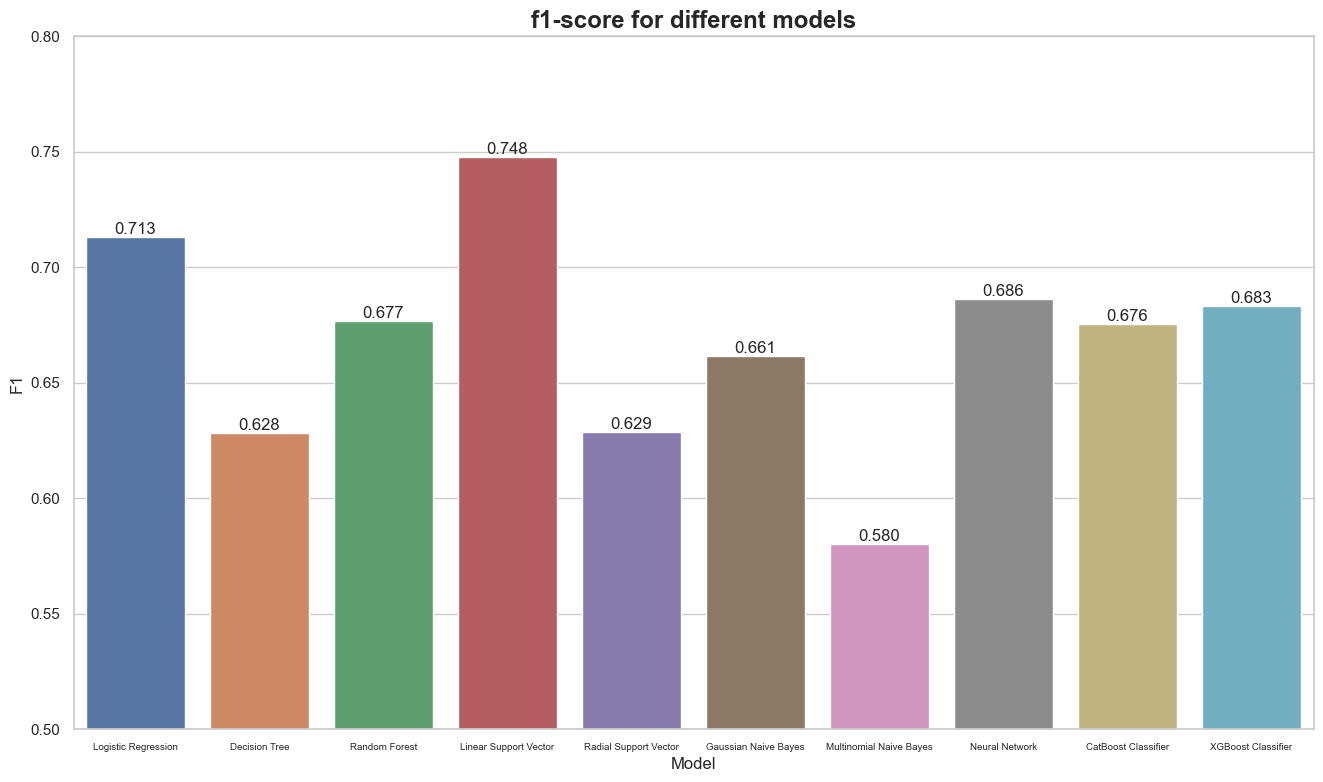

In [207]:
# Plot F1 performance of all models:
fig, ax = plt.subplots( figsize = (16,9) )
sns.barplot(data = result_df, x='Model', y='F1')
ax.set_xlabel("Model")
ax.set_ylim(0.5, 0.8)
ax.tick_params(axis='x', which='major', labelsize=7)
ax.set_title("f1-score for different models", fontweight='bold', fontsize="x-large")
ax.bar_label(ax.containers[0], fmt="%.3f")


We see that our best performing models are the Logistic Regression and Linear Support Vector. Let's investigate further into how they perform by visualizing their confusion matrices:

[[ 1.]
 [ 2.]
 [ 1.]
 ...
 [ 2.]
 [ 1.]
 [-1.]]


Text(0.5, 1.0, 'Confusion Matrix for Linear Support Vector')

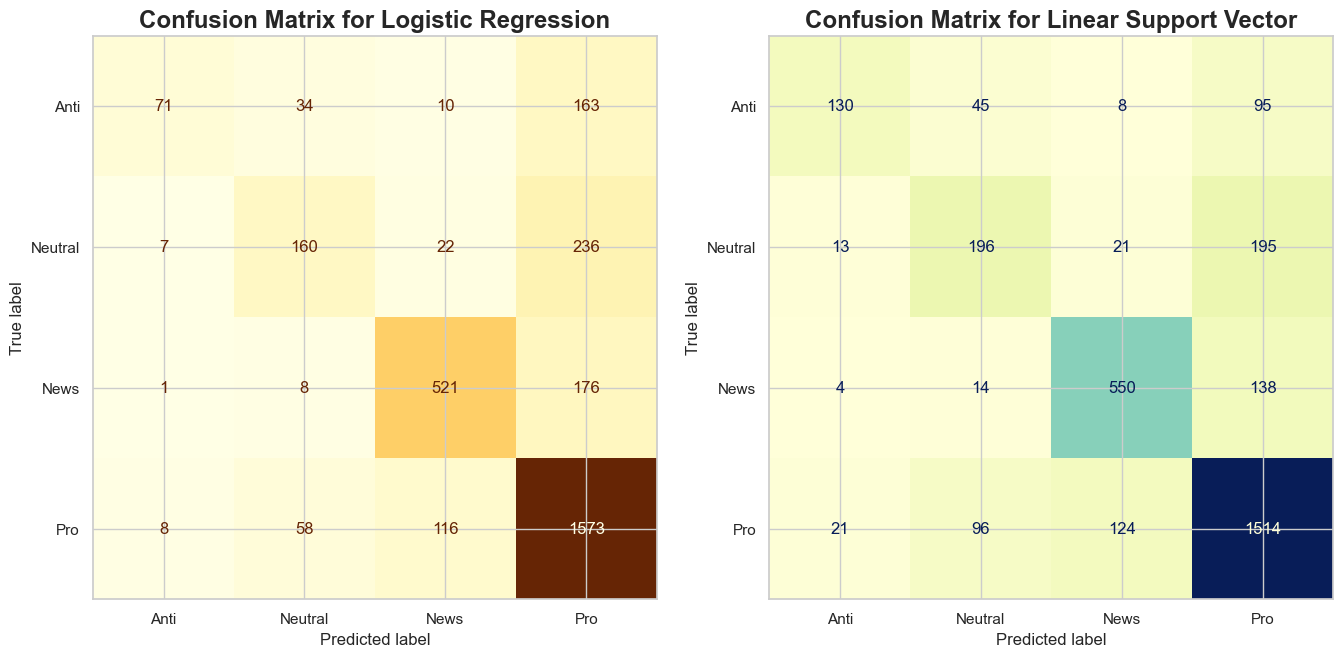

In [208]:
# Create Subplots
fig, axs = plt.subplots( 1, 2, figsize=(16,9))

print(np.array(y_test))
# Function to convert labels to text
def encode_labels_to_text(arr):
    ls = []
    for i in arr:
        if i == -1.0:
            ls.append("Anti")
        elif i == 0.0:
            ls.append("Neutral")
        elif i== 1.0:
            ls.append("Pro")
        elif i == 2.0:
            ls.append("News")
    return ls

# Converting to labels
log_reg_label_predictions = encode_labels_to_text(pred_log_reg)
lin_svc_label_predictions = encode_labels_to_text(pred_lin_svc)
actual_labels = encode_labels_to_text(np.array(y_test))



# Plot confusion matrices for top models
ConfusionMatrixDisplay.from_predictions(y_pred=log_reg_label_predictions, y_true=actual_labels, ax=axs[0], cmap='YlOrBr', colorbar=False)
ConfusionMatrixDisplay.from_predictions(y_pred=lin_svc_label_predictions, y_true=actual_labels, ax=axs[1], cmap='YlGnBu', colorbar=False)


axs[0].set_title("Confusion Matrix for Logistic Regression", fontweight="bold", fontsize="x-large", )
axs[1].set_title("Confusion Matrix for Linear Support Vector", fontweight="bold", fontsize="x-large")

We see that for the most part, the majority of our errors is due to the fact that these models predict a sentiment to be `Pro climate change`  when it doesn't fit within that category. This is almost certainly due to the fact that we have a lot more `Pro climate change` data than any other category, and the model overpredicts within this category . 

<a id="seven"></a>
## 7. Conclusion
<a class="anchor" id="1.1"></a>
<a href=#cont>Back to Table of Contents</a>



---

In conclusion, our best performing model for predicting sentiment, was our `Linear Support Vector`, achieving an f1 score of  $\approx 0.75$. All of the models struggled to predict in the `Anti-climate change` and `Neutral toward climate change` categories respectively. This could be due to the fact that our data was unbalanced. A further consideration is that it is difficult for our models to pick up on `Neutral` tweets, since they are not as easily distinguished from the other categories. 

Even though we introduced the ability to resample the data, it did not improve the predictive capabilities of our model. This may be due to the fact that the lesser represented categories needs significant upsampling to match the amount of entries within the `Pro climate change` sentiment. 

We also found that the TF-IDF vectorization technique worked better for the majority of our models compared to using a count vectorizer that only looks at the word frequency. 

In summary, the approach that yielded the best results were:
* Identifying and extracting the _retweet handles_, _hashtags_ and _mentions_ from the tweets
* Identifying if the tweet in question is a retweet
* Counting the amount of _mentions_, _hashtags_, _exclamation marks_, _newline characters_, and _web links_ present within the tweet
* Replacing contractions with their constituent words
* Replacing web links with a common alias
* Translating emojis within the tweet to produce meaningful text
* Removed the most common english stopwords that don't contribute to classification ability
* Removed punctuation and numbers from the tweets
* Performed Lemmetization on the tweets
* Removed uniquely occuring words from the dataset
* Use a Term Frequency - Inverse Document Frequency (TF_IDF) Vectorizer
* Forgo resampling the data
* Fit the data to a Linear Support Vector model with default hyperparameters

#### Future Considerations:

The best way to improve the predictive capabilities of our models, would be to include more data in the training process, specifically from categories that were underrepresented. 

Another path worth investigating, is using synthetic data generated by means of SMOTE- or similar methods to improve upon the imbalance of the dataset

For each individual model trained, we could also try to optimize the amount of features needed for obtaining the best predictive result by means of Forward- or Backward stepwise selection

Even though it is an extremely timely endeavour, it might also be of benefit to perform some hyperparameter tuning, especially on some of our more complicated models.

Another consideration is to use more advanced methods of preprocessing the tweets by applying contextualized embedding techniques like BERT or GPT. 

Lastly, we also wish to investigate if we could improve our performance by stacking some of the models used into ensembles, and using them to generate predictions

